# <span style='font-family:"Times New Roman"'> <span styel=''> **COHORT SUBGROUPS CREATION**

## <span style='font-family:"Times New Roman"'> <span styel=''> *Emile Cohen* 
*March 2020*

**Goal:** In this notebook, we create subgroups of the cohort, based on their Copy Number State and their mutational profile. For that we create functions to visualize vaf, ccf, purity, 'Expected Number of copies of TP53 mutations' densities but also scatterplots of VAF1/VAF2, CCF1/CCF2 and VAF/CF.
    
The Notebook is divided in 2 parts:
   
* **1. Function Definition**
* **2. Loading Master**
* **3. Group Creation**
* **4. Data Exploration**
* **5. Final Subgroups Analysis**

**NB1:** In each part, you must run the cells from the begining in order to initialize the variables

**NB2:** All functions used for the plots are located in utils/custom_tools.py

---

In [12]:
%run -i '../../utils/setup_environment.ipy'
from utils.analysis_tools import *

import warnings, math
warnings.filterwarnings('ignore')
import ptitprince as pt
import IPython.display

data_path = '../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

---
## Function Definition

In this part we define the needed functions to plot summaries of each subgroup.

---

The following *f1, f2* and *f3* allow to recompute the ccf (cancer cell fraction), based on Teng repository Github (https://github.com/papaemmelab/driverclone/blob/master/utils.r#L124-L175)

In [2]:
def f1(x):
    if math.isnan(x.exp_nb_1):
        return float('NaN')
    else: 
        if x.exp_nb_1 >= 1 :
            m_star = round(x.exp_nb_1)
        else : m_star = 1
        return (x.exp_nb_1/m_star)
    
def f2(x):
    if math.isnan(x.exp_nb_2):
        return float('NaN')
    else: 
        if x.exp_nb_2 >= 1 :
            m_star = round(x.exp_nb_2)
        else : m_star = 1
        return (x.exp_nb_2/m_star)
    
def f3(x):
    if math.isnan(x.exp_nb_3):
        return float('NaN')
    else: 
        if x.exp_nb_3 >= 1 :
            m_star = round(x.exp_nb_3)
        else : m_star = 1
        return (x.exp_nb_3/m_star)

---
We define 4 functions that will allow us to print easily the summary report of our subgroups.

1. plot_ccf_vaf
2. plot_scatters
3. plot_purity_numbers
4. plot_copies_tcn

In [3]:
def plot_ccf_vaf(data, group_name):
    
    data_vaf = list(data['vaf_1']) + list(data['vaf_2']) + list(data['vaf_3'])
    data_ccf = list(data['ccf_1']) + list(data['ccf_2']) + list(data['ccf_3'])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharex=True)
    f.suptitle(group_name+' SUMMARY', fontsize=16)
    
    sns.distplot(data_vaf, kde_kws={'clip': (0.0, 1.0)}, hist=False, ax=ax1)
    ax1.set_ylabel('Density Estimation')
    ax1.set_xlabel('VAF of TP53 mutations')

    sns.distplot(data_ccf, hist=False, ax=ax2)
    ax2.set_xlabel('CCF of TP53 mutations')
    
    plt.show()

    
    
def plot_scatters(data, group_name, group):
    
    data_vaf = data[['vaf_1', 'vaf_2', 'vaf_3']]
    max_table_vaf = pd.DataFrame(np.sort(data_vaf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_vaf = pd.concat([max_table_vaf, data.reset_index().cn_state], axis=1)
    
    data_ccf = data[['ccf_1', 'ccf_2', 'ccf_3']]
    max_table_ccf = pd.DataFrame(np.sort(data_ccf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_ccf = pd.concat([max_table_ccf, data.reset_index().cn_state], axis=1)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True)
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_vaf, hue='cn_state',hue_order=group, ax=ax1, palette="muted")
    ax1.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax1.set_ylabel('VAF_2')
    ax1.set_xlabel('VAF_1')
    ax1.set_title('VAF', weight = 'bold')
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_ccf, hue='cn_state',hue_order=group, ax=ax2, palette="muted")
    ax2.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax2.set_ylabel('CCF_2')
    ax2.set_xlabel('CCF_1')
    ax2.set_title('CCF', weight = 'bold')
    
    plt.show()
    
def plot_purity_numbers(data, group, group_name, mut_cn_group=False): 
    if mut_cn_group:
        f, ax1 = plt.subplots(1, 1, figsize=(5.5, 3))
        sns.distplot(data['purity'], hist=False,kde_kws={'clip': (0.0, 1.0)}, ax=ax1)
        ax1.set_xlim([0,1])
        ax1.set_xlabel('Purity')
        ax1.set_ylabel('Density Estimation')
        ax1.set_title('Purity', weight = 'bold')
    if mut_cn_group==False:
        f, axs = plt.subplots(1, 2, figsize=(14, 4))
        ax1 = axs[0]
        sns.distplot(data['purity'], hist=False,kde_kws={'clip': (0.0, 1.0)}, ax=ax1)
        ax1.set_xlim([0,1])
        ax1.set_xlabel('Purity')
        ax1.set_ylabel('Density Estimation')
        ax1.set_title('Purity', weight = 'bold')

        ax2 = axs[1]
        #sns.distplot(data['exp_nb_1'], hist=False, label=group_name, ax=ax2, color='black')
        for cn_state in group:
            sns.distplot(data[data['cn_state'] == cn_state]['exp_nb_1'], hist=False, label = cn_state, ax=ax2)
        ax2.set_xlim([-1,6])
        ax2.set_xlabel('Expected copies of tp53 mutations')
        ax2.set_ylabel('Density Estimation')
        ax2.set_title('Expected number of mutants copies per cell', weight = 'bold')

def plot_copies_tcn(data, group, group_name, nb_muts):
    data = filter_muts(data, nb_muts)
    data_1 =  pd.DataFrame(data[['Tumor_Id','exp_nb_1']])
    data_1.columns = ['Tumor_Id', 'exp_nb']
    data_2 = pd.DataFrame(data[['Tumor_Id','exp_nb_2']])
    data_2.columns = ['Tumor_Id', 'exp_nb']
    data_3 = pd.DataFrame(data[['Tumor_Id','exp_nb_3']])
    data_3.columns = ['Tumor_Id', 'exp_nb']
    data_tot = data_1.append(data_2)
    data_tot = data_tot.append(data_3)
    
    data_tot = pd.merge(left=data_tot, right=data[['Tumor_Id','cn_state', 'tcn']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    dx="tcn"; dy="exp_nb"; ort="h"; pal = "muted"; sigma = .2; dhue = "cn_state"; dhue_order=group
    f, ax = plt.subplots(figsize=(15, 10))

    ax=pt.RainCloud(x = dx, y = dy, data = data_tot, palette = pal, bw = sigma, hue=dhue, hue_order=dhue_order,
                 width_viol = .6, ax = ax, orient = ort, alpha=.6, mv=.2)
    ax.set_ylabel('Total Copy Number')
    ax.set_xlabel('Expected number of copies of Tp53 mutations')
    ax.set_title('Determining subgroups with WT alleles for 1mut', weight = 'bold')

Finally, we define *plot_summary* that uses the functions above to compute a visual summary of the group

In [6]:
def plot_summary(group: list, group_name: str, nb_muts_density=[1,2,3], nb_muts_scatter=[2,3], mut_cn_group=False):
    
    # DENSITY PLOTS
    master_density = filter_muts(master, nb_muts_density)
    if mut_cn_group:
        master_density = filter_general(master_density, 'mut_cn_group', group)
        #display(master_density)
    else: master_density = filter_cn_state(master_density, group)
    

    sns.set_palette("muted", len(set(master_density.cn_state)),1)
    
    display(get_groupby(master_density, 'cn_state', 'count'))
    #master_density = master_density[master_density['wgd'] == 1]
    plot_ccf_vaf(master_density, group_name)
    
    # SCATTER PLOTS
    if nb_muts_scatter != 0:
        master_scatter = filter_muts(master, nb_muts_scatter)
        if mut_cn_group:
            master_scatter = filter_general(master_scatter, 'mut_cn_group', group)
            group = list(set(master_scatter.cn_state))
        else: 
            master_scatter = filter_cn_state(master_scatter, group)

        plot_scatters(master_scatter, group_name, group)

    # Plot Purity distribution and expected number of mutants copy distribution
    plot_purity_numbers(master_density, group, group_name, mut_cn_group)
    
    # Plot number of mut copies VS tcn 
    if 1 in nb_muts_density:
        plot_copies_tcn(master_density, group, group_name, [1])
    else: plot_copies_tcn(master_density, group, group_name, [2,3,4,5])

---
## Loading Master

We load the master file and create 3 new columns: for each mutation we compute a Cancer Cell Fraction (CCF), from the Lab Github. This CCF is uncapped and go above 1, contrary to the one given in the Facets output.

In [5]:
# LOADING THE MASTER FILE
master = pd.read_pickle(data_path + 'merged_data/master_file.pkl')

master['ccf_comp_1'] = master.apply(f1, axis = 1)
master['ccf_comp_2'] = master.apply(f2, axis = 1)
master['ccf_comp_3'] = master.apply(f3, axis = 1)

master.head()

Sample_Id           Tumor_Id Patient_Id  \
0  P-0034223-T01-IM6_P-0034223-N01-IM6  P-0034223-T01-IM6  P-0034223   
1  P-0009819-T01-IM5_P-0009819-N01-IM5  P-0009819-T01-IM5  P-0009819   
2  P-0025956-T01-IM6_P-0025956-N01-IM6  P-0025956-T01-IM6  P-0025956   
3  P-0027408-T01-IM6_P-0027408-N01-IM6  P-0027408-T01-IM6  P-0027408   
4  P-0006554-T01-IM5_P-0006554-N01-IM5  P-0006554-T01-IM5  P-0006554   

                  Cancer_Type Sample_Type    purity    ploidy  \
0               Breast Cancer  Metastasis  0.941111  2.241830   
1             Prostate Cancer     Primary  0.275237  2.681075   
2  Non-Small Cell Lung Cancer     Primary  0.185874  3.496971   
3  Non-Small Cell Lung Cancer  Metastasis  0.308886  1.811066   
4                      Glioma     Primary  0.715208  1.910719   

   samples_per_patient Overall Survival Status  Overall Survival (Months)  \
0                  1.0                  LIVING                        NaN   
1                  1.0                  LIVING                     23.441   
2                  1.0                DECEASED                      3.584   
3                  1.0                  LIVING                     22.586   
4                  1.0                  LIVING                     26.170   

   MSI Score                               key_1               vc_1  ccf_1  \
0       0.55                                None               None    NaN   
1       0.00                                None               None    NaN   
2       0.00                                None               None    NaN   
3       0.27  P-0027408-T01-IM6_17_7578409_CT_TC  Missense_Mutation  0.925   
4       1.30                                None               None    NaN   

      vaf_1      HGVSp_1 spot_1 key_2  vc_2  ccf_2  vaf_2 HGVSp_2 spot_2  \
0       NaN         None   None  None  None    NaN    NaN    None   None   
1       NaN         None   None  None  None    NaN    NaN    None   None   
2       NaN         None   None  None  None    NaN    NaN    None   None   
3  0.168901  p.Arg174Glu    174  None  None    NaN    NaN    None   None   
4       NaN         None   None  None  None    NaN    NaN    None   None   

  key_3  vc_3  ccf_3  vaf_3 HGVSp_3 spot_3 key_4  vc_4  ccf_4  vaf_4 HGVSp_4  \
0  None  None    NaN    NaN    None   None  None  None    NaN    NaN    None   
1  None  None    NaN    NaN    None   None  None  None    NaN    NaN    None   
2  None  None    NaN    NaN    None   None  None  None    NaN    NaN    None   
3  None  None    NaN    NaN    None   None  None  None    NaN    NaN    None   
4  None  None    NaN    NaN    None   None  None  None    NaN    NaN    None   

  spot_4 key_5  vc_5  ccf_5  vaf_5 HGVSp_5 spot_5  tp53_count  tcn  mcn  lcn  \
0   None  None  None    NaN    NaN    None   None           0  2.0  1.0  1.0   
1   None  None  None    NaN    NaN    None   None           0  1.0  1.0  0.0   
2   None  None  None    NaN    NaN    None   None           0  NaN  NaN  NaN   
3   None  None  None    NaN    NaN    None   None           1  1.0  1.0  0.0   
4   None  None  None    NaN    NaN    None   None           0  2.0  NaN  NaN   

   seg_length       cn_state        cf  wgd  mutation_count  gene_count  \
0  80668592.0        DIPLOID  1.000000 -1.0               6         6.0   
1  80668309.0        HETLOSS  0.154578 -1.0               3         3.0   
2         NaN            NaN       NaN  NaN               6         6.0   
3  25260272.0        HETLOSS  0.315621 -1.0              21        19.0   
4   7465132.0  INDETERMINATE       NaN  NaN              47        39.0   

    max_vaf  exp_nb_1  exp_nb_2  exp_nb_3  exp_nb_4  exp_nb_5   cn_group  \
0  0.901899       NaN       NaN       NaN       NaN       NaN  WILD_TYPE   
1  0.148014       NaN       NaN       NaN       NaN       NaN       LOSS   
2  0.200000       NaN       NaN       NaN       NaN       NaN       None   
3  0.192475  0.924711       NaN       NaN       NaN       NaN       LOSS   
4  0.706897       NaN  

---
## Group Creation

We defined these two sets of cn_state groups earlier in the work, when we wanted to discover the data. The last one is in **Data Exploration** part, with the summary plots associated.

In [8]:
# Groups definition
WT_present = ['DIPLOID', 'TETRAPLOID', 'LOSS AFTER', 'DOUBLE LOSS AFTER']
loh = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH & GAIN', 'CNLOH BEFORE & GAIN', 'AMP (LOH)']
loss_withorwithout_WT = ['HETLOSS', 'LOSS BEFORE', 'HOMDEL', 'LOSS BEFORE & AFTER']
gain = ['GAIN', 'AMP', 'AMP (BALANCED)', 'LOSS & GAIN']

In [9]:
# Groups definition
LOH = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH AFTER', 'CNLOH BEFORE', 'CNLOH & GAIN', 'CNLOH BEFORE & GAIN', 'AMP (LOH)']
LOSS = ['HETLOSS', 'LOSS BEFORE', 'LOSS AFTER', 'HOMDEL', 'LOSS BEFORE & AFTER', 'DOUBLE LOSS AFTER']
GAIN = ['GAIN', 'AMP', 'AMP (BALANCED)', 'LOSS & GAIN', 'TETRAPLOID']
DIPLOID = ['DIPLOID']
indeterminate = ['INDETERMINATE']
total = LOH + LOSS + GAIN + DIPLOID

---
## Data Exploration

Skip This Part to see directly the final subgroups.

Here we have the exploratory groups that we defined previously and allowed us to define the final subgroups.
Each plot is done with the following parameters:
* *nb_muts_density* = [1,2,3] is the number of tp53 mutations we selected to plot the densities (vaf, ccf, purity)
* *nb_muts_scatter* = [2,3] is the number of tp53 mutations we selected to plot the scatters (VAF1/VAF2 and CCF1/CCF2)
* For the plot of expected number of tp53 mutations copies, we selected only 1 mutation samples

In [10]:
# Group Definition
WT_allele = ['LOSS AFTER', 'DIPLOID', 'TETRAPLOID']
LOSS_noWT = ['LOSS BEFORE', 'HETLOSS', 'LOSS BEFORE & AFTER']
LOH_noWT = ['CNLOH', 'CNLOH BEFORE & LOSS', 'CNLOH BEFORE', 'CNLOH BEFORE & GAIN']
GAIN_WT = ['AMP', 'GAIN','LOSS & GAIN']
AMBIGUOUS = ['CNLOH AFTER', 'DOUBLE LOSS AFTER']
MISSING = ['HOMDEL', 'AMP (BALANCED)', 'AMP (LOH)']

count
cn_state         
DIPLOID      1711
LOSS AFTER    271
TETRAPLOID     82

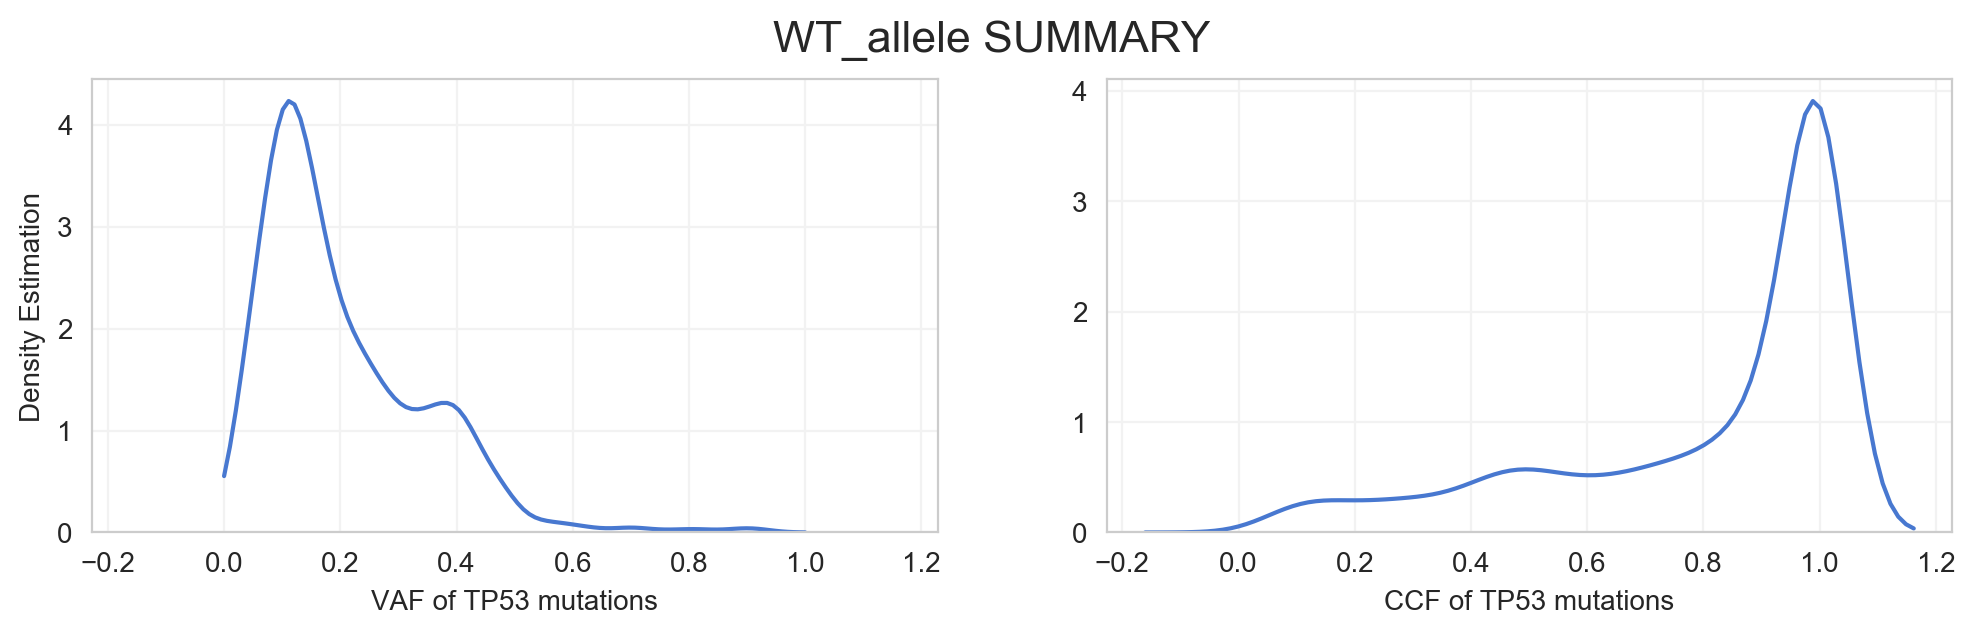

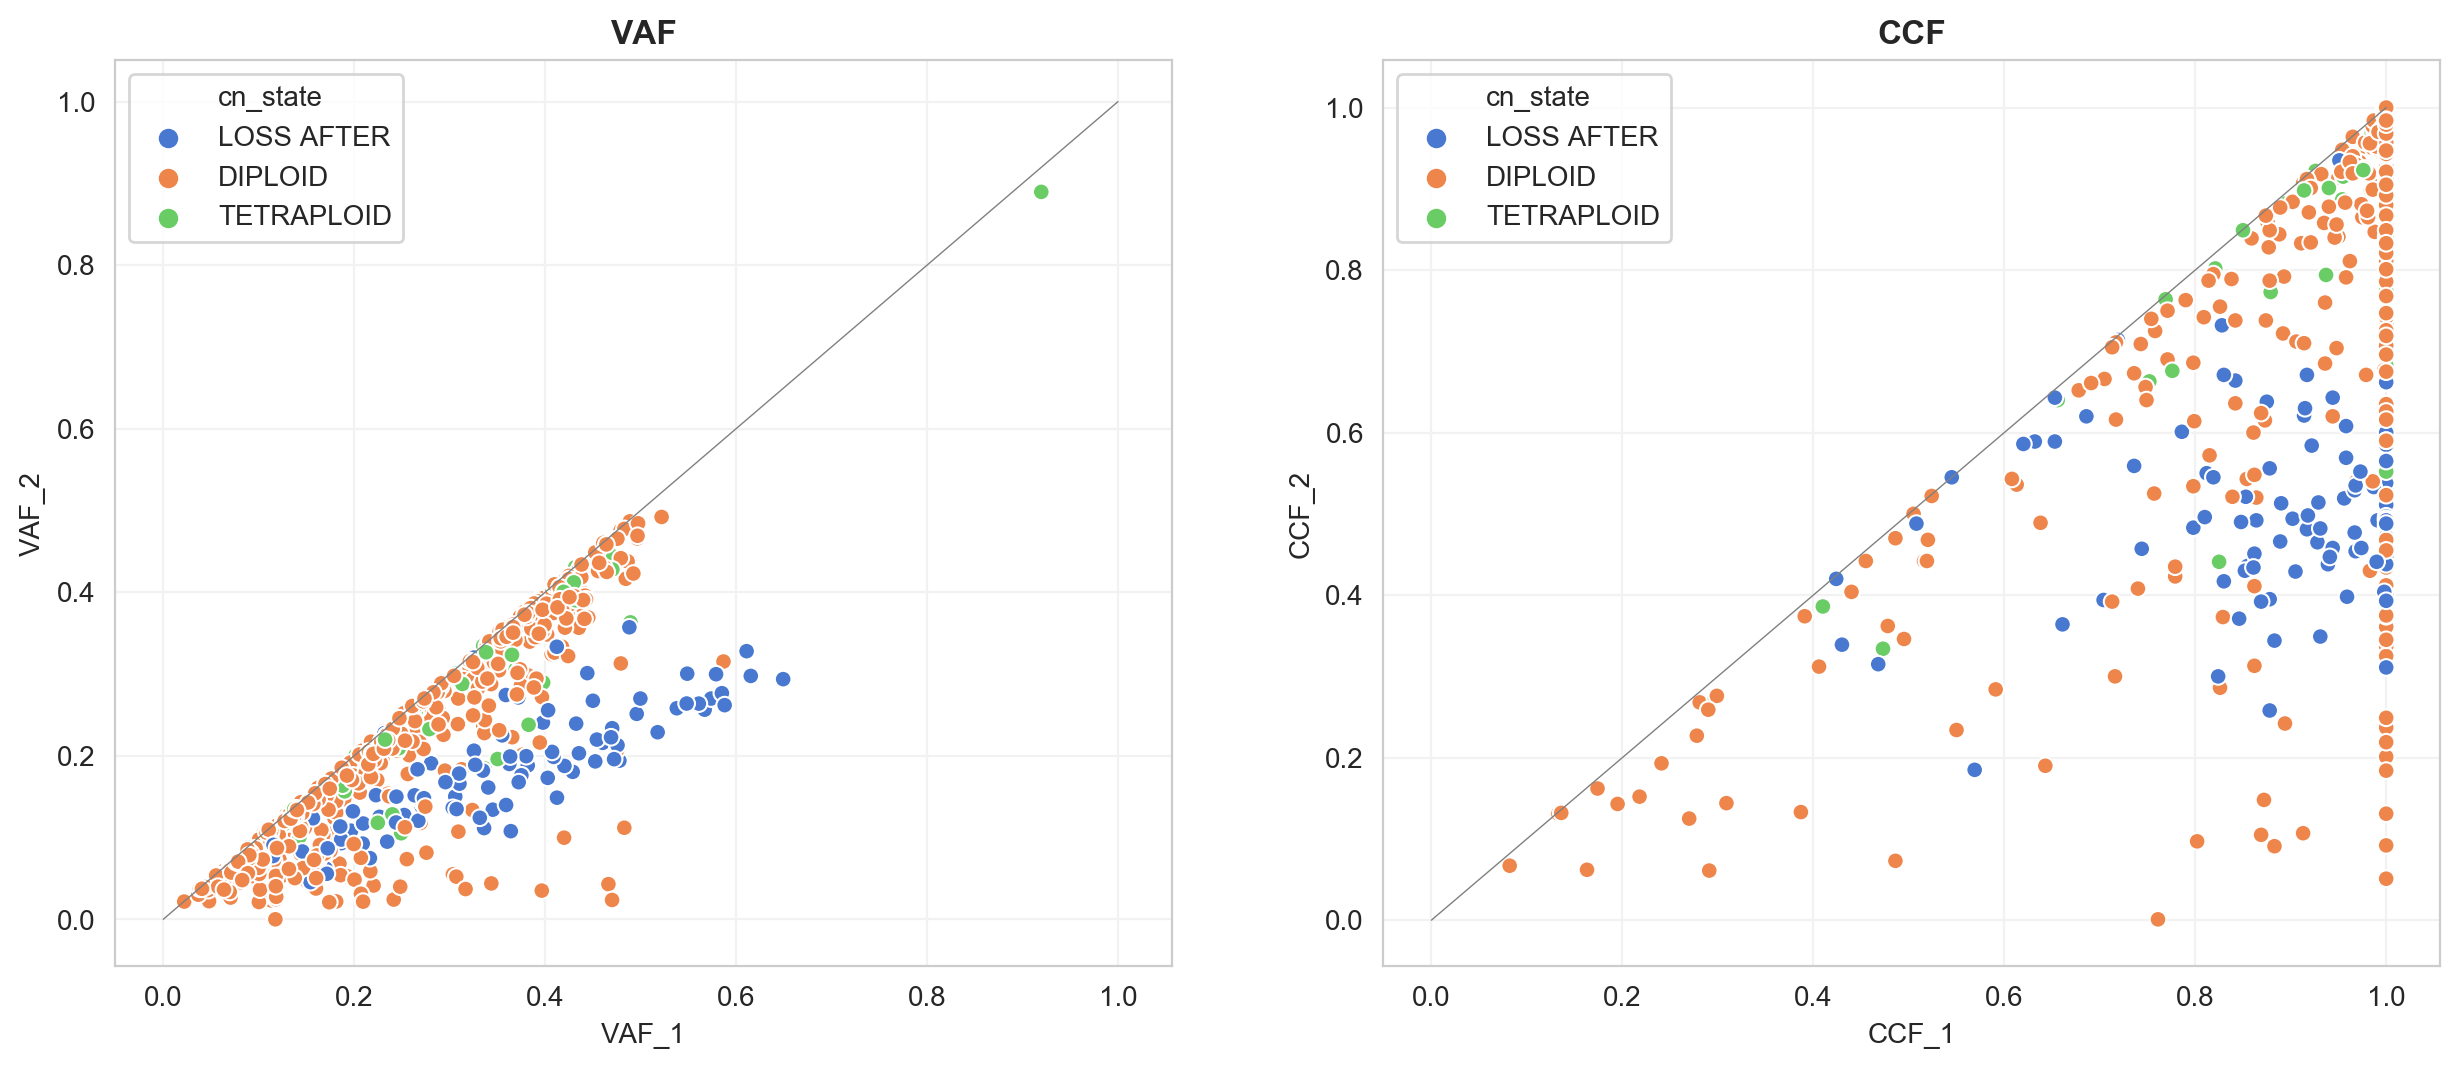

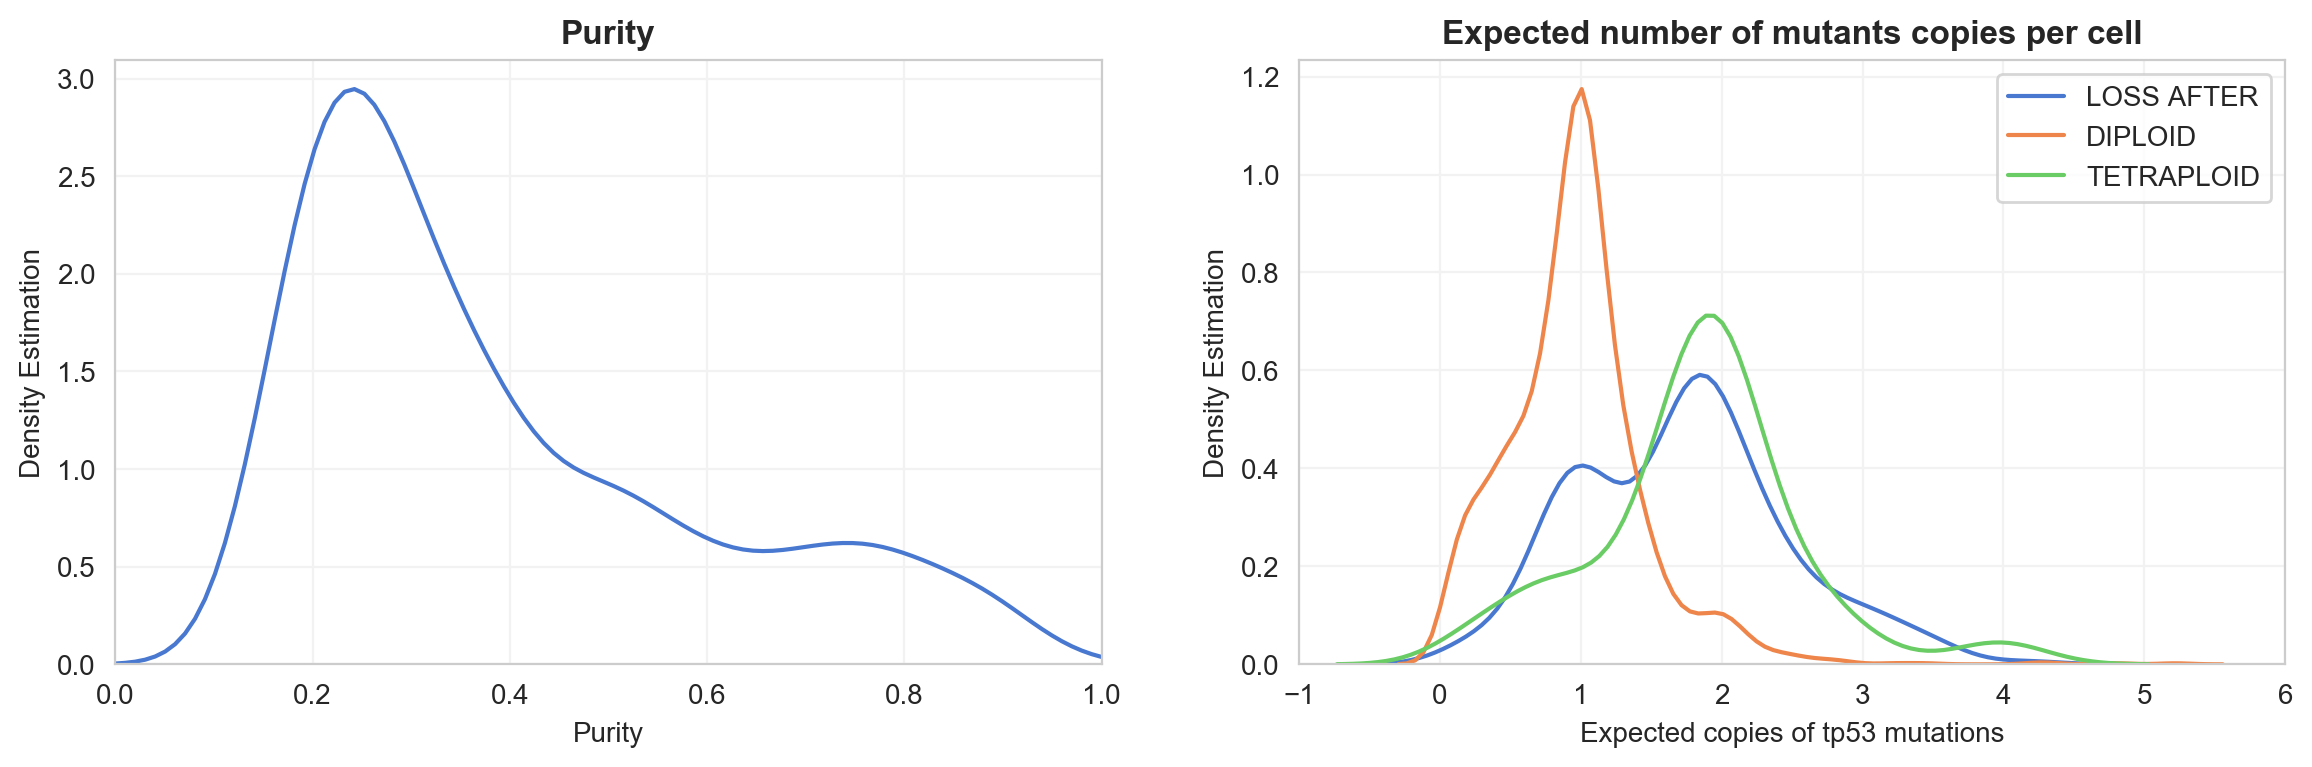

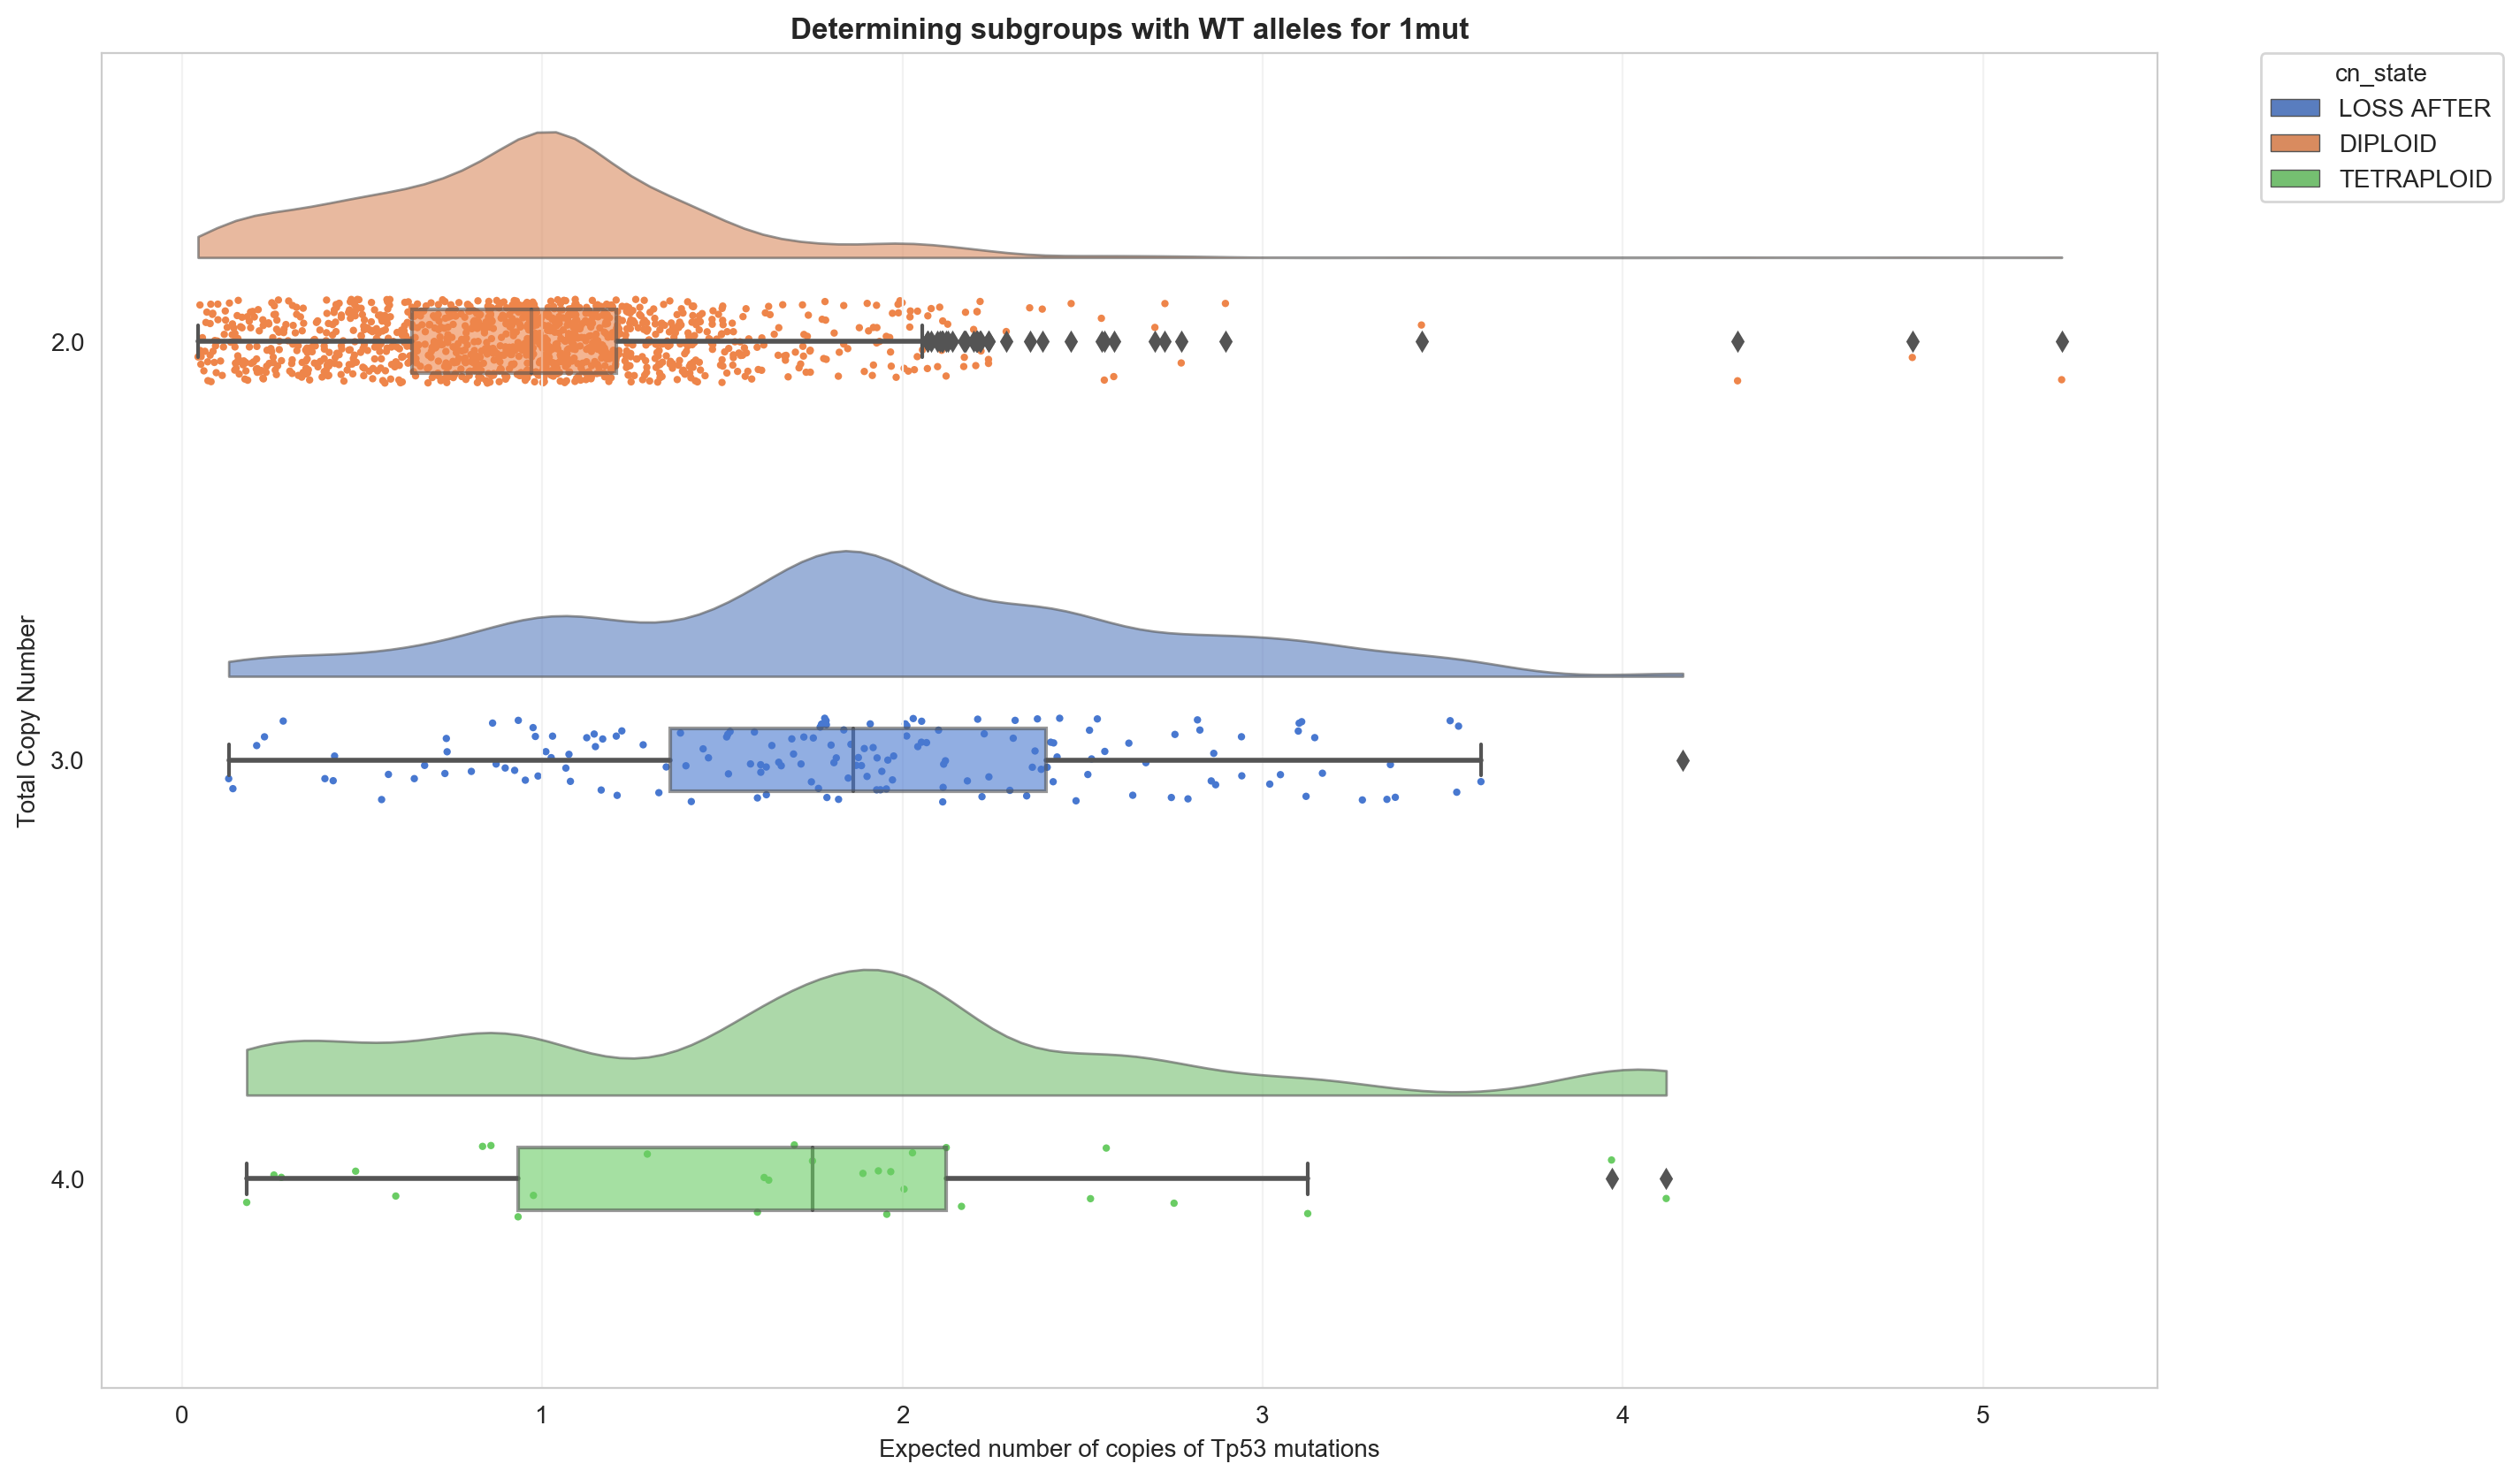

In [13]:
plot_summary(WT_allele,'WT_allele')

count
cn_state                  
HETLOSS               3727
LOSS BEFORE           3131
LOSS BEFORE & AFTER    226

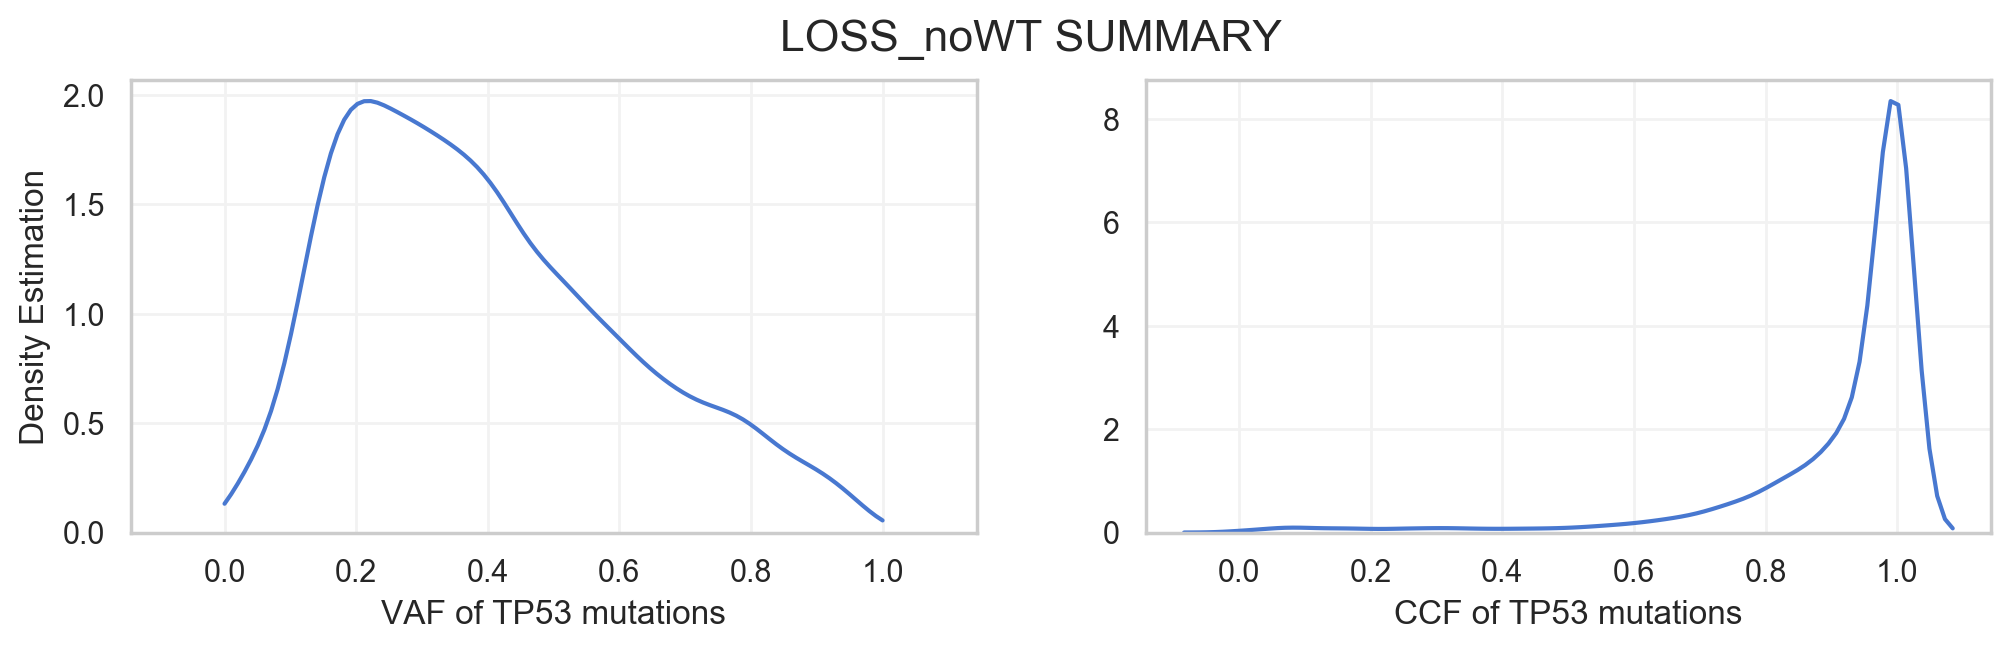

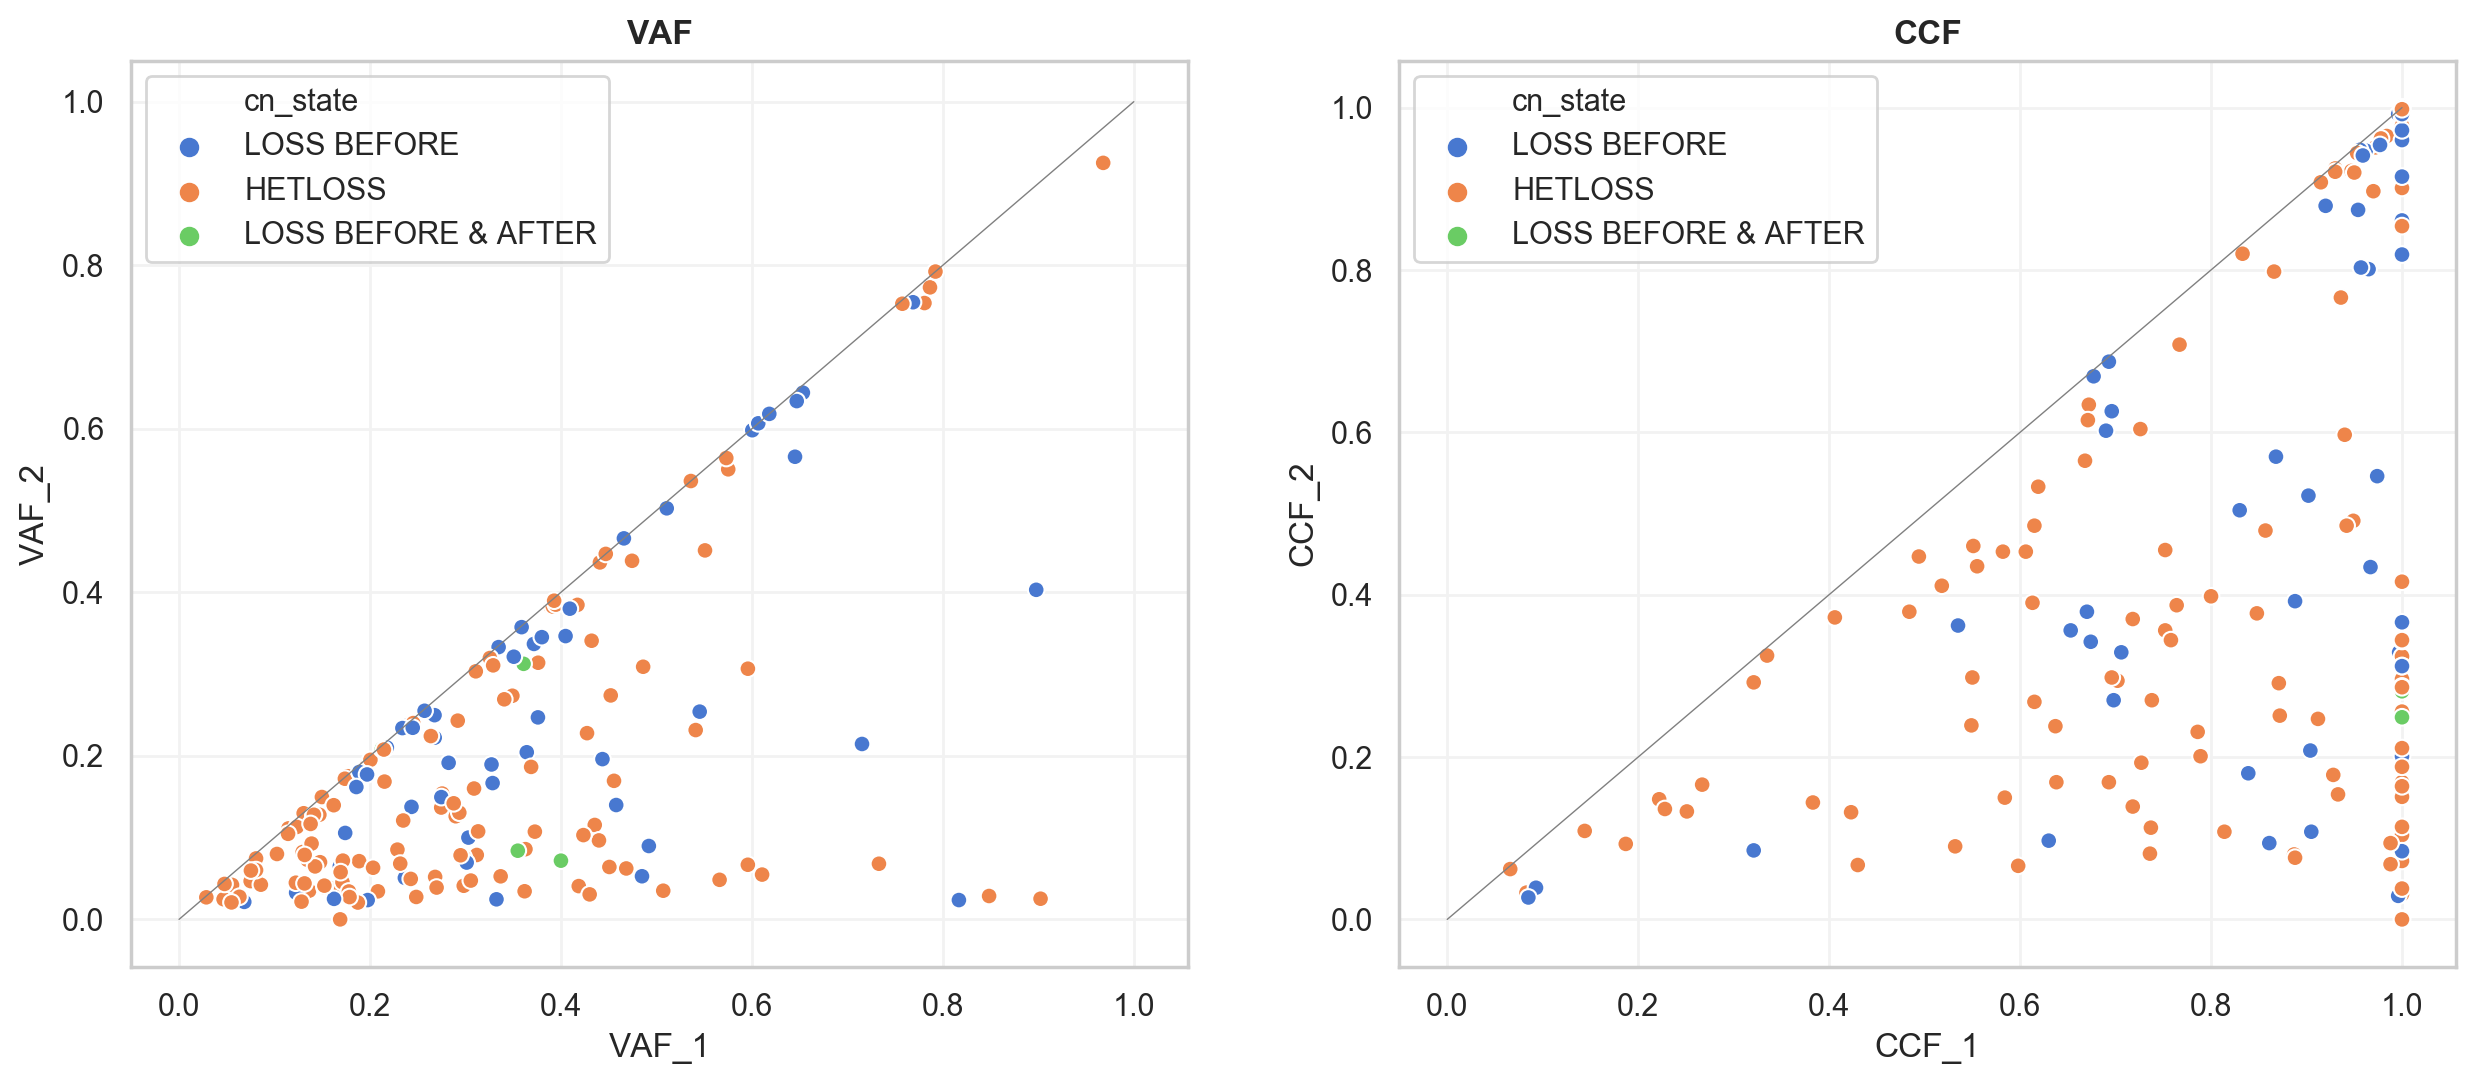

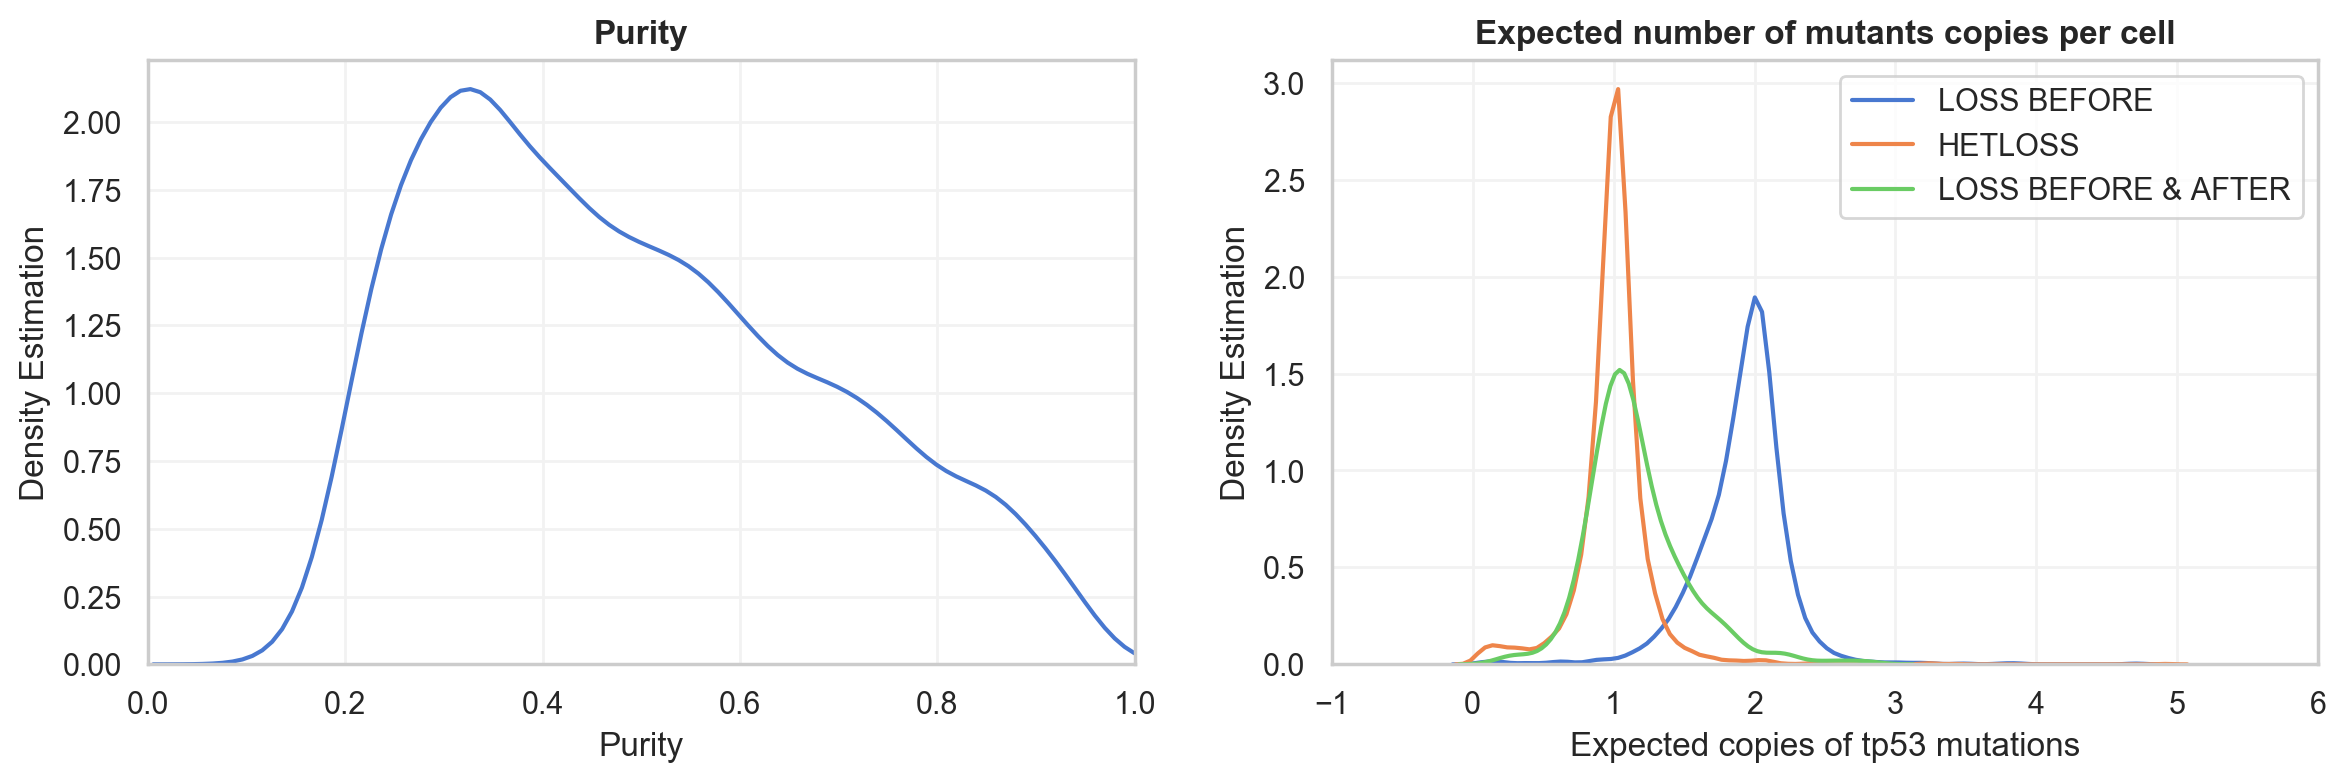

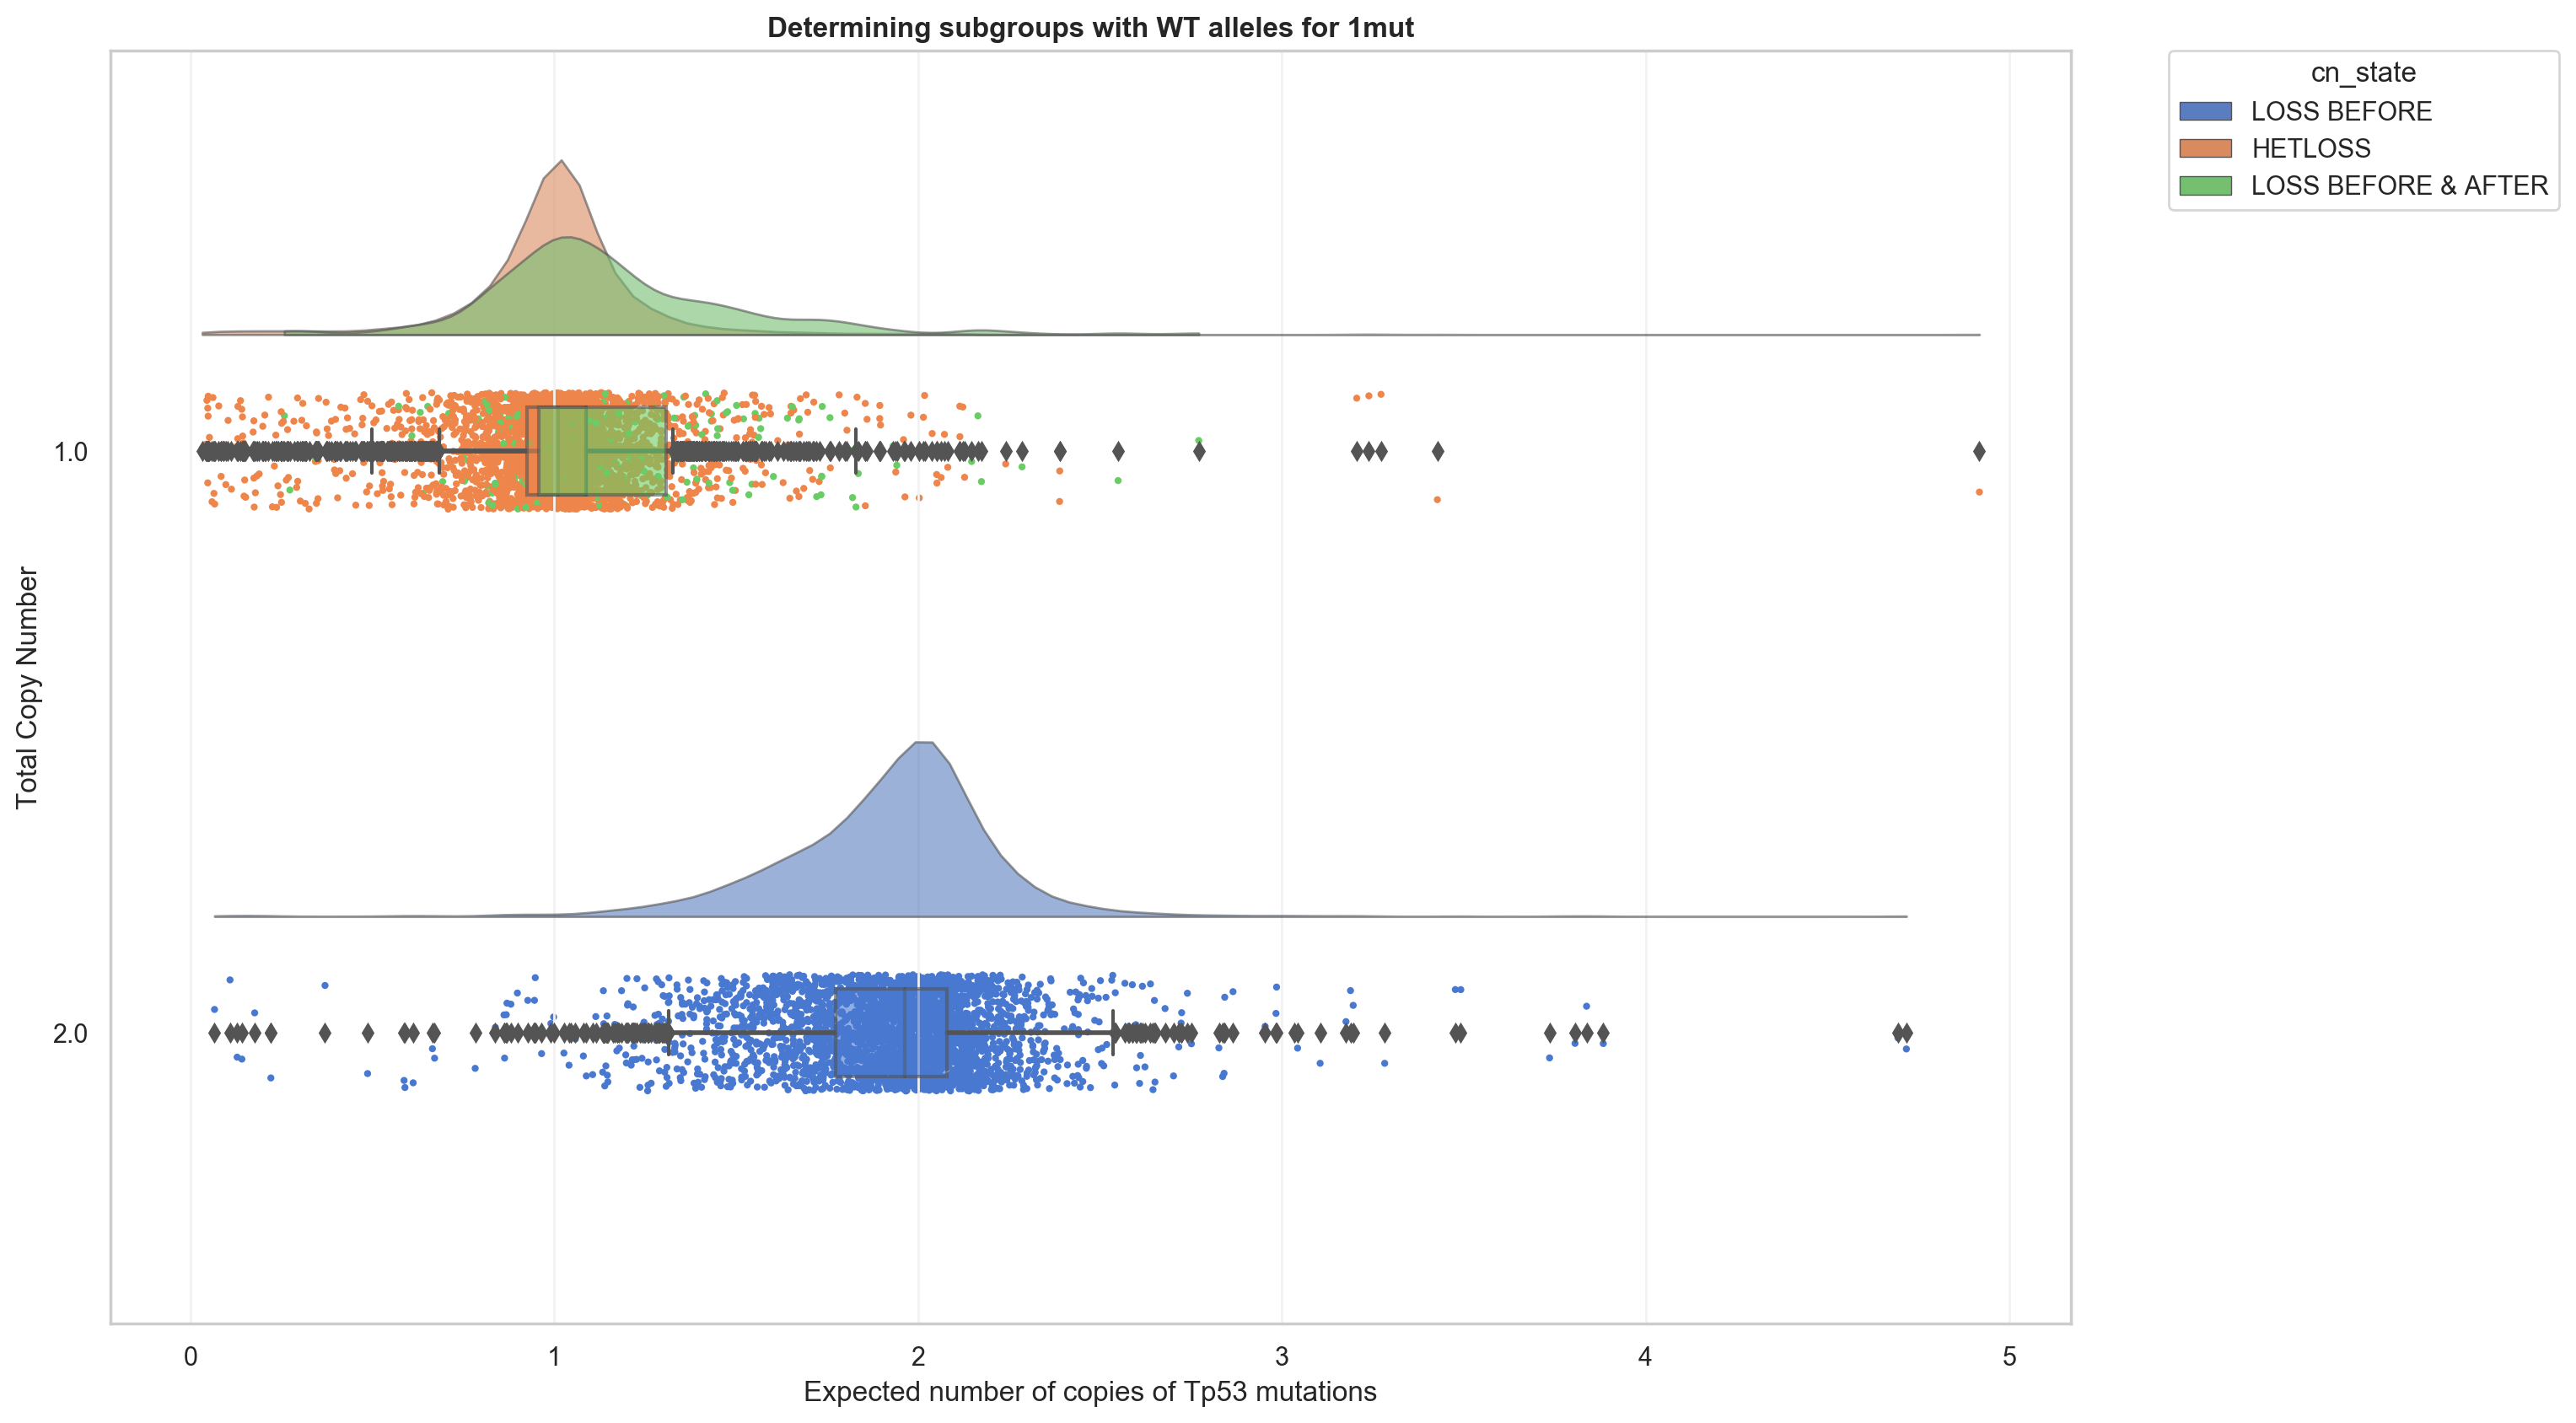

In [94]:
plot_summary(LOSS_noWT,'LOSS_noWT')

count
cn_state                  
AMP (LOH)               12
CNLOH                  802
CNLOH & GAIN            61
CNLOH AFTER             43
CNLOH BEFORE           174
CNLOH BEFORE & GAIN     26
CNLOH BEFORE & LOSS    893

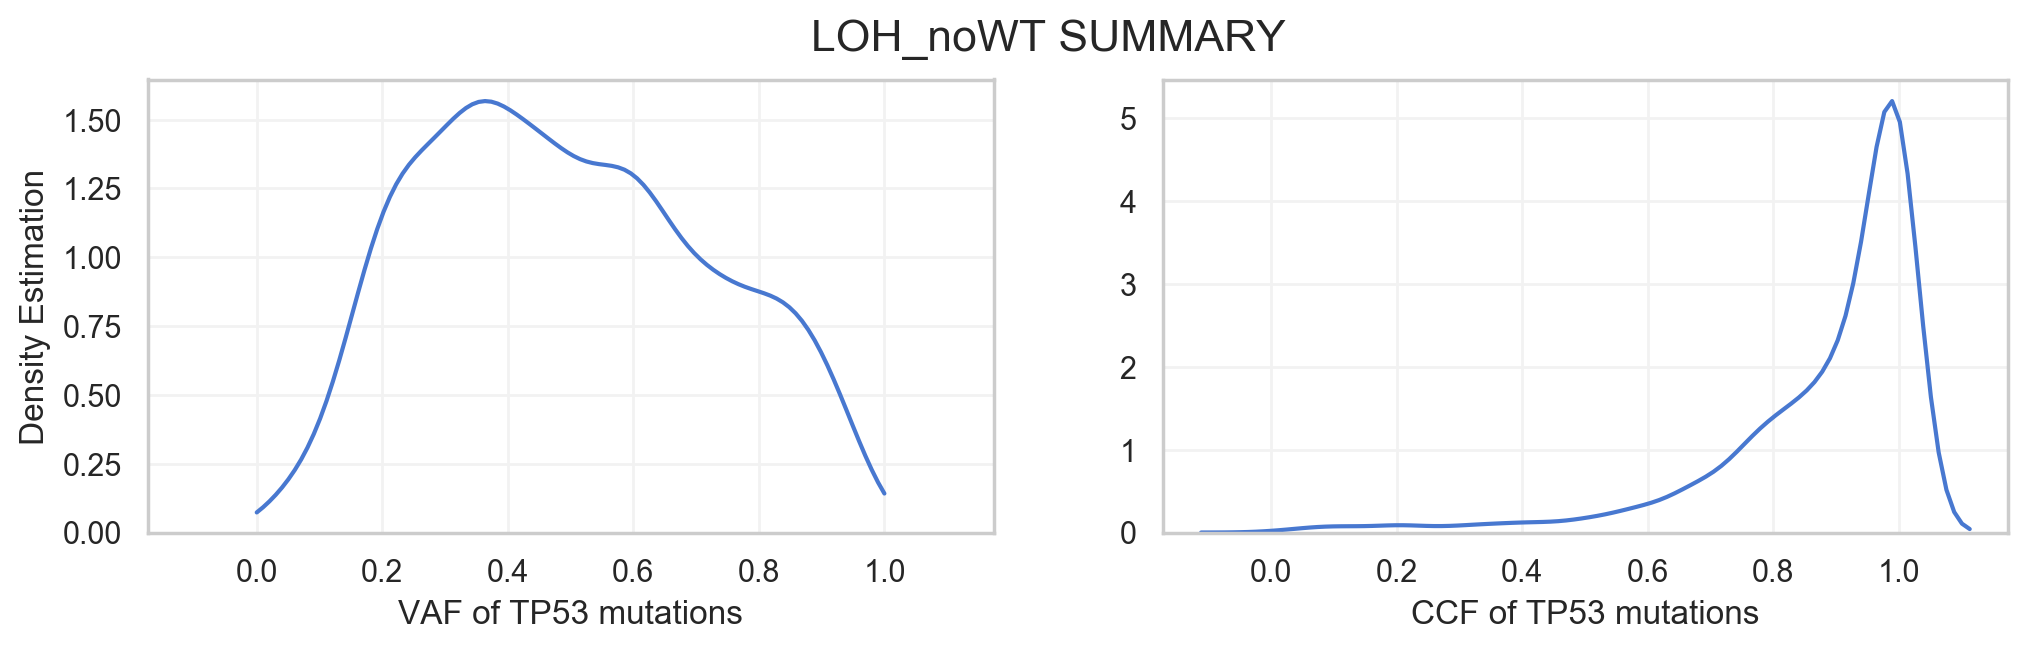

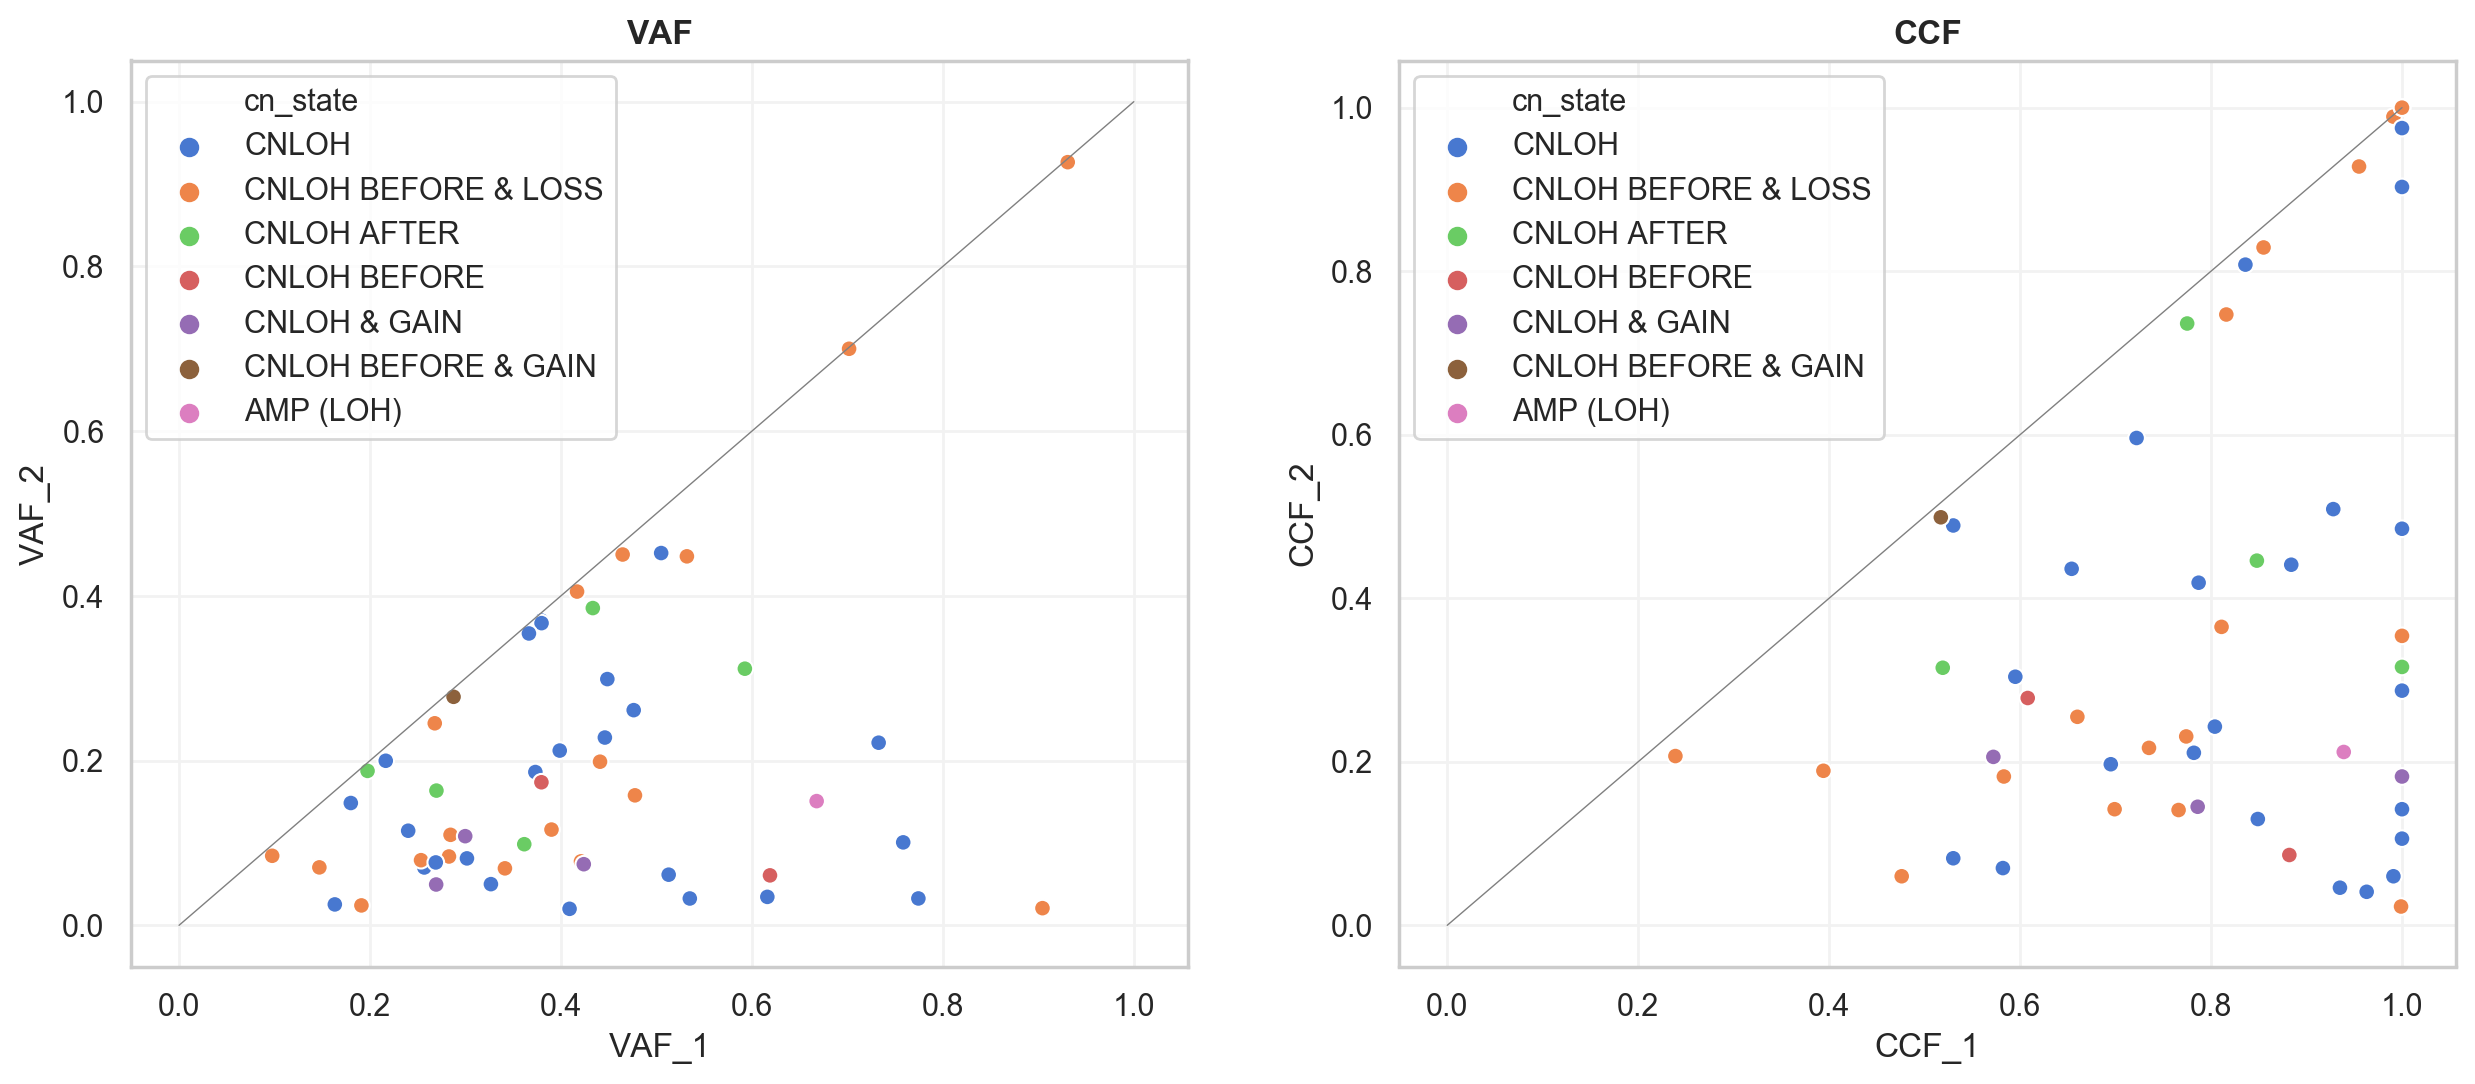

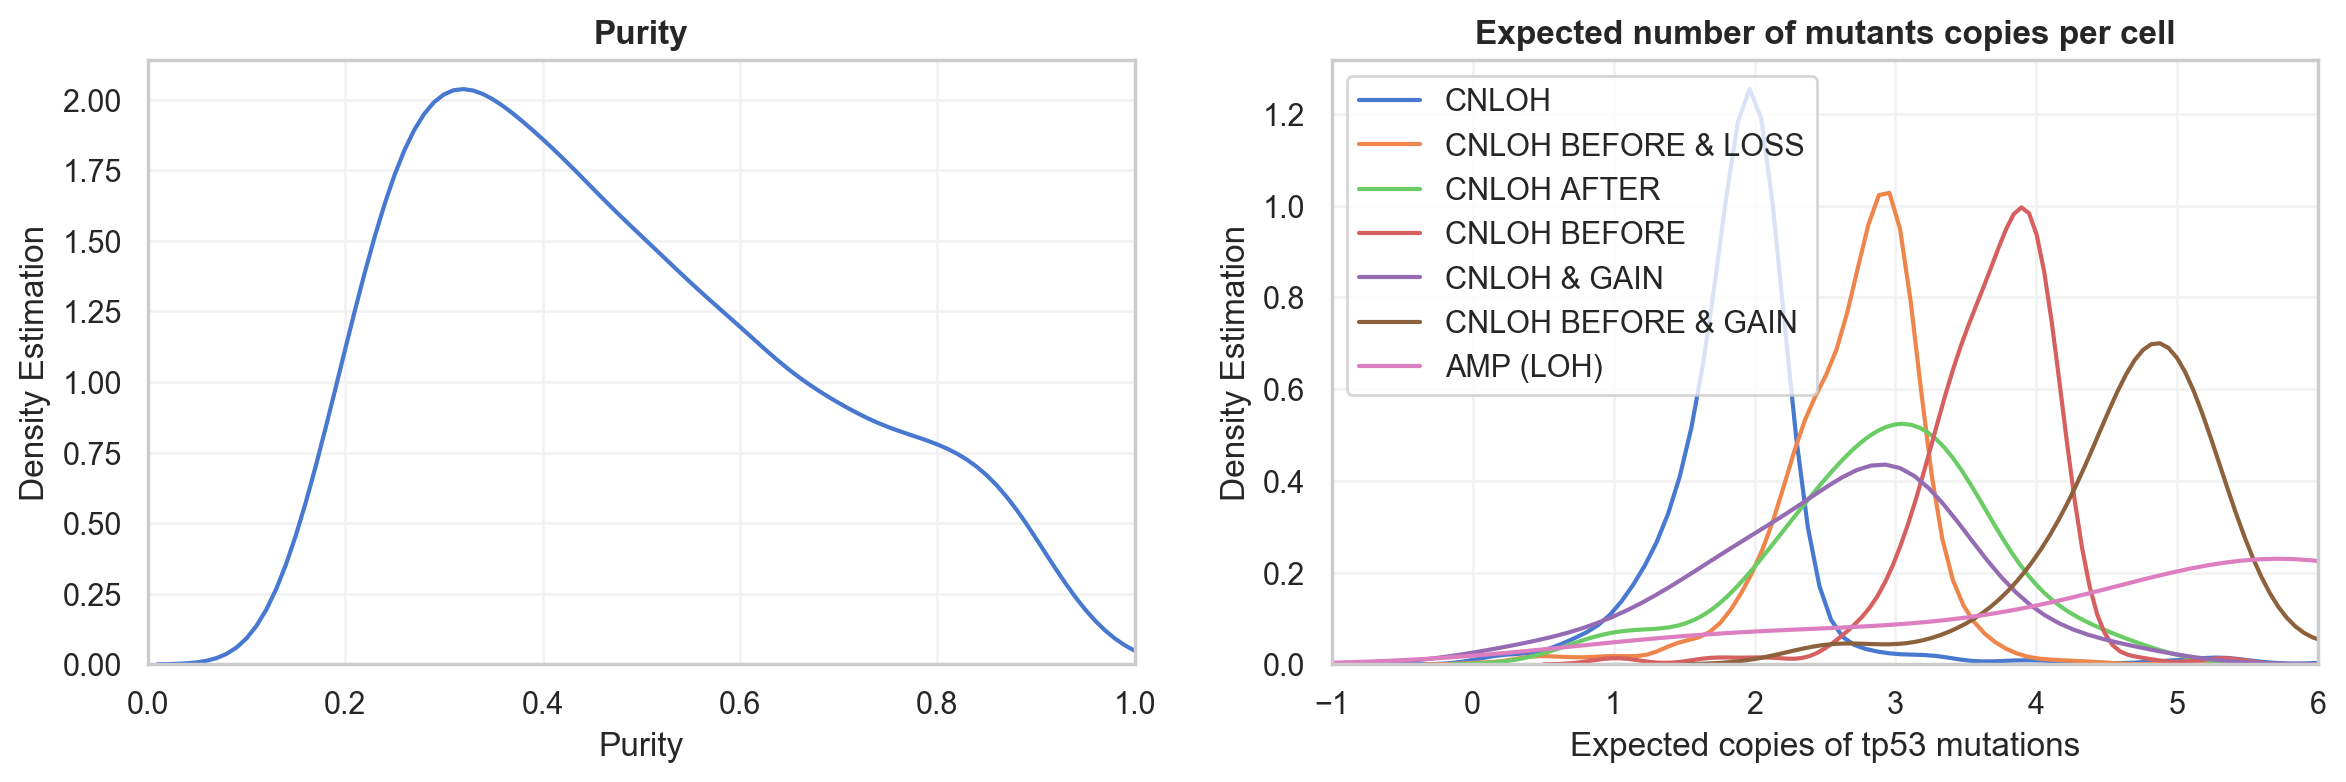

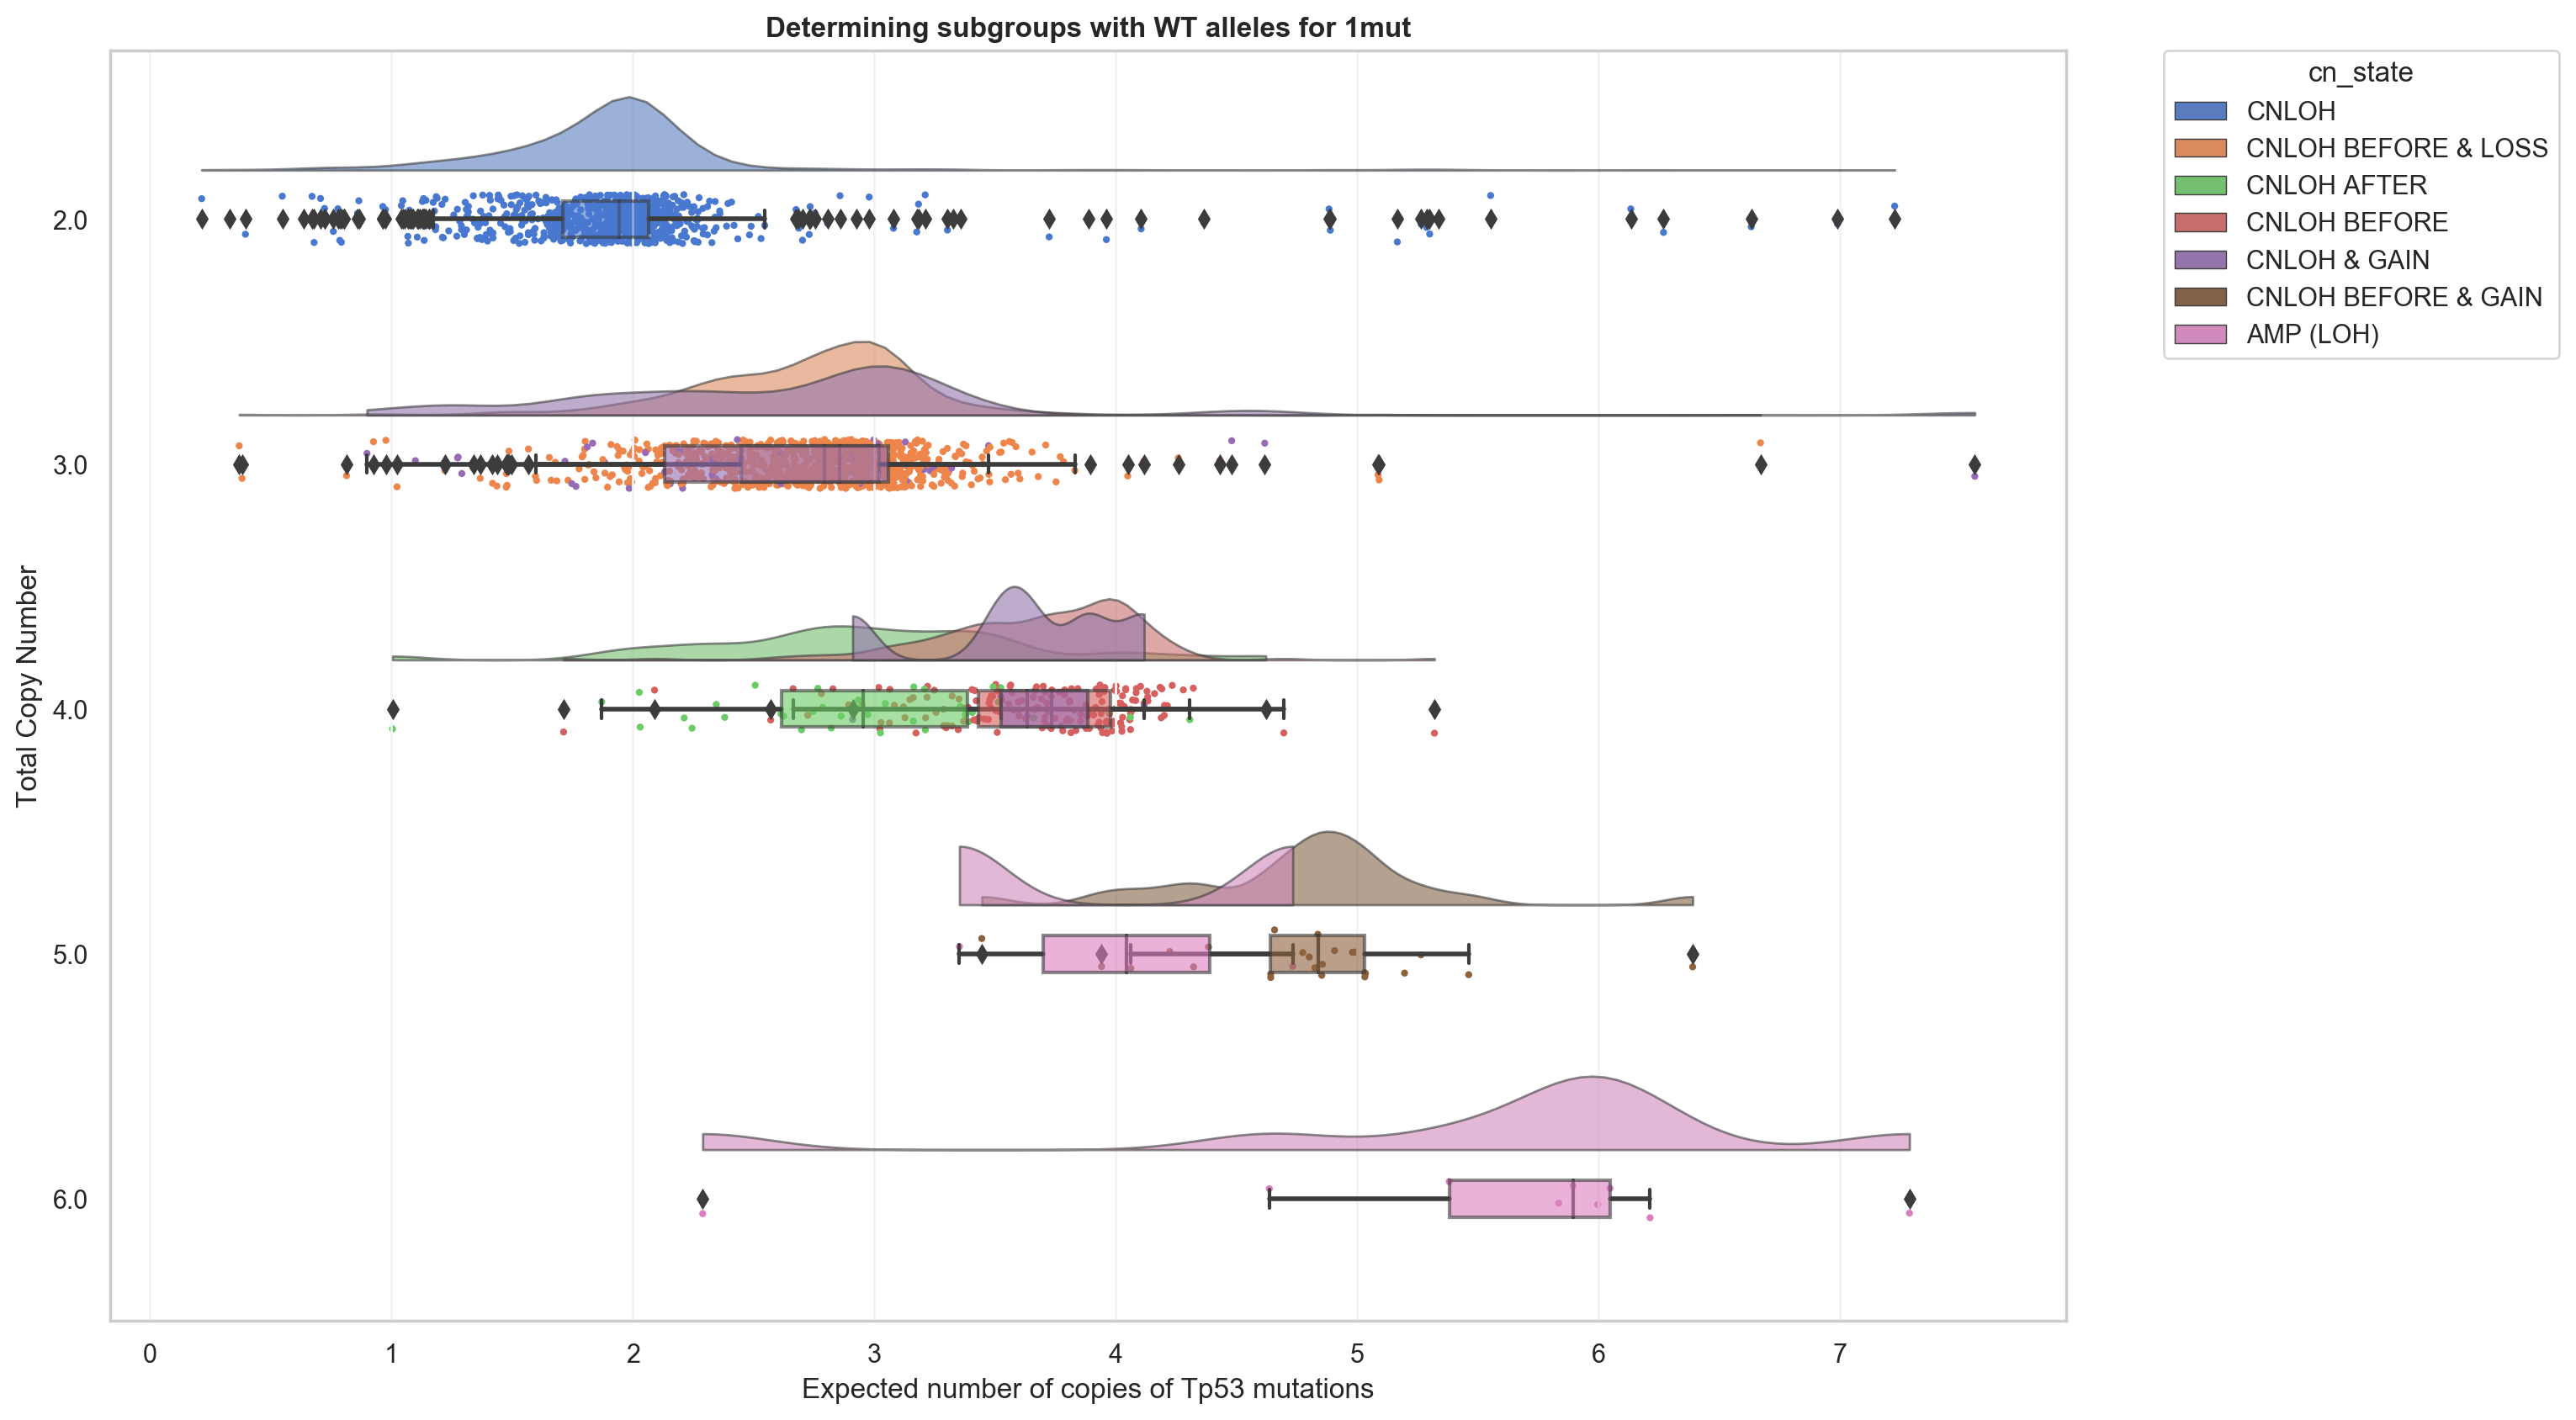

In [95]:
plot_summary(LOH,'LOH_noWT')

count
cn_state          
AMP             12
GAIN            91
LOSS & GAIN     15

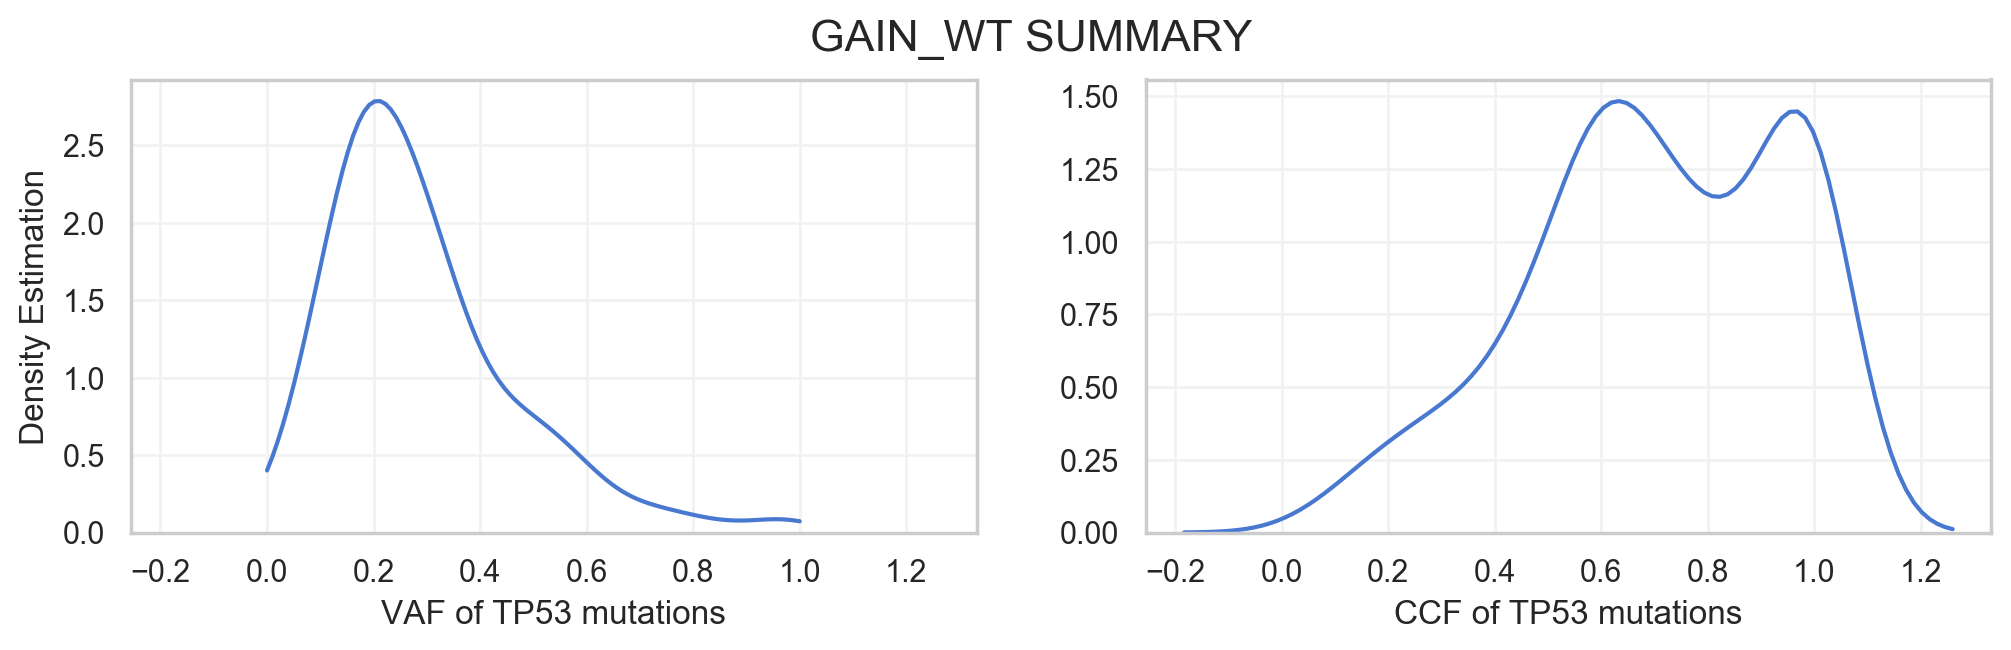

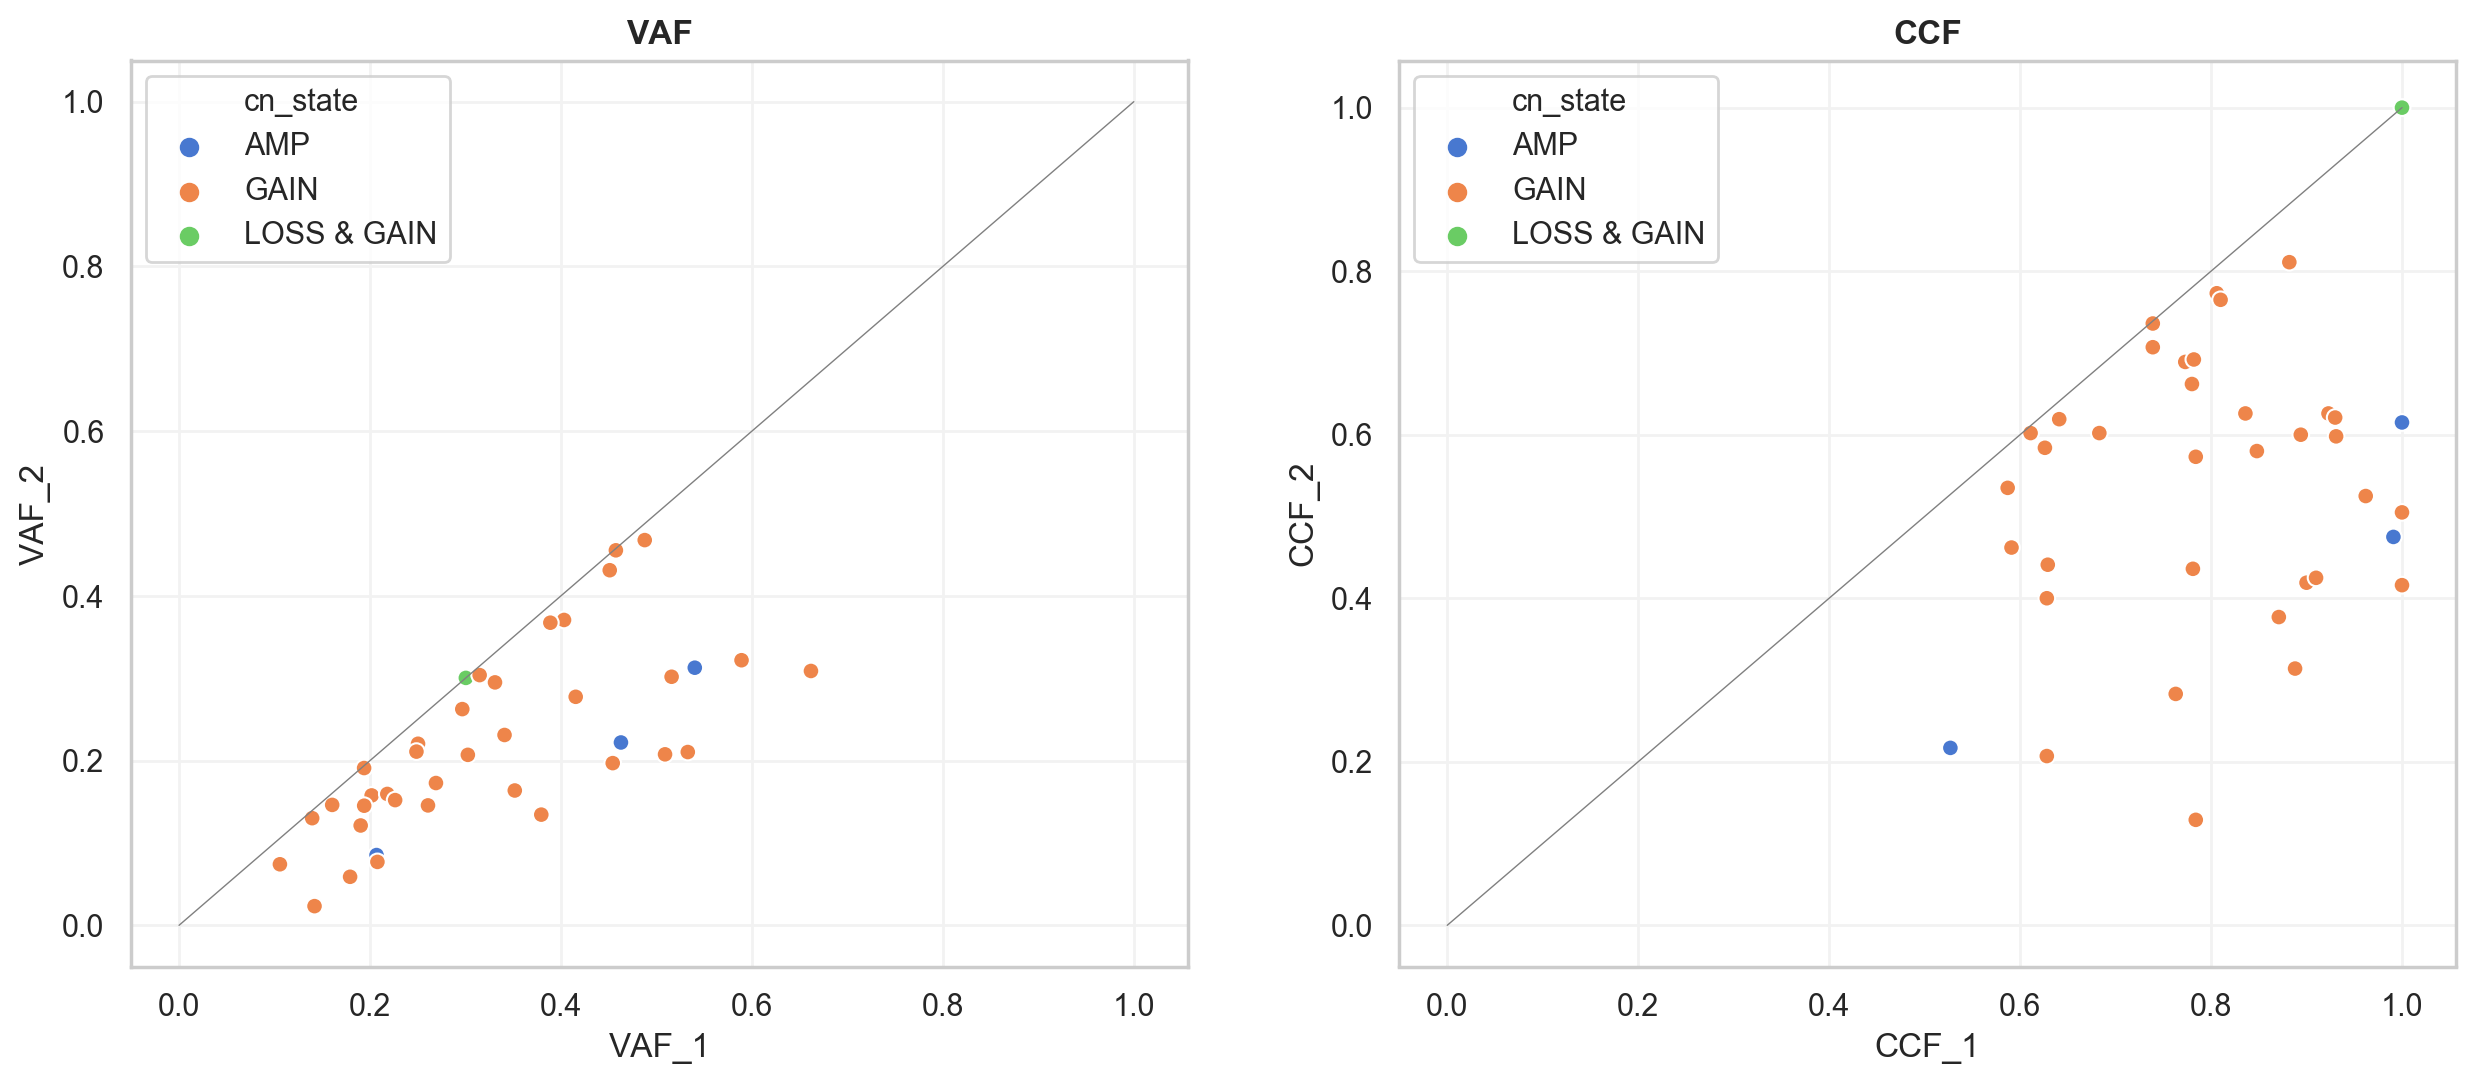

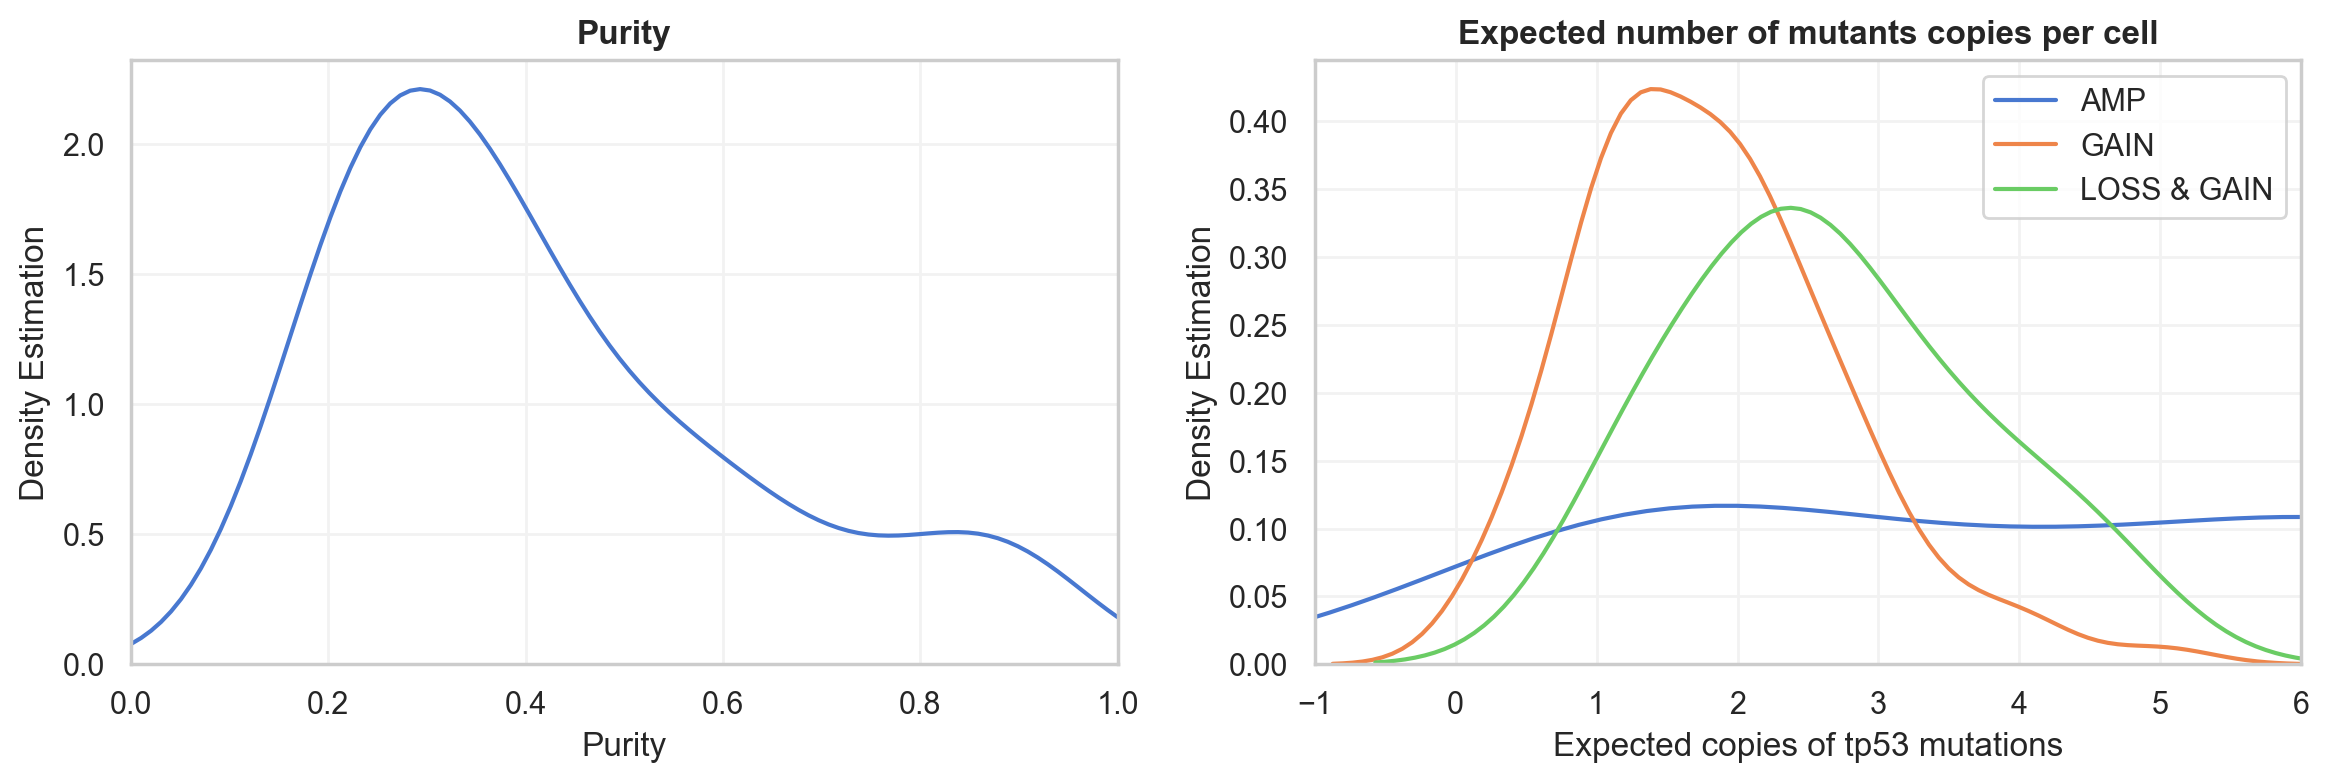

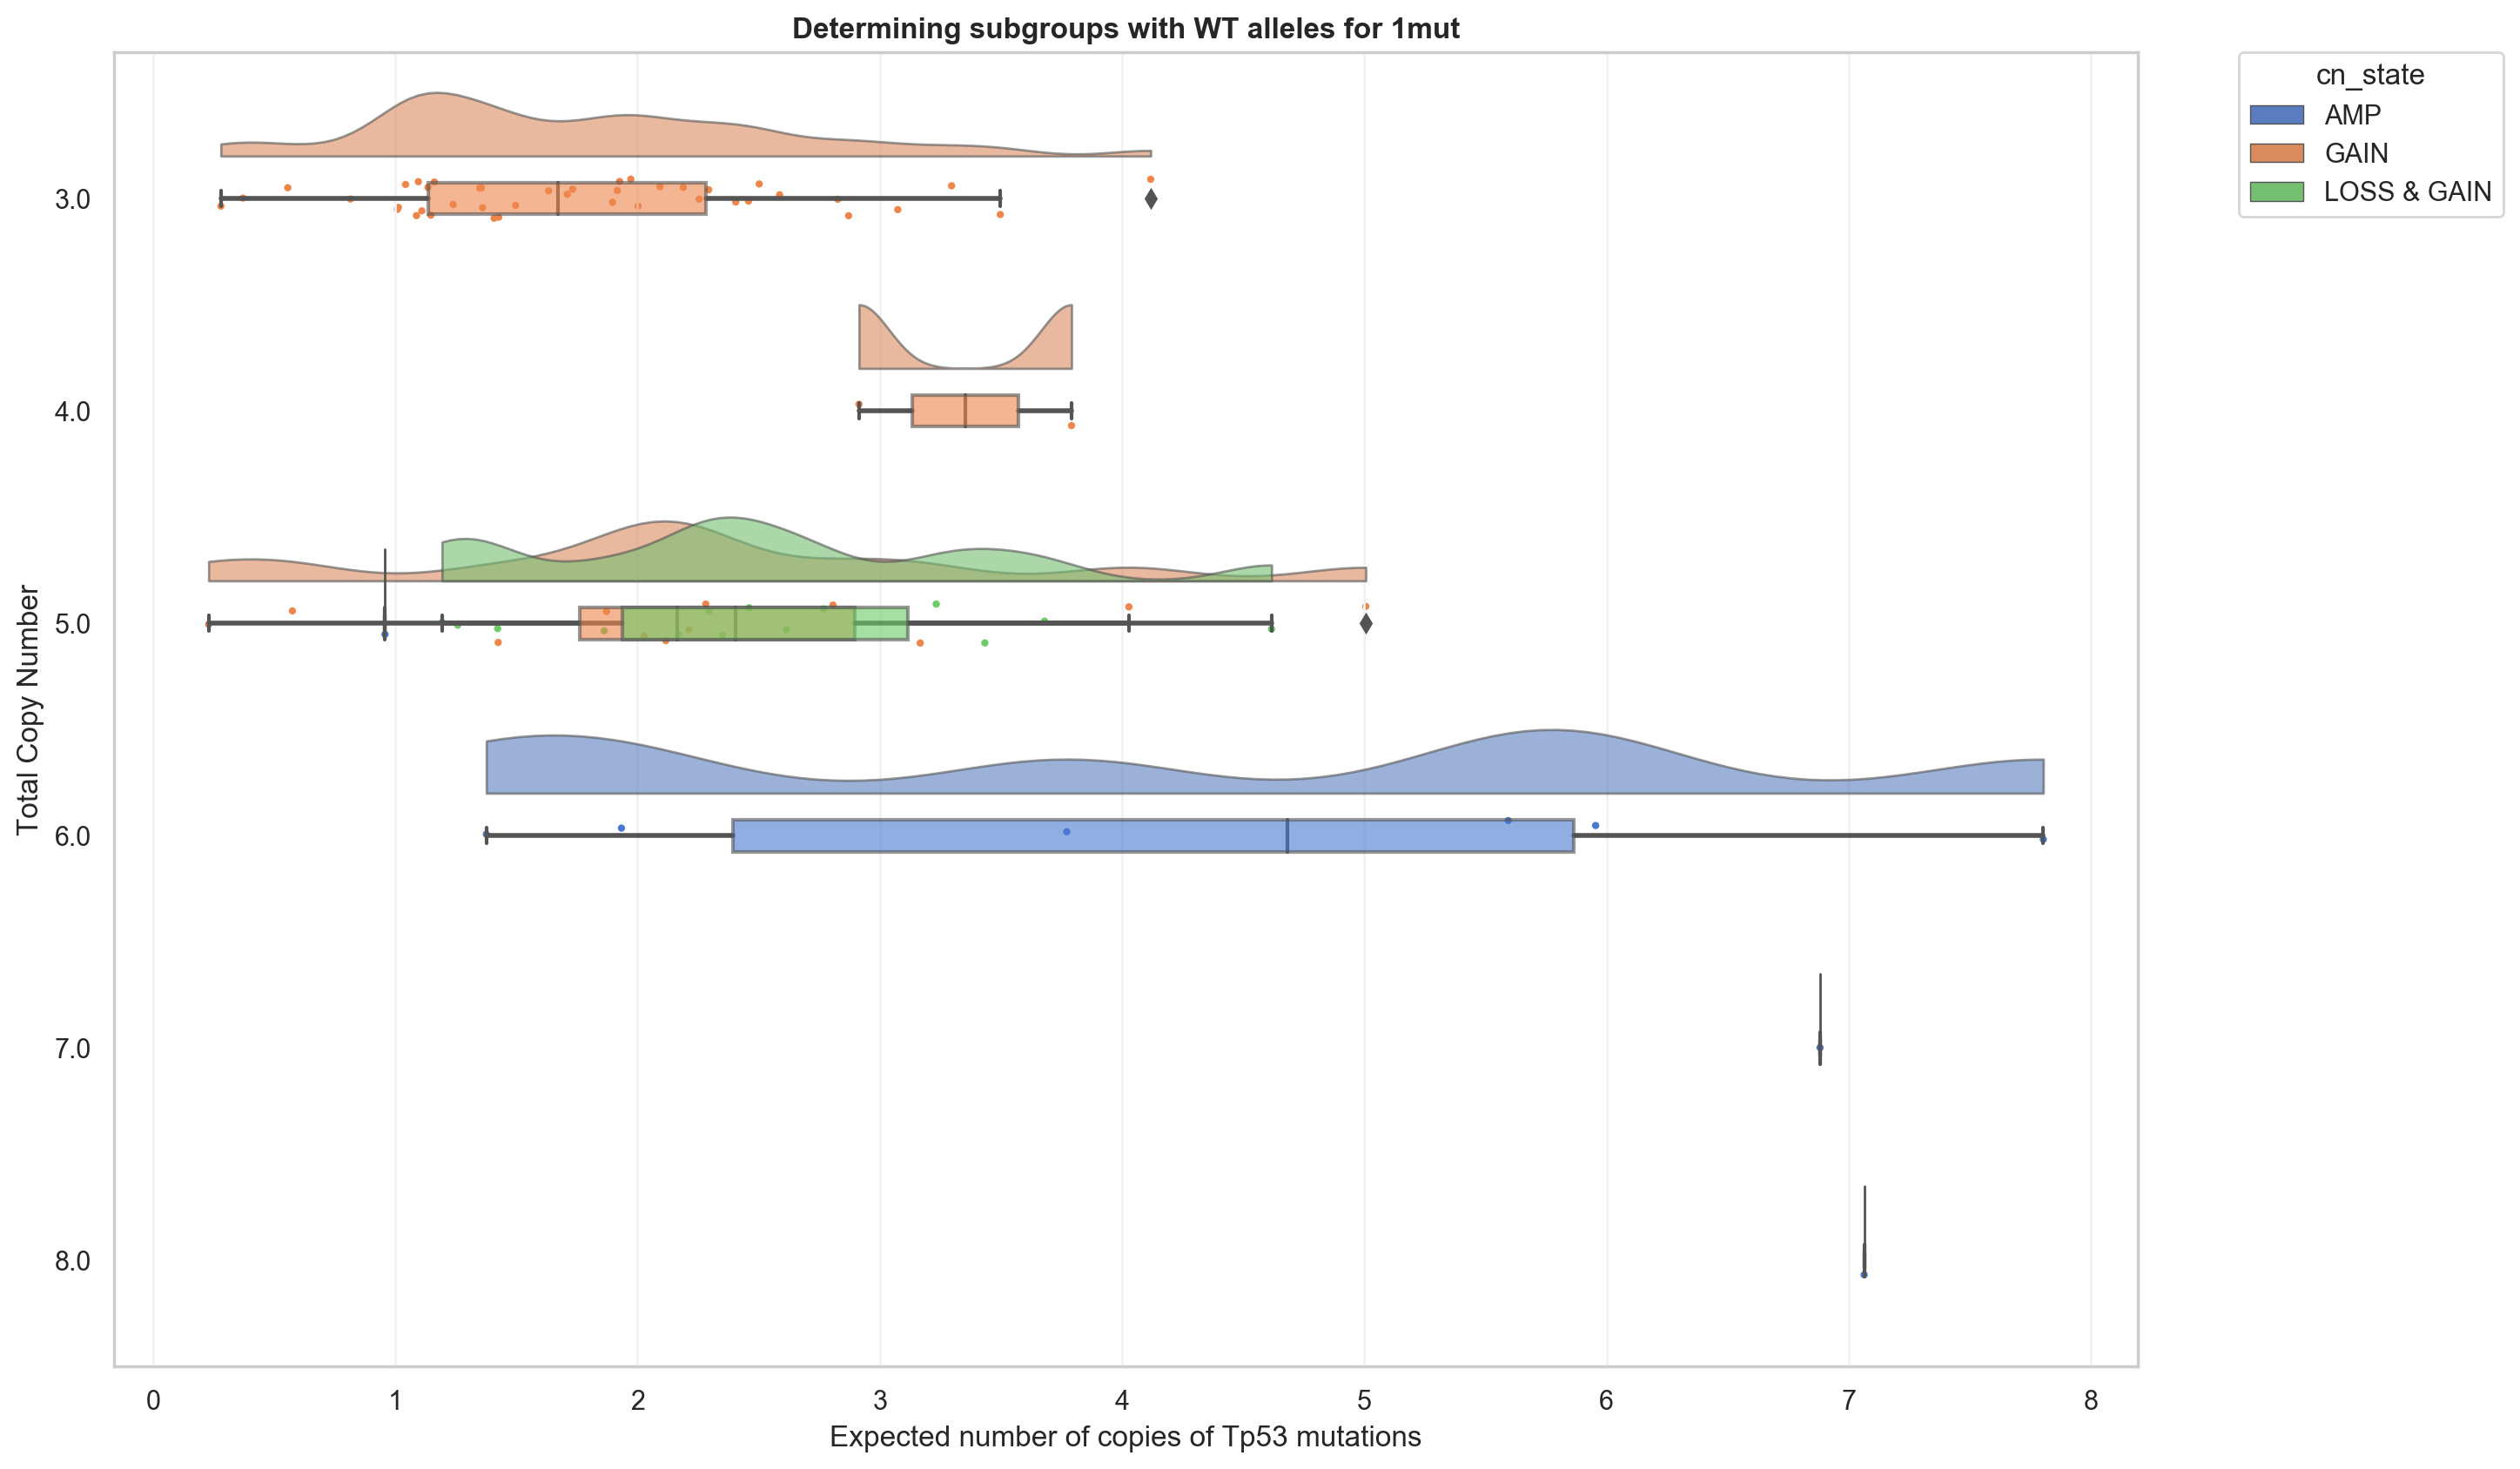

In [96]:
plot_summary(GAIN_WT,'GAIN_WT')

count
cn_state                
CNLOH AFTER           43
DOUBLE LOSS AFTER    149

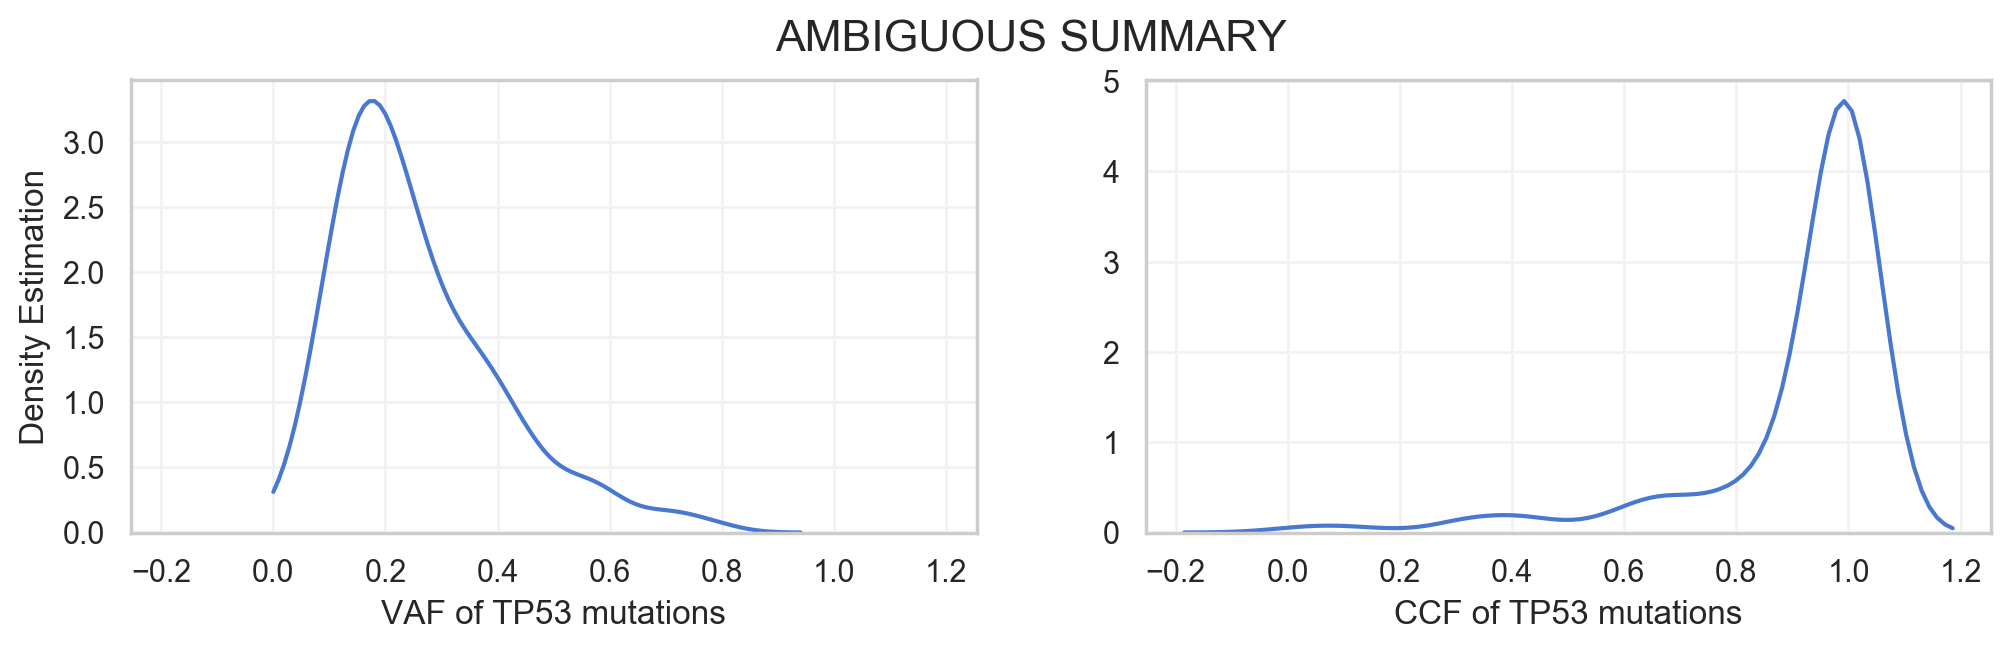

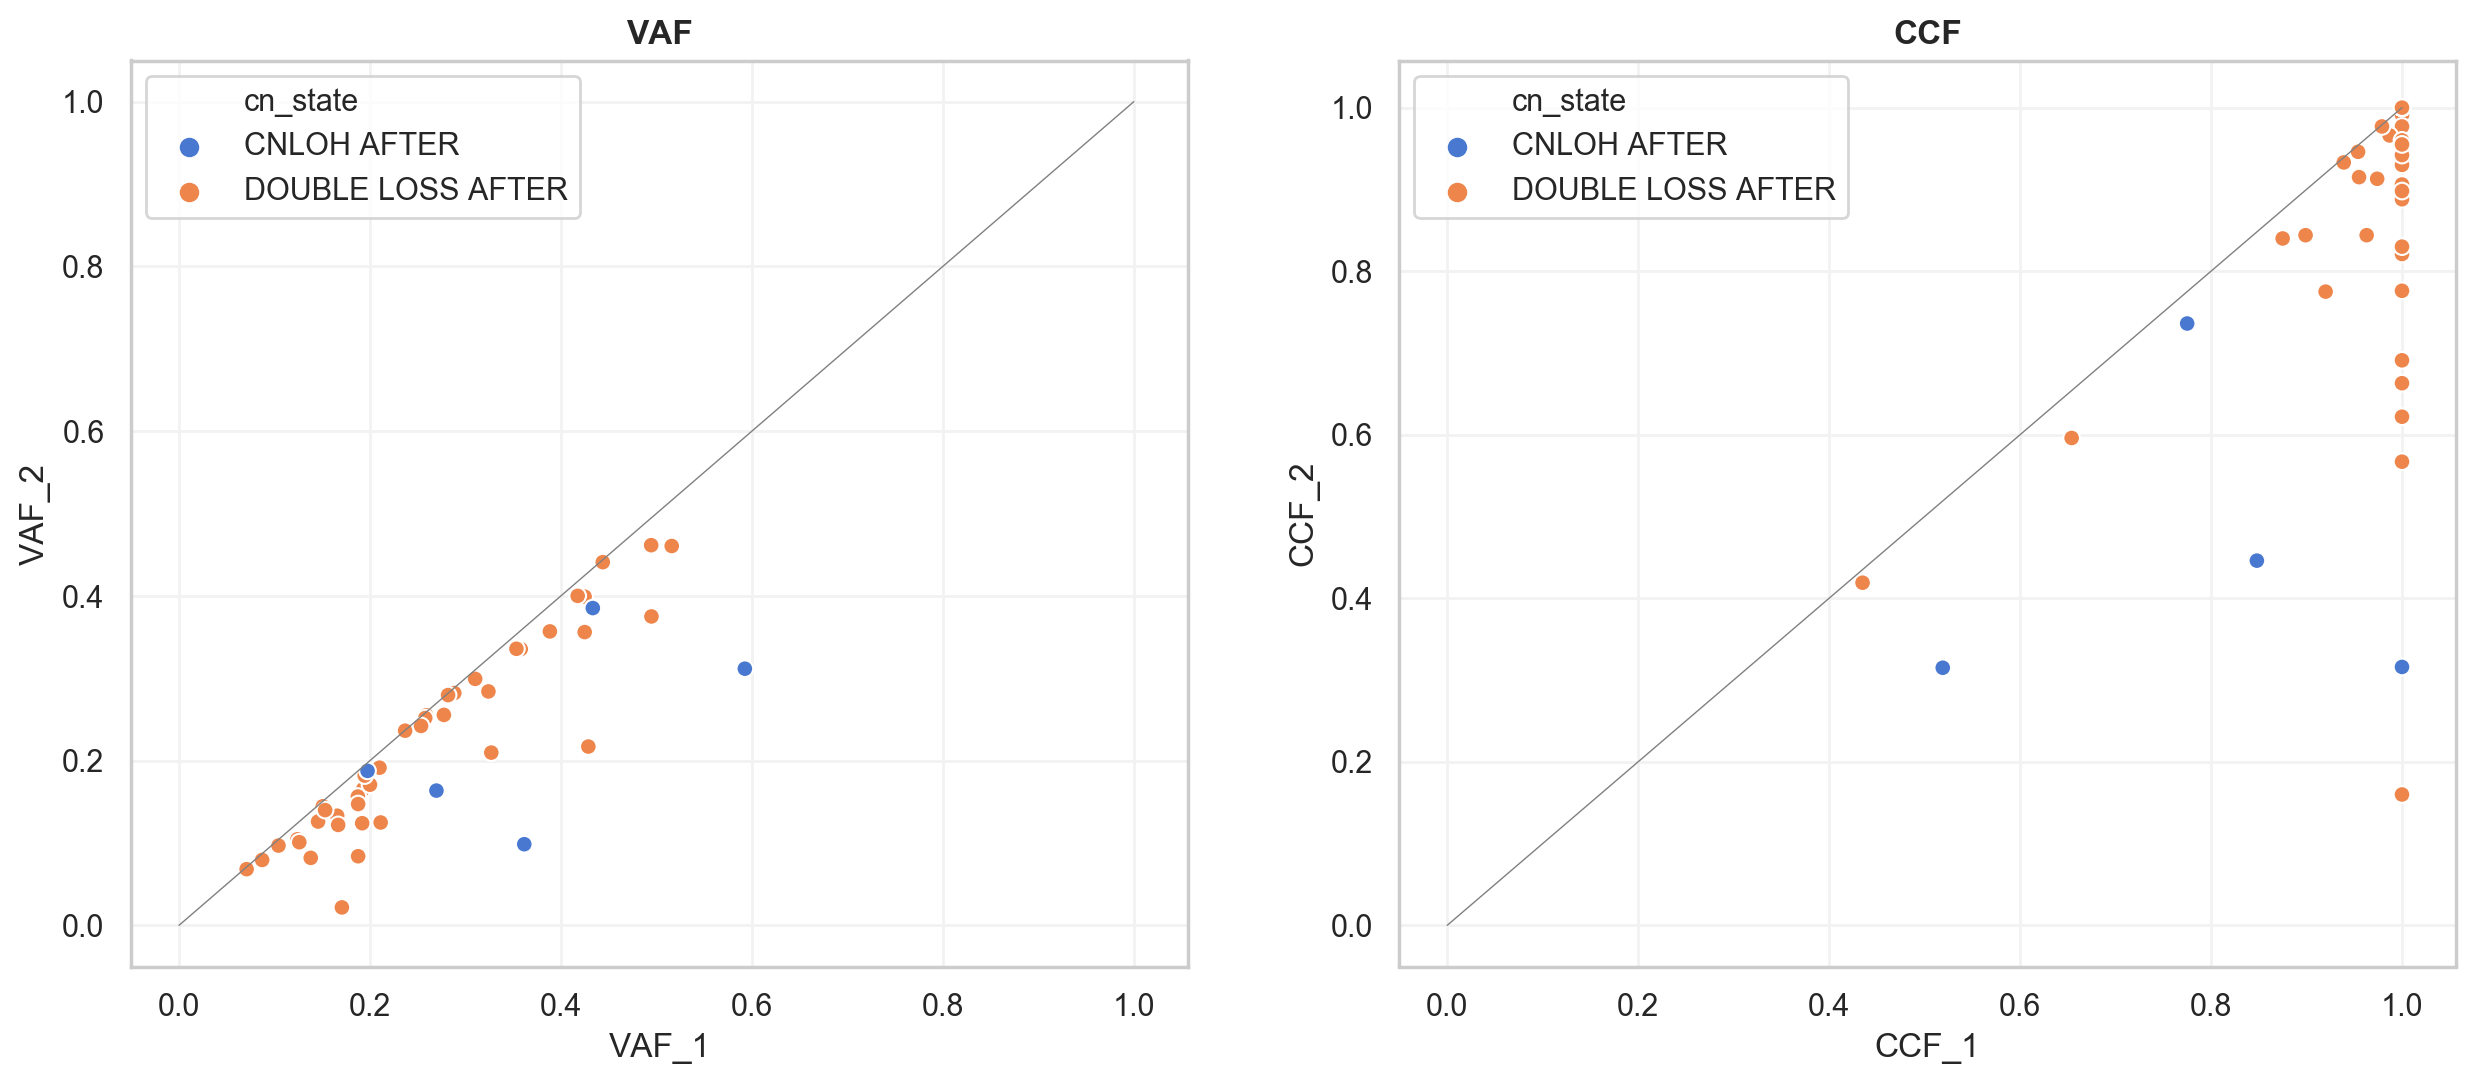

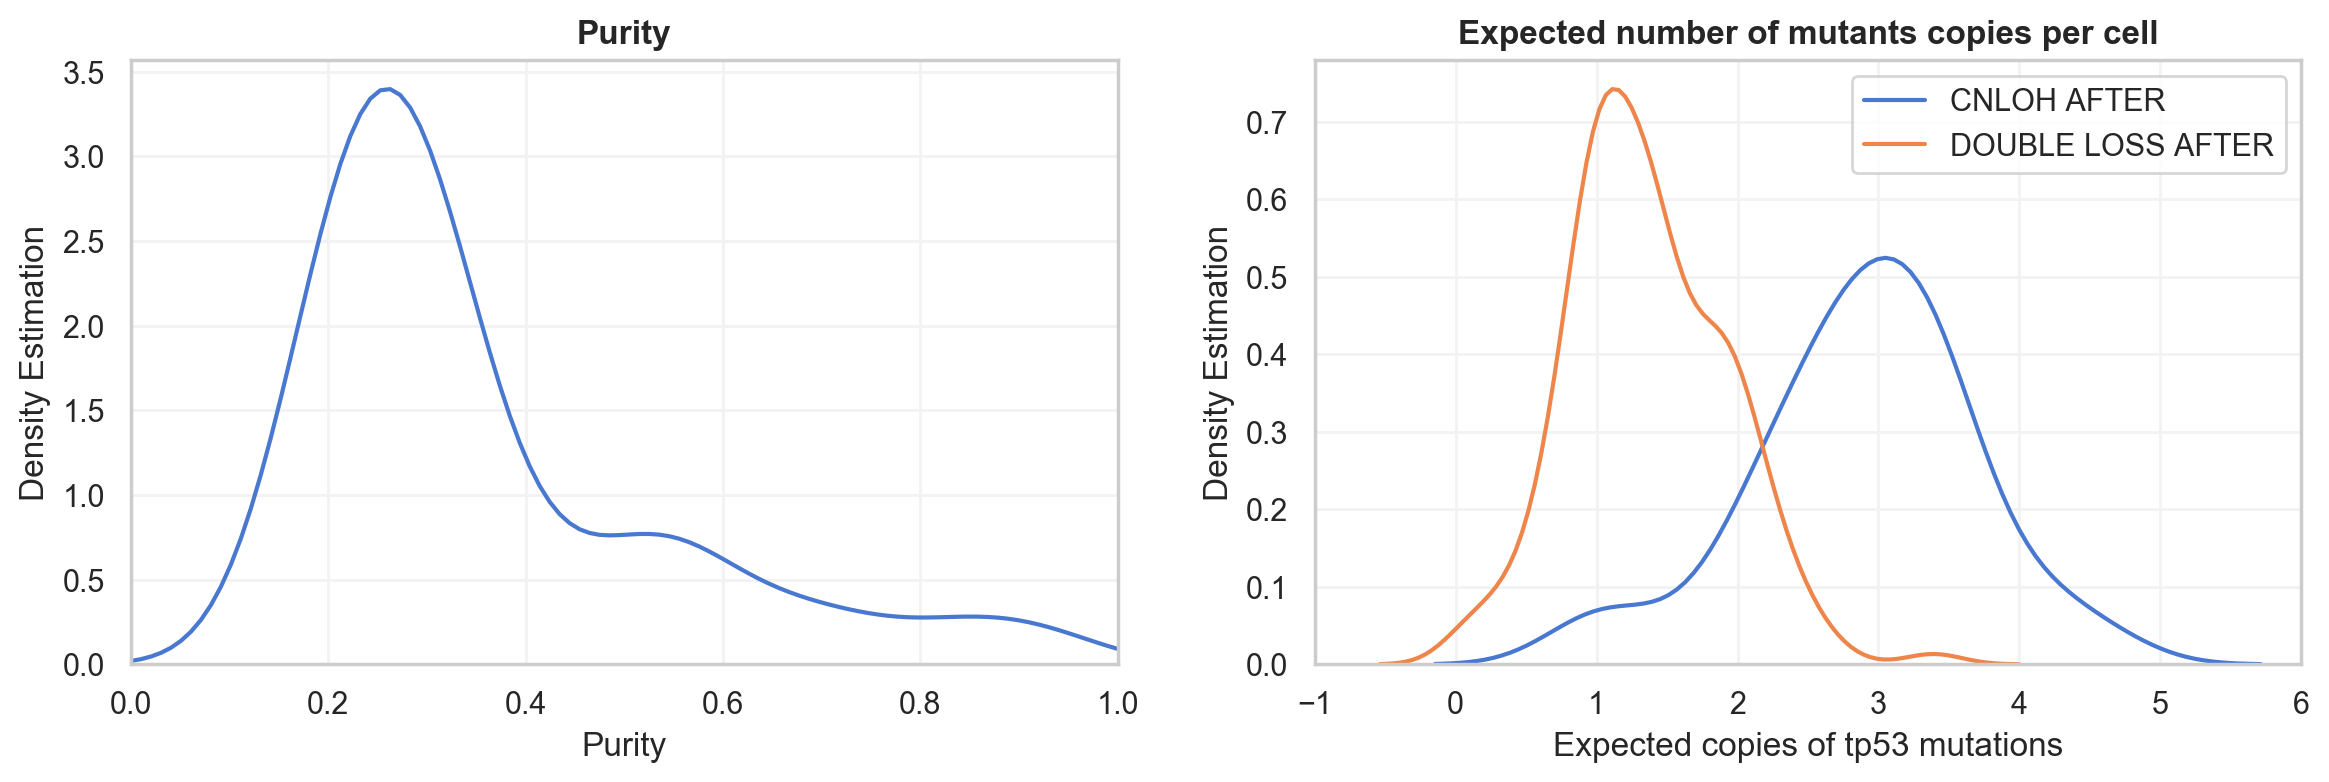

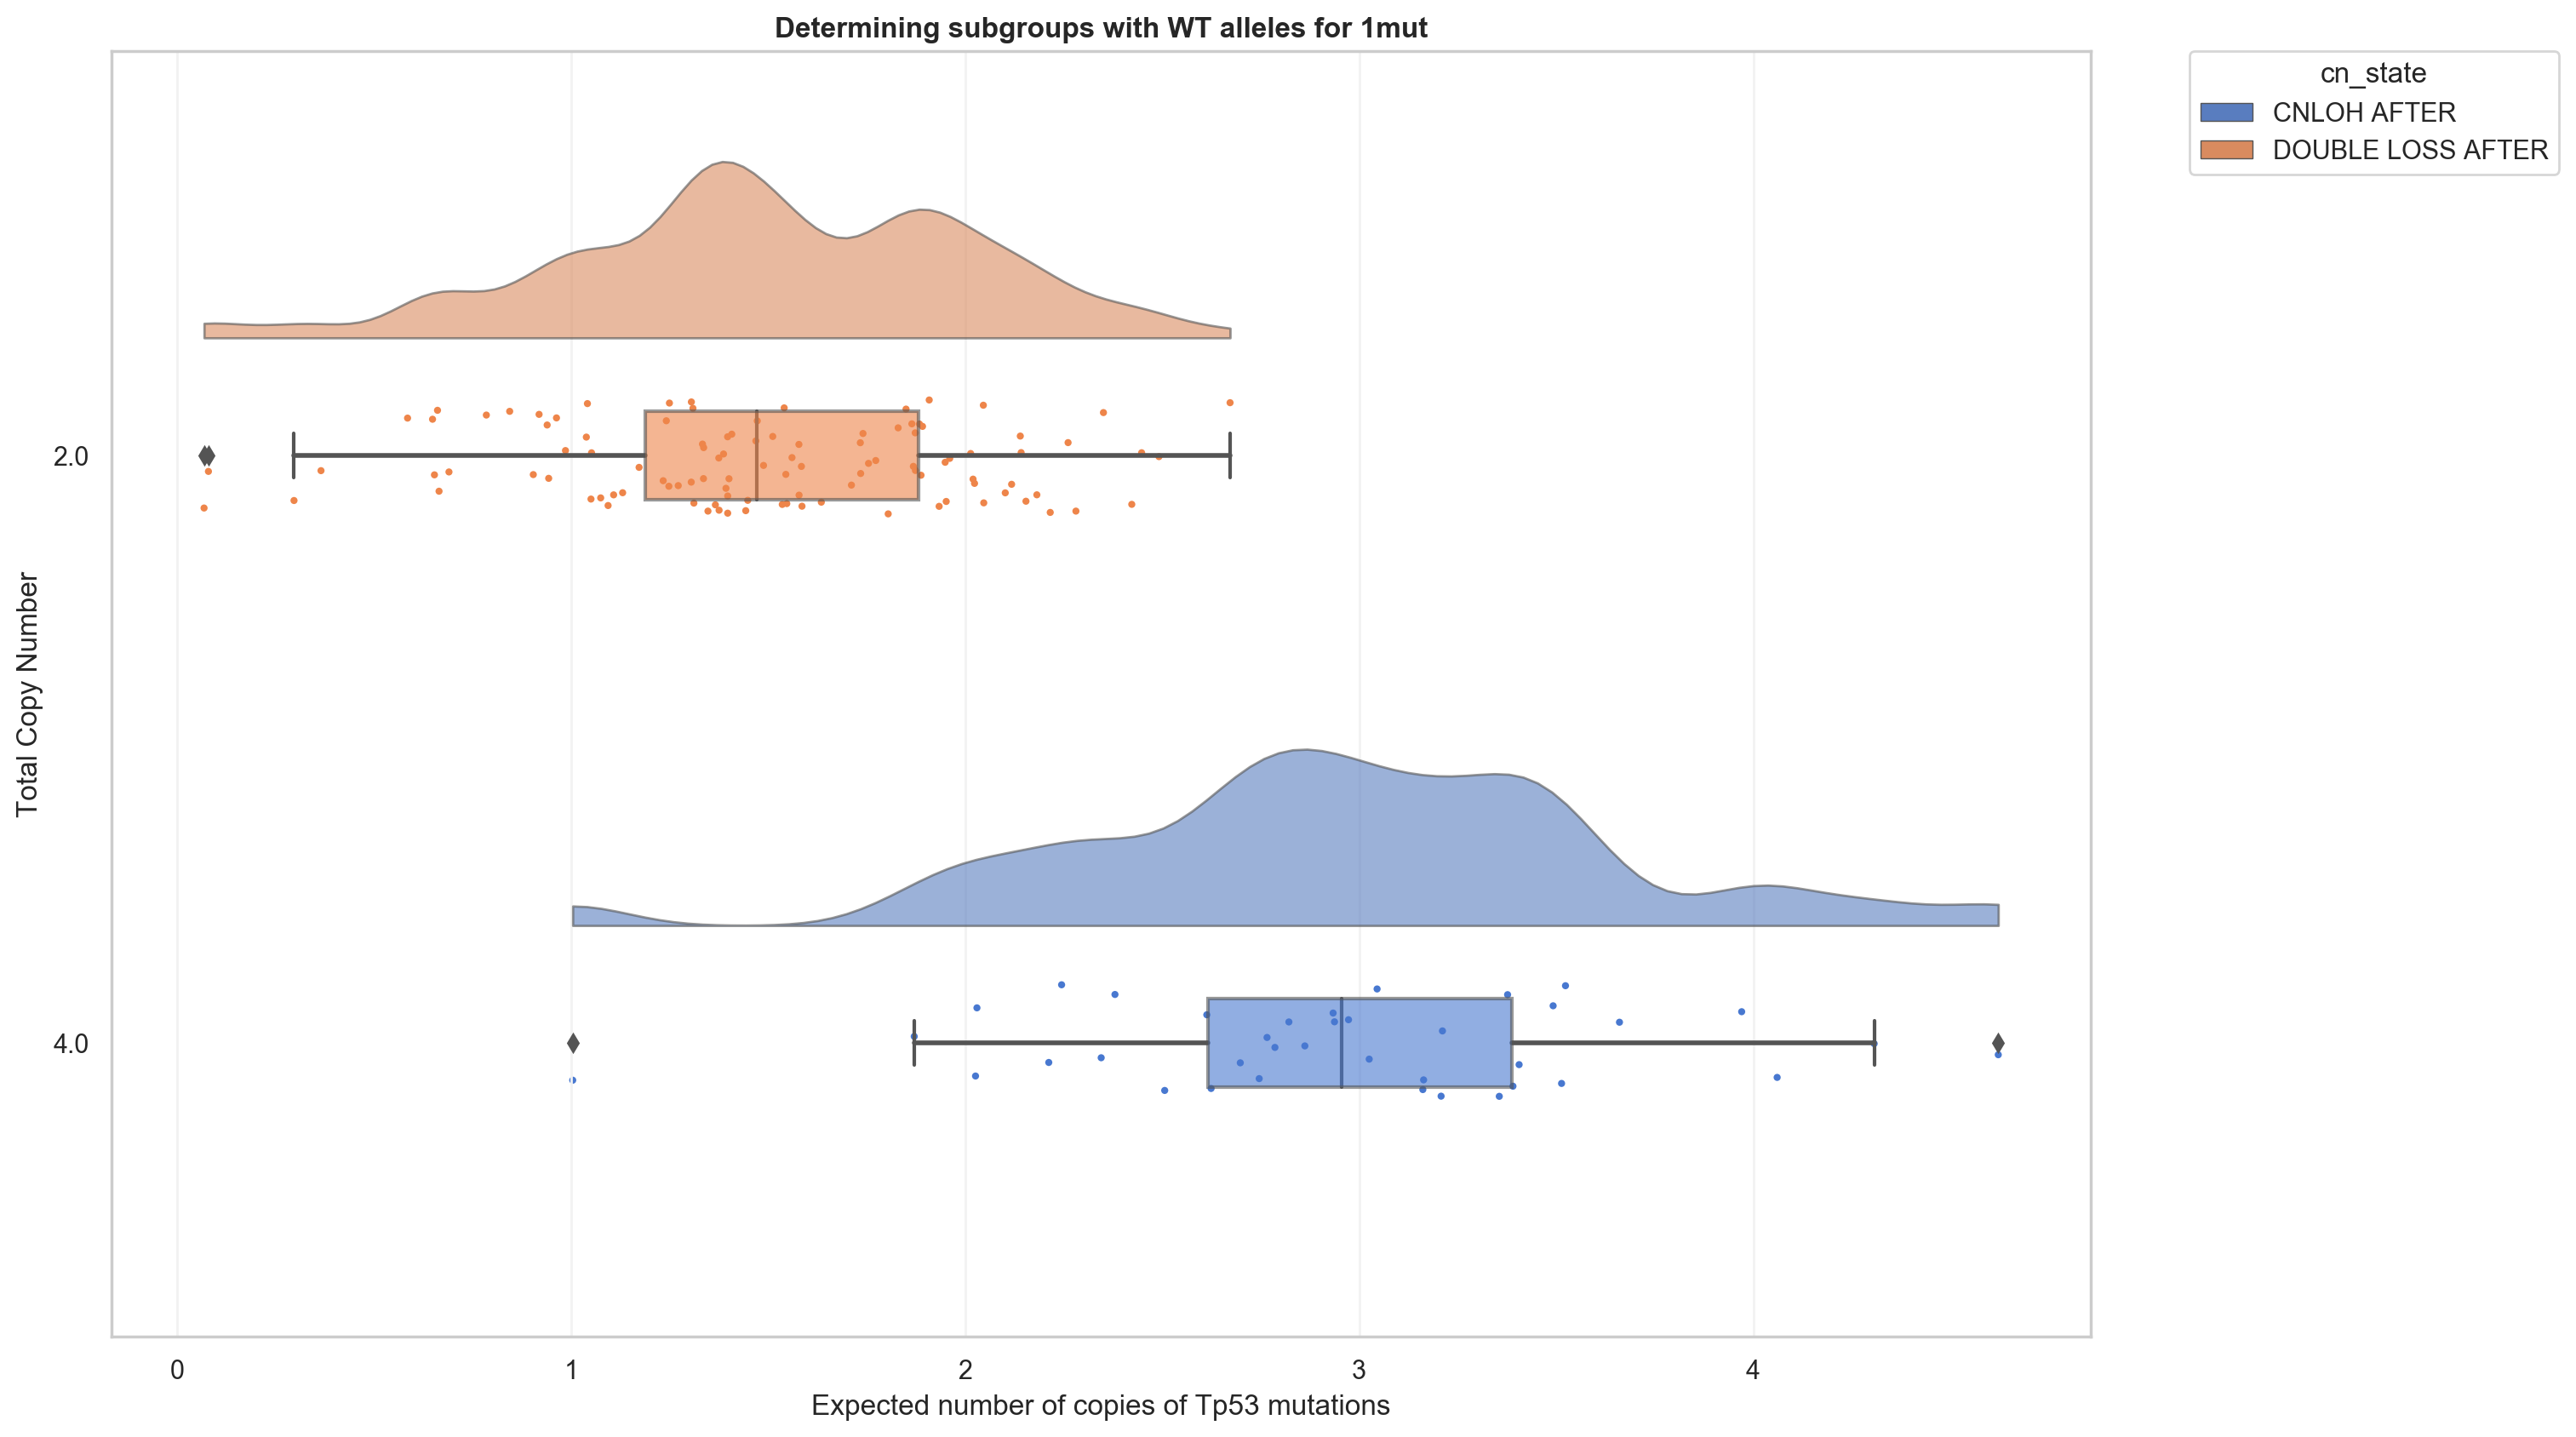

In [97]:
plot_summary(AMBIGUOUS,'AMBIGUOUS')

count
cn_state             
AMP (BALANCED)      4
AMP (LOH)          12
HOMDEL             71

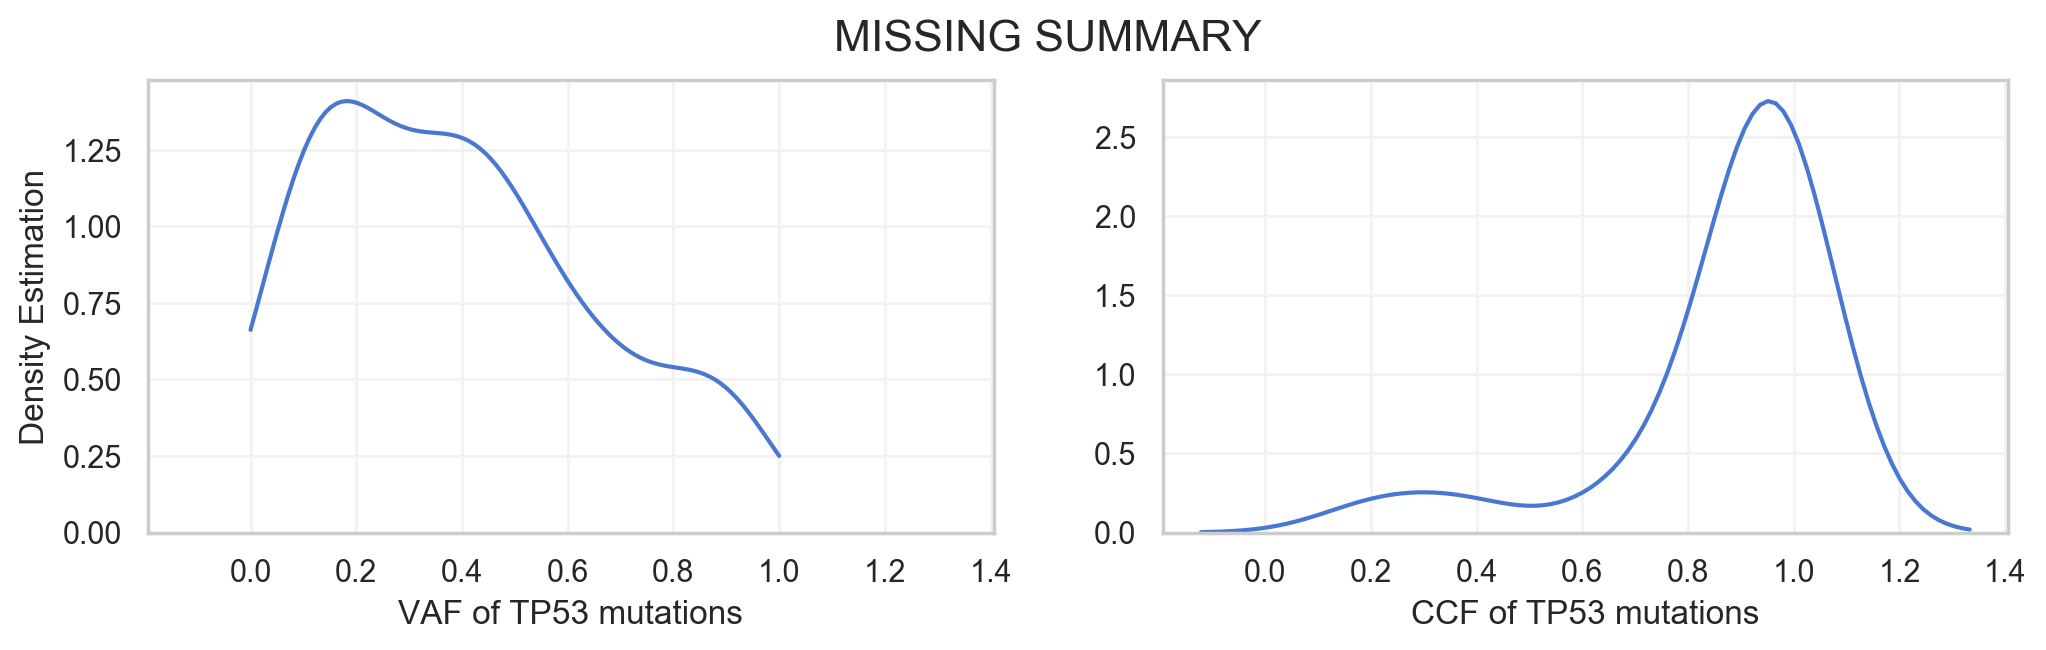

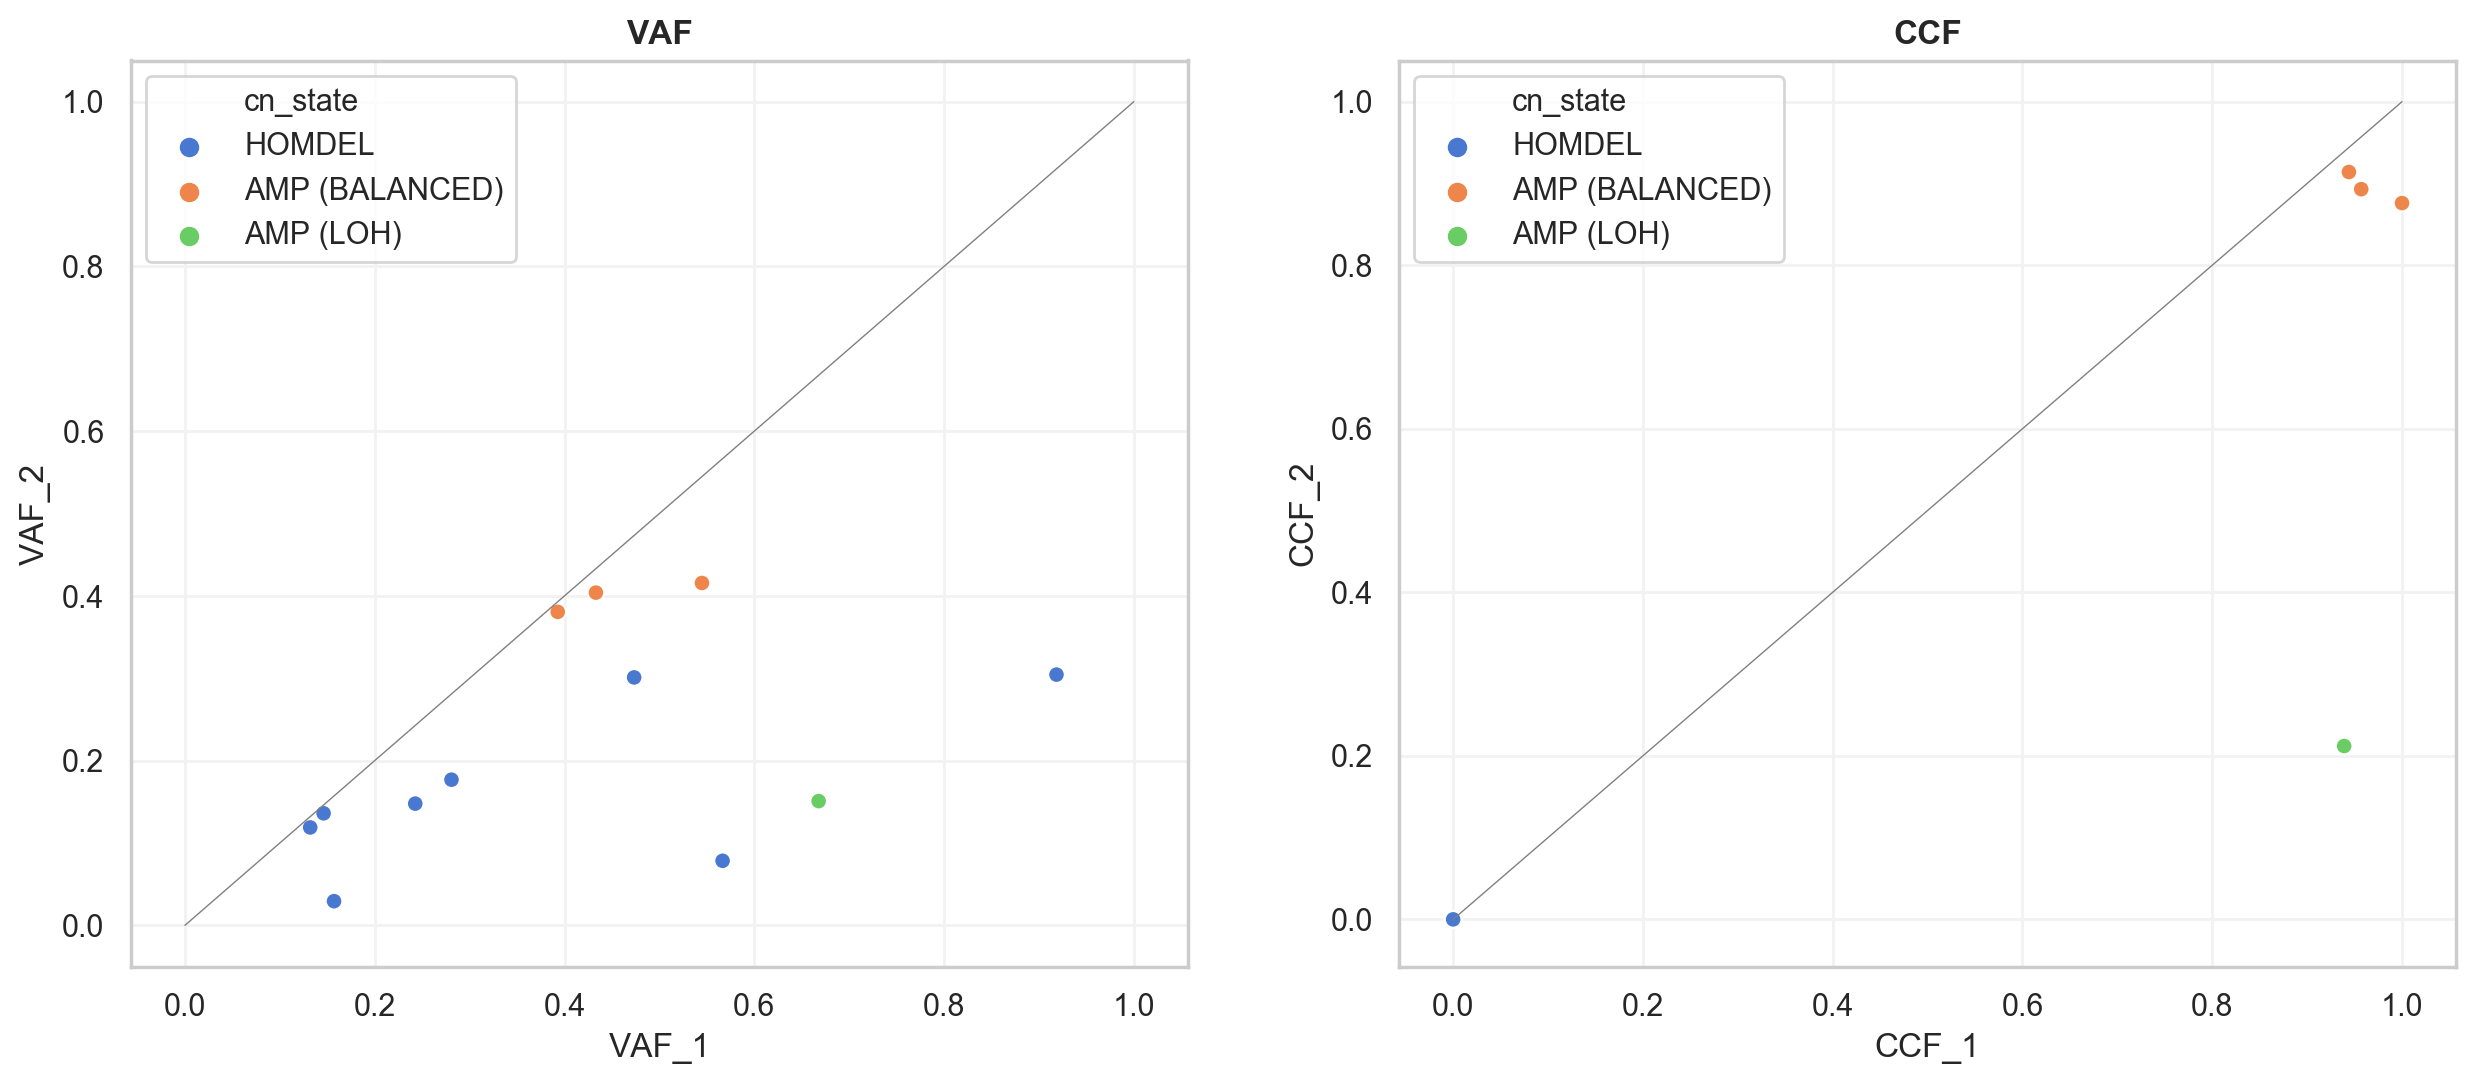

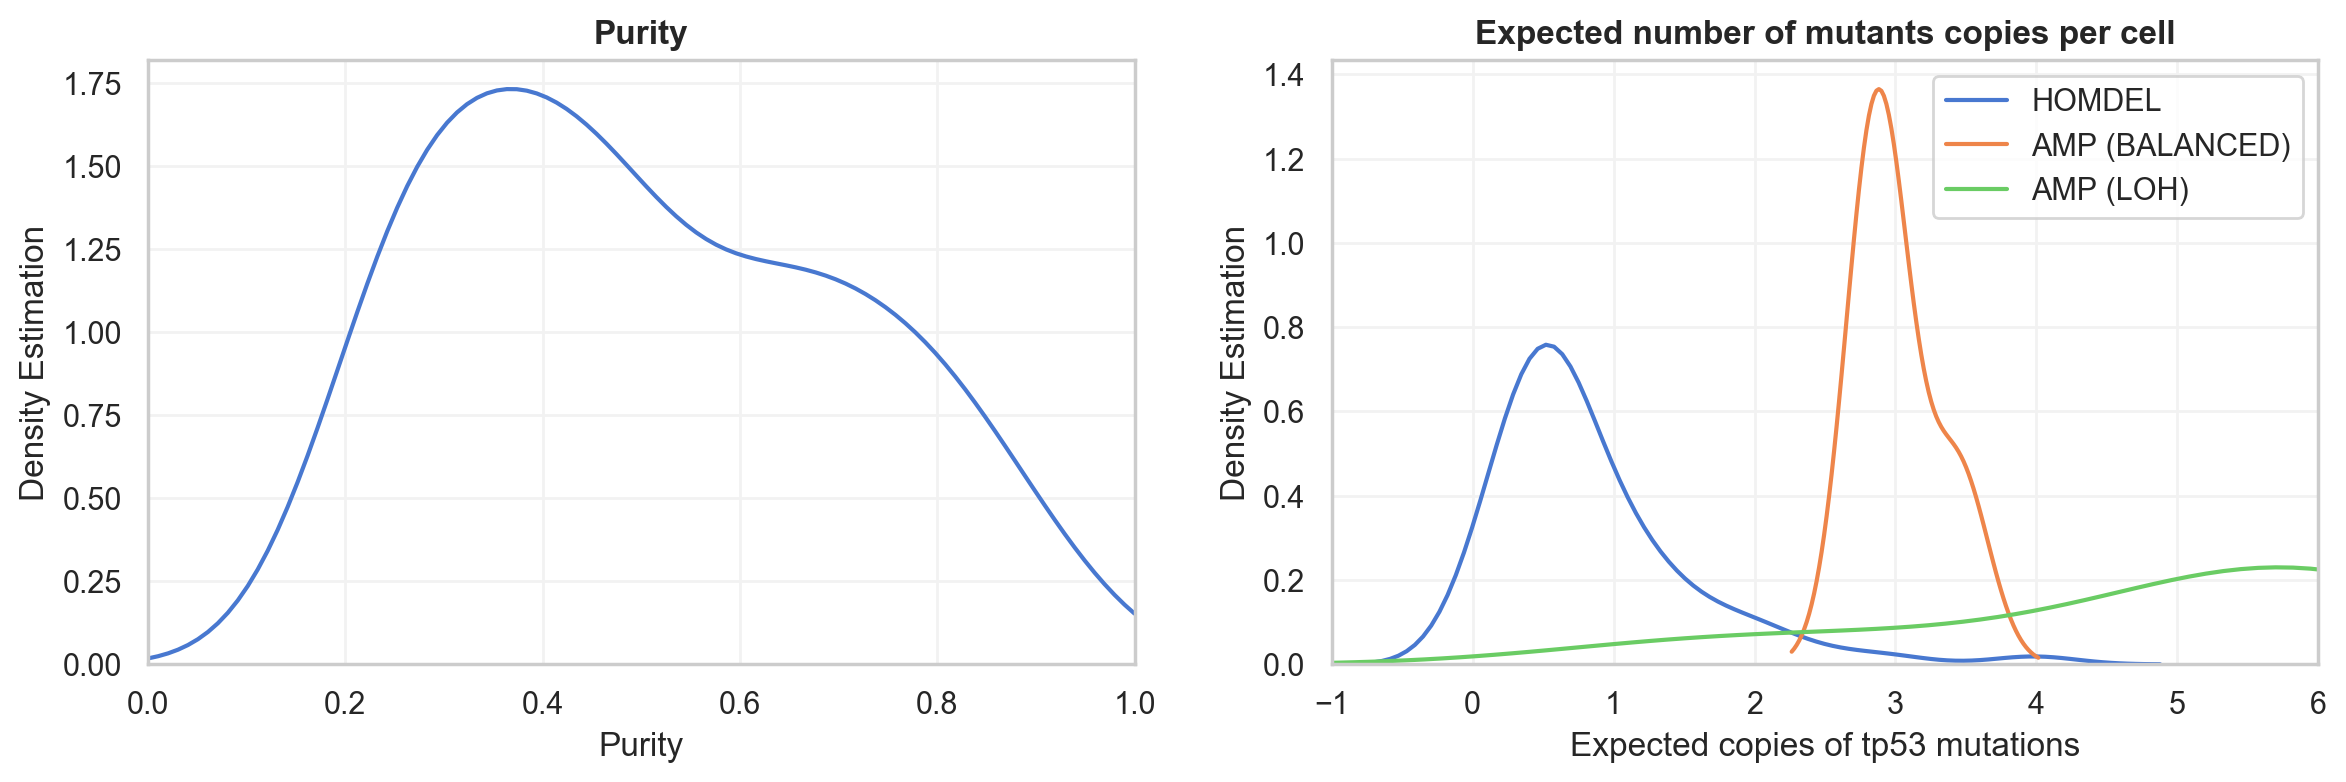

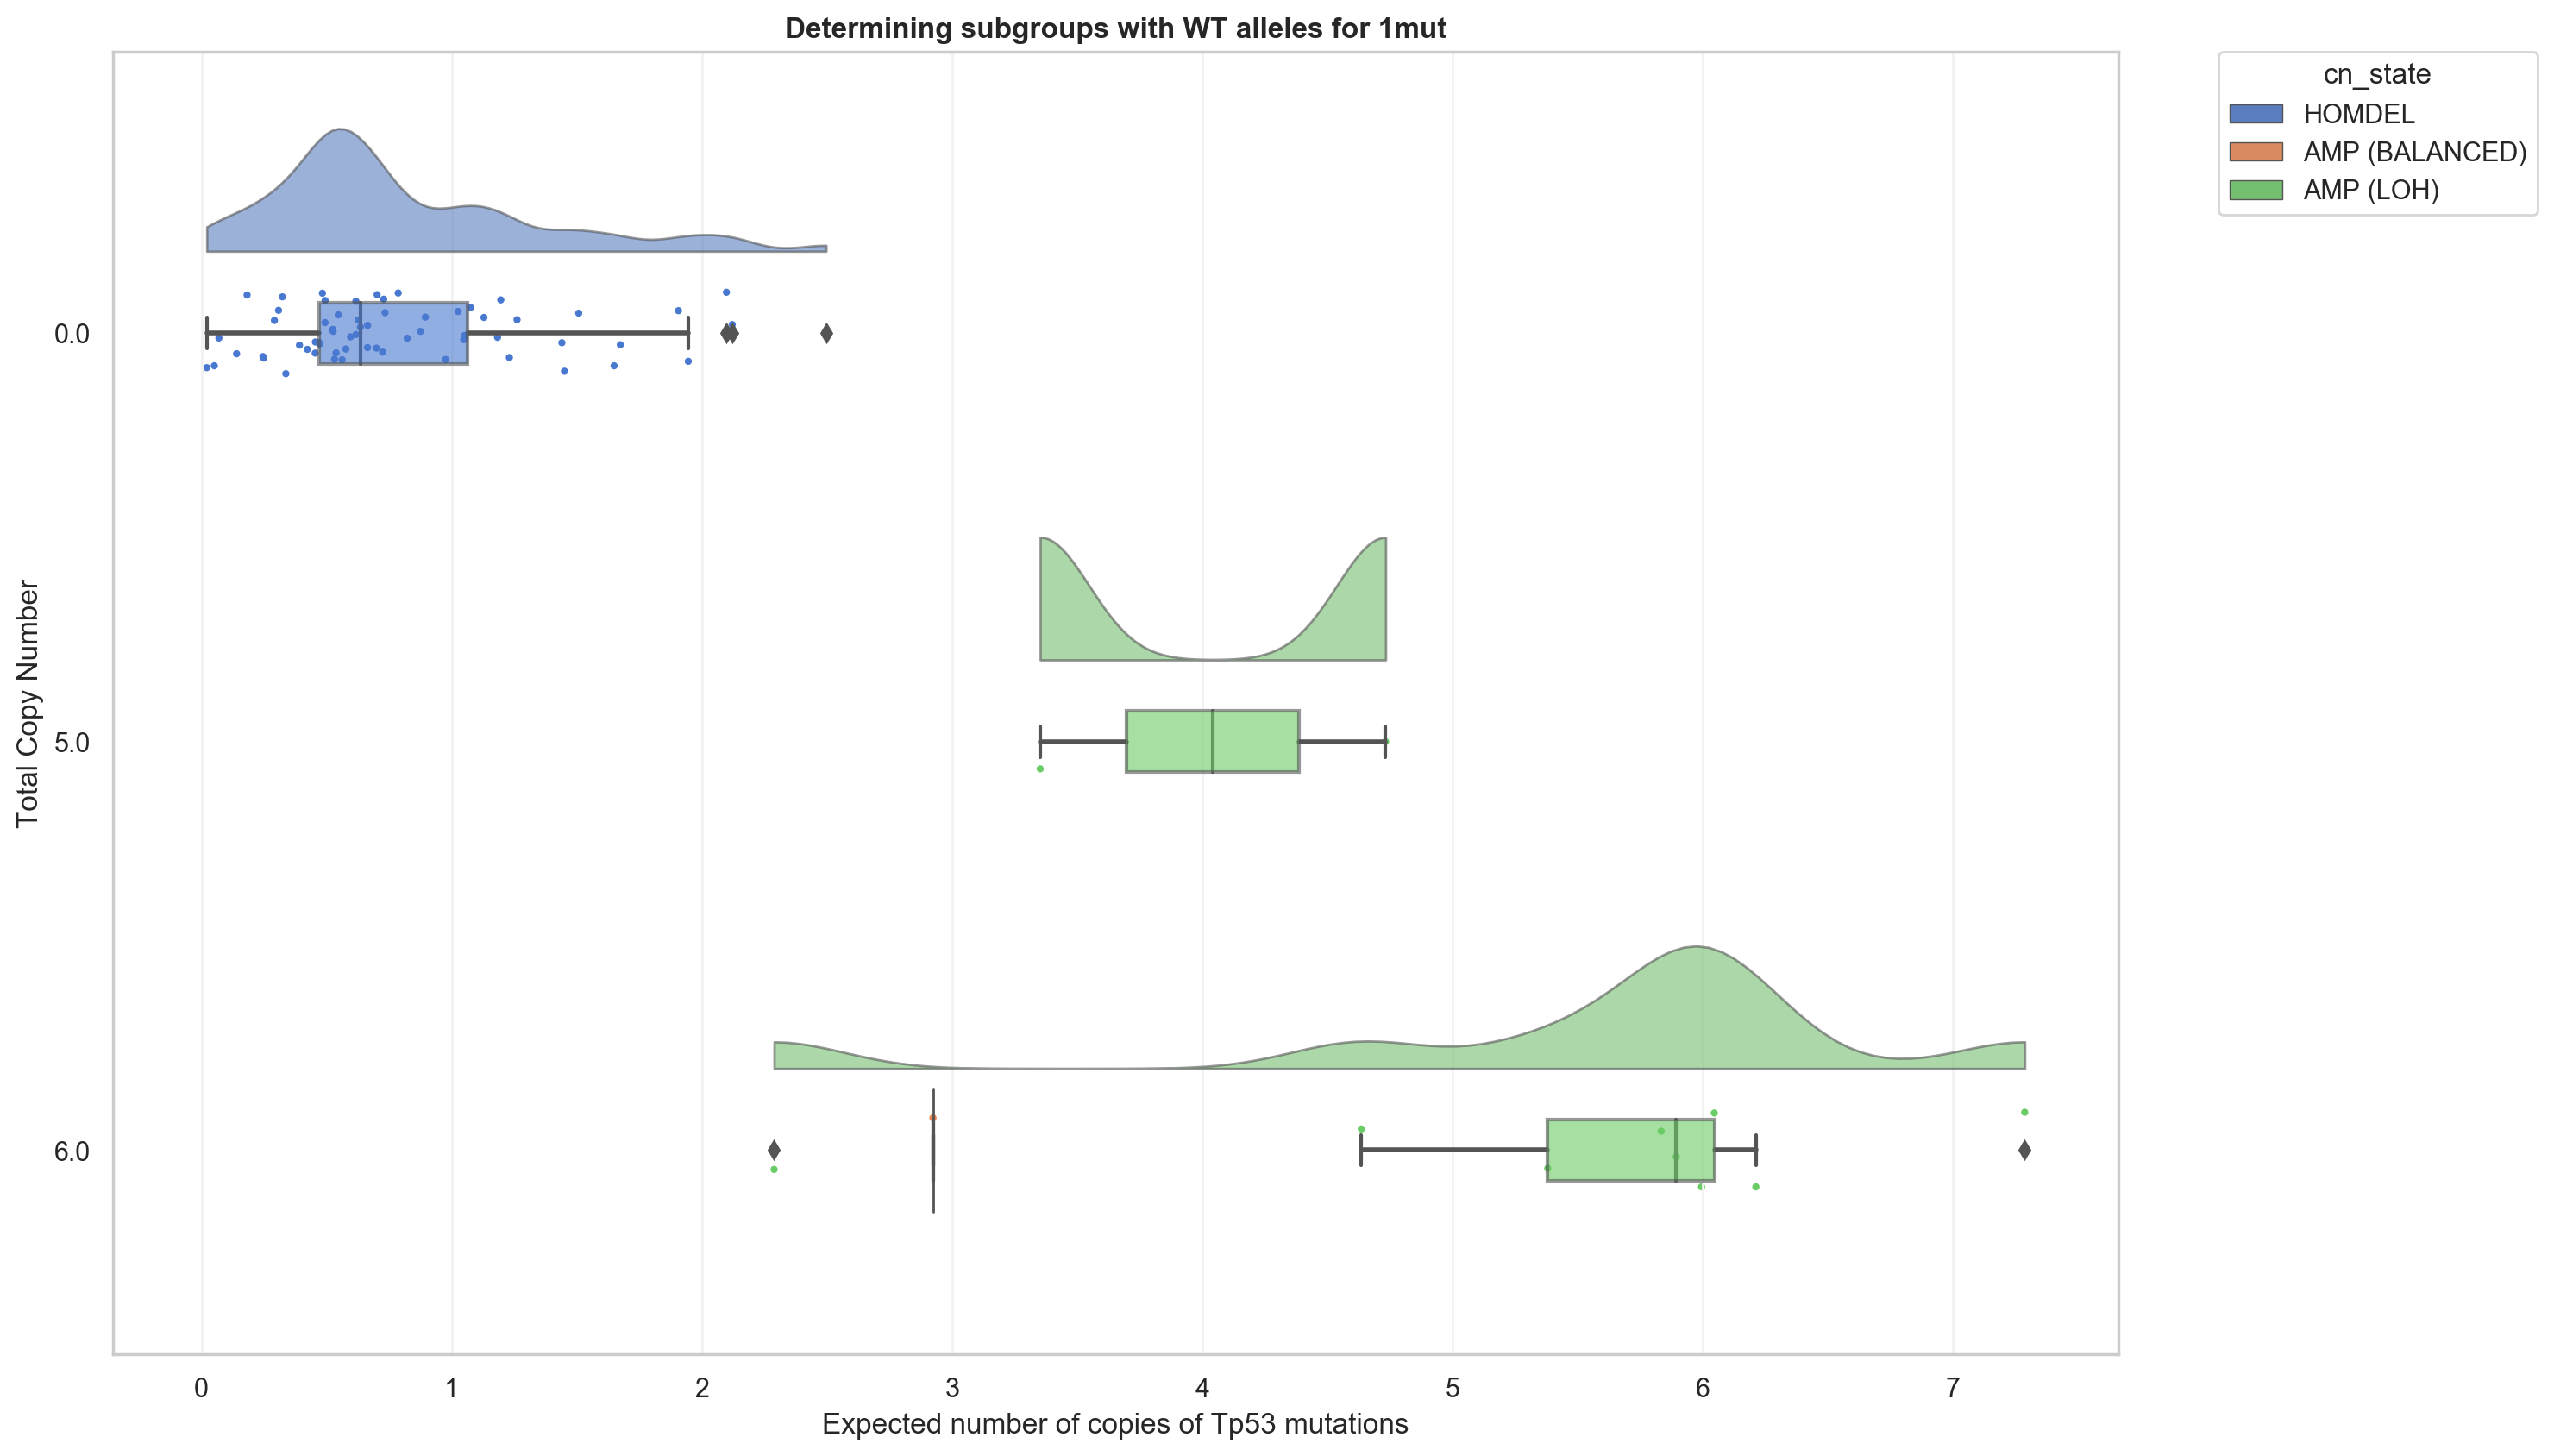

In [98]:
plot_summary(MISSING,'MISSING')

---
## Final Subgroups Analysis

First, we perform a general analysis on the subgroups without entering the metrics of each one. 
The first questions that have arisen are:
* How big are the subgroups?
* What percentage of the tp53 samples do they represent?
* What is the distribution of mutations within eah group?
* What is the distribution of sample types (Metastasis, Primary) within eah group?
* What are the main Cancers represented by group?


---
* **How big are the subgroups?** In comparison with the entire cohort, in comparison with tp53 positive samples

---
* **How big are the subgroups?** 
* **What is the distribution of mutations within eah group?**
* **What is the distribution of sample types (Metastasis, Primary) within eah group?**


In [84]:
mut_tp53_count = pd.DataFrame(master[['mut_cn_group', 'Cancer_Type']].groupby(['mut_cn_group', 'Cancer_Type'], sort = True).size())
mut_tp53_count.columns = ['count']

mut_tp53_count = mut_tp53_count['count'].groupby(level=0, group_keys=False)
res = mut_tp53_count.apply(lambda x: x.sort_values(ascending=False).head(3))
display(res)




mut_cn_group  Cancer_Type               
0_HETLOSS     Breast Cancer                  864
              Non-Small Cell Lung Cancer     347
              Prostate Cancer                254
1_WILD_TYPE   Non-Small Cell Lung Cancer     322
              Colorectal Cancer              198
              Pancreatic Cancer              142
>1muts        Colorectal Cancer              116
              Non-Small Cell Lung Cancer     110
              Glioma                         101
>=1_LOSS      Colorectal Cancer             1361
              Non-Small Cell Lung Cancer    1158
              Breast Cancer                 1005
>=1_cnLOH     Non-Small Cell Lung Cancer     348
              Colorectal Cancer              281
              Breast Cancer                  237
HOMDEL        Soft Tissue Sarcoma             47
              Breast Cancer                   41
              Prostate Cancer                 34
Name: count, dtype: int64

count 
 
 
 mut_cn_group 
 tp53_count 
 
 
 
 
 
 0_HETLOSS 
 0 
 2833 
 
 
 1_WILD_TYPE 
 1 
 1457 
 
 
 >1muts 
 2 
 616 
 
 
 3 
 68 
 
 
 4 
 10 
 
 
 5 
 3 
 
 
 >=1_LOSS 
 1 
 6904 
 
 
 2 
 161 
 
 
 3 
 19 
 
 
 4 
 3 
 
 
 >=1_cnLOH 
 1 
 1850 
 
 
 2 
 39 
 
 
 3 
 6 
 
 
 HOMDEL 
 0 
 224 
 
 
 1 
 63 
 
 
 2 
 8 
 
 
 4 
 1 
 
 
 
 
 
 
 
 count 
 
 
 mut_cn_group 
 Sample_Type 
 
 
 
 
 
 0_HETLOSS 
 Metastasis 
 1260 
 
 
 Primary 
 1556 
 
 
 1_WILD_TYPE 
 Metastasis 
 494 
 
 
 Primary 
 963 
 
 
 >1muts 
 Metastasis 
 232 
 
 
 Primary 
 465 
 
 
 >=1_LOSS 
 Metastasis 
 3271 
 
 
 Primary 
 3816 
 
 
 >=1_cnLOH 
 Metastasis 
 821 
 
 
 Primary 
 1074 
 
 
 HOMDEL 
 Metastasis 
 116 
 
 
 Primary 
 179

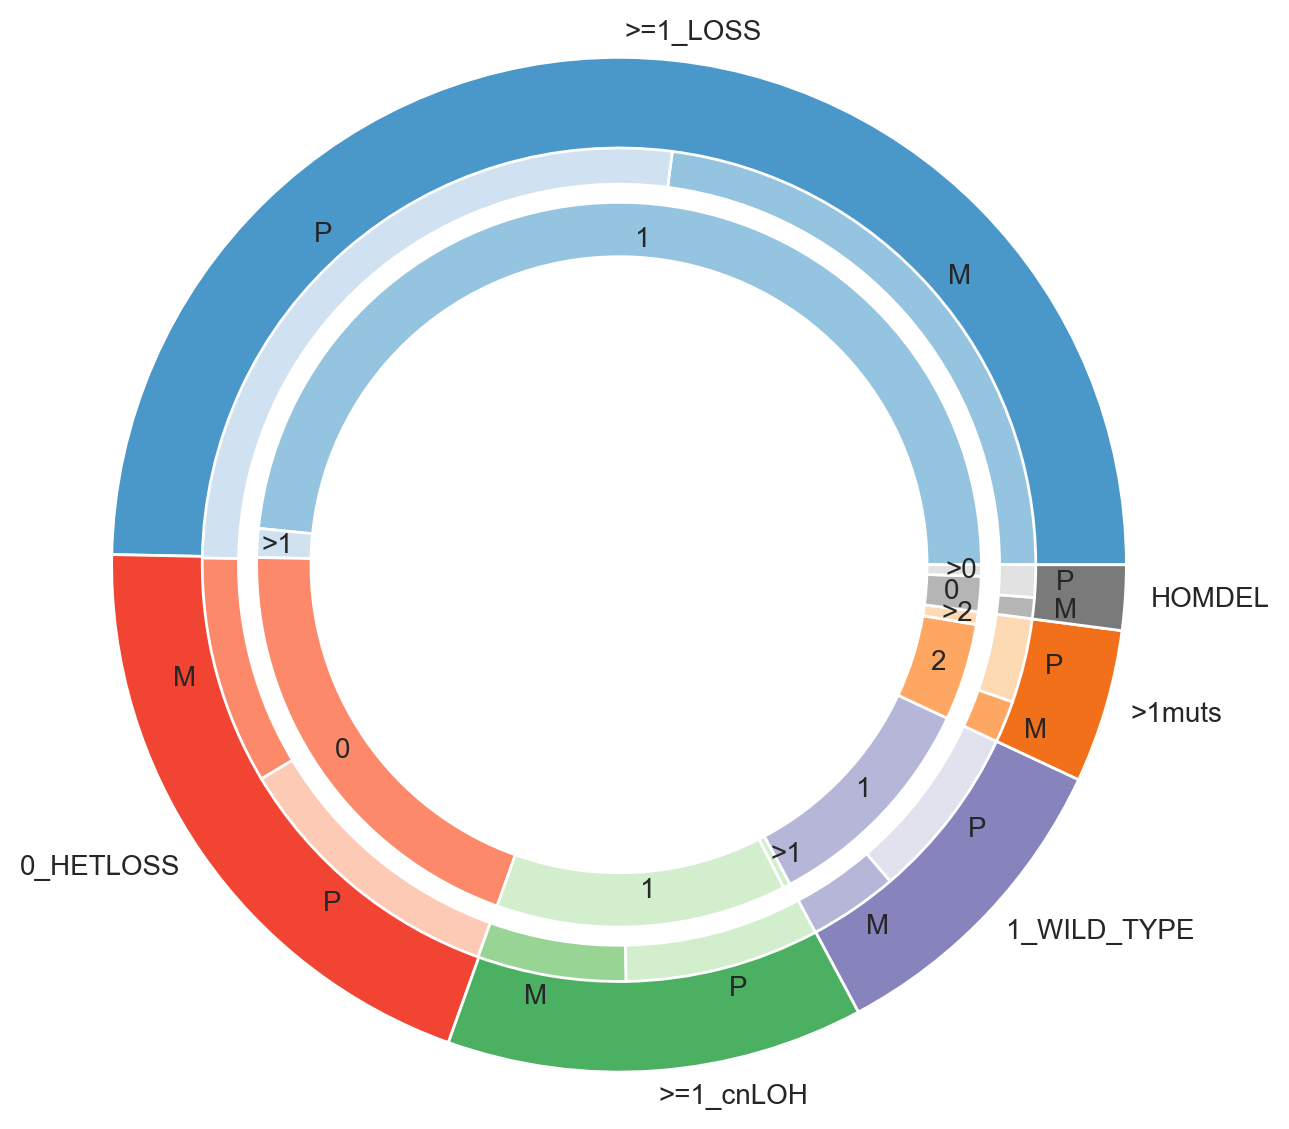

In [50]:
mut_tp53_count = pd.DataFrame(master[['mut_cn_group', 'tp53_count']].groupby(['mut_cn_group', 'tp53_count'], sort = True).size())
mut_tp53_count.columns = ['count']

group_sample_count = pd.DataFrame(master[['mut_cn_group', 'Sample_Type']].groupby(['mut_cn_group', 'Sample_Type'], sort = True).size())
group_sample_count.columns = ['count']

group_names = ['>=1_LOSS','0_HETLOSS', '>=1_cnLOH', '1_WILD_TYPE', '>1muts', 'HOMDEL']
group_size = sorted(list(mut_tp53_count.groupby(['mut_cn_group']).sum()['count']), reverse=True)

subgroup_size = [6904, 183, 2833, 1850, 45, 1457, 616, 81, 224, 72]
subgroup_names = [1, '>1', 0, 1, '>1', 1, 2, '>2', 0, '>0']

sample_size = [3271, 3816, 1260, 1556, 821, 1074, 494, 963, 232, 465, 116, 179]
sample_names = ['M', 'P', 'M', 'P', 'M', 'P', 'M', 'P', 'M', 'P', 'M', 'P']

display_side_by_side(mut_tp53_count, group_sample_count)



# Create colors
a, b, c, d, e, f=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Purples, plt.cm.Oranges, plt.cm.Greys]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.4, labels=group_names,labeldistance=1.05, colors=[a(0.6), b(0.6), c(0.6),d(0.6),e(0.6),f(0.6)] )
plt.setp( mypie, width=0.3, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.4-0.4, labels=subgroup_names, labeldistance=0.9, colors=[a(0.4),a(0.2), b(0.4), c(0.2), c(0.2), d(0.4), e(0.4), e(0.2), f(0.4), f(0.2)])
plt.setp( mypie2, width=0.15, edgecolor='white')
plt.margins(0,0)

# Third Ring (Middle)
mypie3, _ = ax.pie(sample_size, radius=1.4-0.25, labels=sample_names, labeldistance=1.05, colors = [a(0.4), a(0.2), b(0.4), b(0.2), c(0.4), c(0.2), d(0.4), d(0.2), e(0.4), e(0.2), f(0.4), f(0.2)])
plt.setp( mypie3, width=0.1, edgecolor='white')
plt.margins(0,0)

fig.savefig("tp53_subgroups.png", dpi=300, bbox_inches = 'tight')

We display it properly thanks to HTML tags

In [100]:
title = "tp53_subgroups"
html = prefix.replace('title', title)+mut_tp53_count.to_html()+suffix.replace('pic_file.png', title+".png")
IPython.display.display_html(html, raw=True)

<!DOCTYPE html>
 
 

 
 

 tp53_subgroups 

 
 
 
 
 
 
 
 count 
 
 
 mut_cn_group 
 tp53_count 
 
 
 
 
 
 0_HETLOSS 
 0 
 2833 
 
 
 1_WILD_TYPE 
 1 
 1457 
 
 
 >1muts 
 2 
 616 
 
 
 3 
 68 
 
 
 4 
 10 
 
 
 5 
 3 
 
 
 >=1_LOSS 
 1 
 6904 
 
 
 2 
 161 
 
 
 3 
 19 
 
 
 4 
 3 
 
 
 >=1_cnLOH 
 1 
 1850 
 
 
 2 
 39 
 
 
 3 
 6 
 
 
 HOMDEL 
 0 
 224 
 
 
 1 
 63 
 
 
 2 
 8 
 
 
 4 
 1

In [172]:
count = get_groupby(master, 'mut_cn_group', 'count')
countcount.loc[''] = [len(master_mult) - int(get_groupby(master_mult, 'mut_cn_group', 'count').sum())]

count
mut_cn_group       
0_HETLOSS      2833
1_WILD_TYPE    1457
>1muts          697
>=1_LOSS       7087
>=1_cnLOH      1895
HOMDEL          296

---
* **What percentage of the tp53 samples do they represent?**

count 
 
 
 mut_cn_group 
 
 
 
 
 
 1_WILD_TYPE 
 1457 
 
 
 >1muts 
 697 
 
 
 >=1_LOSS 
 7087 
 
 
 >=1_cnLOH 
 1895 
 
 
 HOMDEL 
 72 
 
 
 OTHER 
 1523 
 
 
 0_HETLOSS 
 0 
 
 
 
 
 
 
 % 
 
 
 mut_cn_group 
 
 
 
 
 
 >=1_LOSS 
 55.7 
 
 
 >=1_cnLOH 
 14.9 
 
 
 OTHER 
 12.0 
 
 
 1_WILD_TYPE 
 11.4 
 
 
 >1muts 
 5.5 
 
 
 HOMDEL 
 0.6 
 
 
 0_HETLOSS 
 0.0

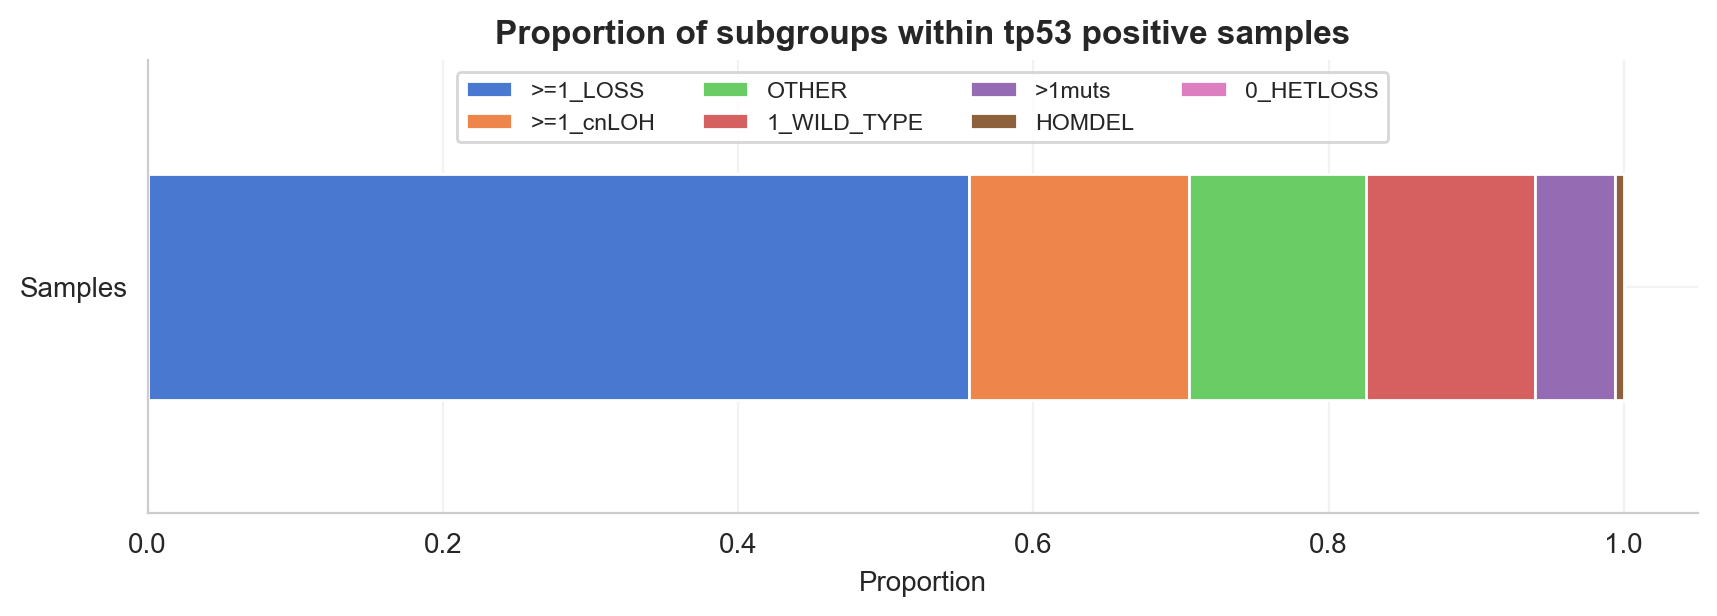

In [14]:
from itertools import cycle, islice

master_mult = filter_muts(master, [1,2,3,4,5])

# We verify that our notebooks 
assert( len(master_mult) == master_mult.mut_cn_group.isna().sum() + int(get_groupby(master_mult, 'mut_cn_group', 'count').sum()))

count = get_groupby(master_mult, 'mut_cn_group', 'count')
count.loc['OTHER'] = [len(master_mult) - int(get_groupby(master_mult, 'mut_cn_group', 'count').sum())]
count.loc['0_HETLOSS'] = [0]

freq = pd.DataFrame(count['count']).sort_values(by=['count'], ascending=False)/ pd.DataFrame(count['count']).sum()
freq.columns=['%']
display_side_by_side(count, round(100*freq,1))

#Plotting it
fig, ax = plt.subplots()
my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, len(count)))
freq.T.plot(kind = 'barh', stacked=True, figsize = (10,3), ax=ax, yticks=[], color=my_colors)
plt.title('Proportion of subgroups within tp53 positive samples', weight = 'bold')
plt.legend(loc = 'upper center', fontsize='small', ncol=4)
ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter(['Samples']))
ax.spines['right'].set_visible(False)
ax.set_xlabel('Proportion')
ax.spines['top'].set_visible(False)
plt.show()

---
What cn_state are present in the OTHER subgroup, and what is the number of people?

count     %
cn_state                      
INDETERMINATE       1211  79.6
DOUBLE LOSS AFTER    107   7.0
CNLOH & GAIN          61   4.0
GAIN                  56   3.7
CNLOH AFTER           43   2.8
LOSS & GAIN           15   1.0
AMP                   12   0.8
AMP (LOH)             12   0.8
AMP (BALANCED)         4   0.3

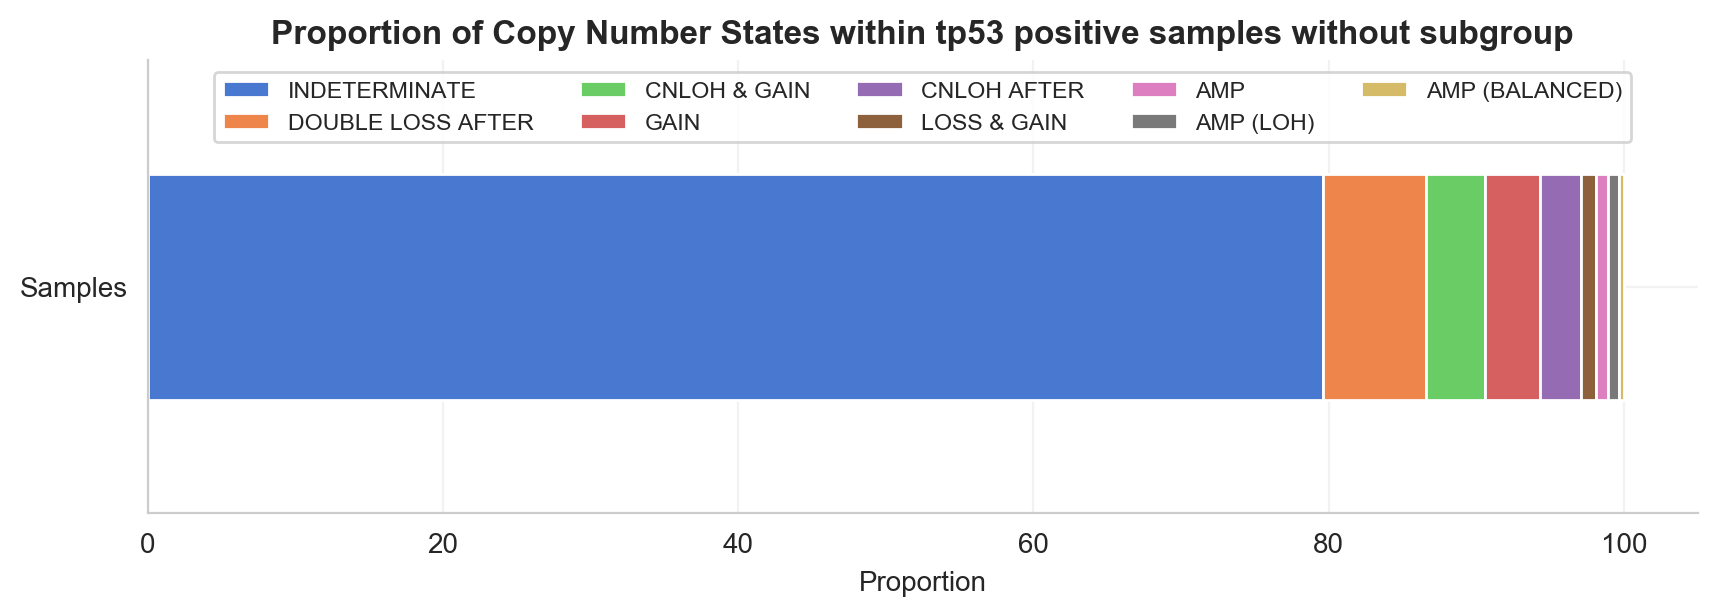

In [17]:
master_mult = filter_muts(master, [1,2,3,4,5])
master_mult = filter_general(master_mult, 'mut_cn_group',[None])
count = get_groupby(master_mult, 'cn_state', 'count').sort_values(by=['count'], ascending=False)
count['%'] = round(100*pd.DataFrame(count['count']).sort_values(by=['count'], ascending=False)/ pd.DataFrame(count['count']).sum(),1)
#freq.columns = ['%']
display(count)

#Plotting it
fig, ax = plt.subplots()
my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, len(count)))
count[['%']].T.plot(kind = 'barh', stacked=True, figsize = (10,3), ax=ax, yticks=[], color=my_colors)
plt.title('Proportion of Copy Number States within tp53 positive samples without subgroup', weight = 'bold')
plt.legend(loc = 'upper center', fontsize='small', ncol=5)
ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter(['Samples']))
ax.spines['right'].set_visible(False)
ax.set_xlabel('Proportion')
ax.spines['top'].set_visible(False)
plt.show()


## Individual Group Description

The following plots describe the different subgroups we created.
* *nb_muts_density*: nb of tp53 mutations we select to plot the densities (vaf, ccf, purity)
* *nb_muts_scatter*: nb of tp53 mutations we select to plot the scatters (VAF1/VAF2 and CCF1/CCF2) (0 means no plot because no multiple mutations)
* *mut_cn_group*: condition parameter to plot (not important)

**NB**: For now, 0_HETLOSS does not have anything because the subgroup does not include any tp53 mutation, same for HOMDEL. Tomorrow (Wednesday) I will compute visual summaries for them.

count
cn_state                  
HETLOSS               3727
LOSS BEFORE           3131
LOSS BEFORE & AFTER    226

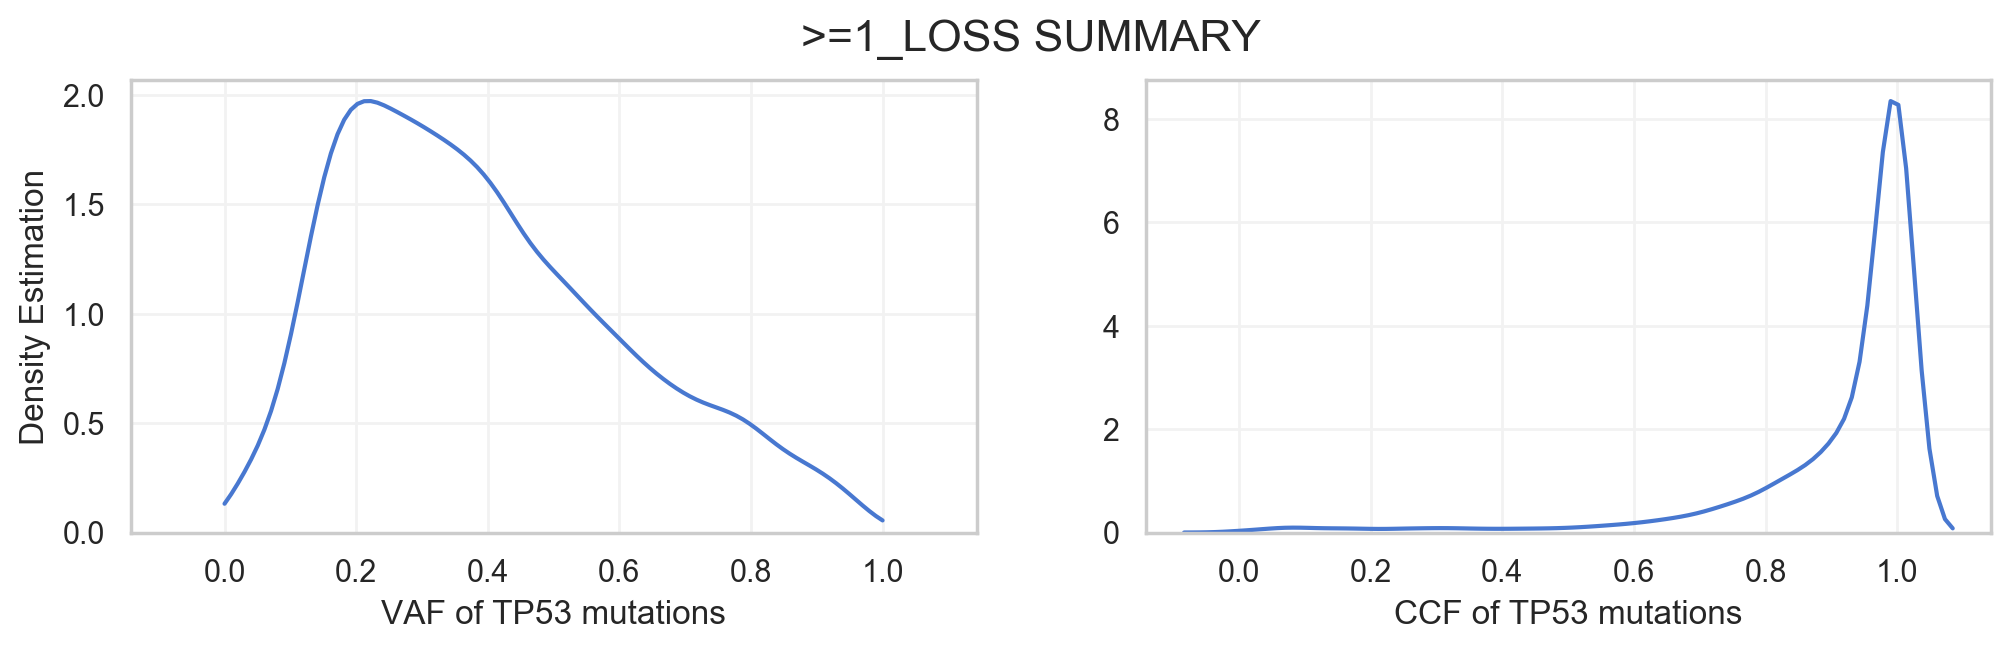

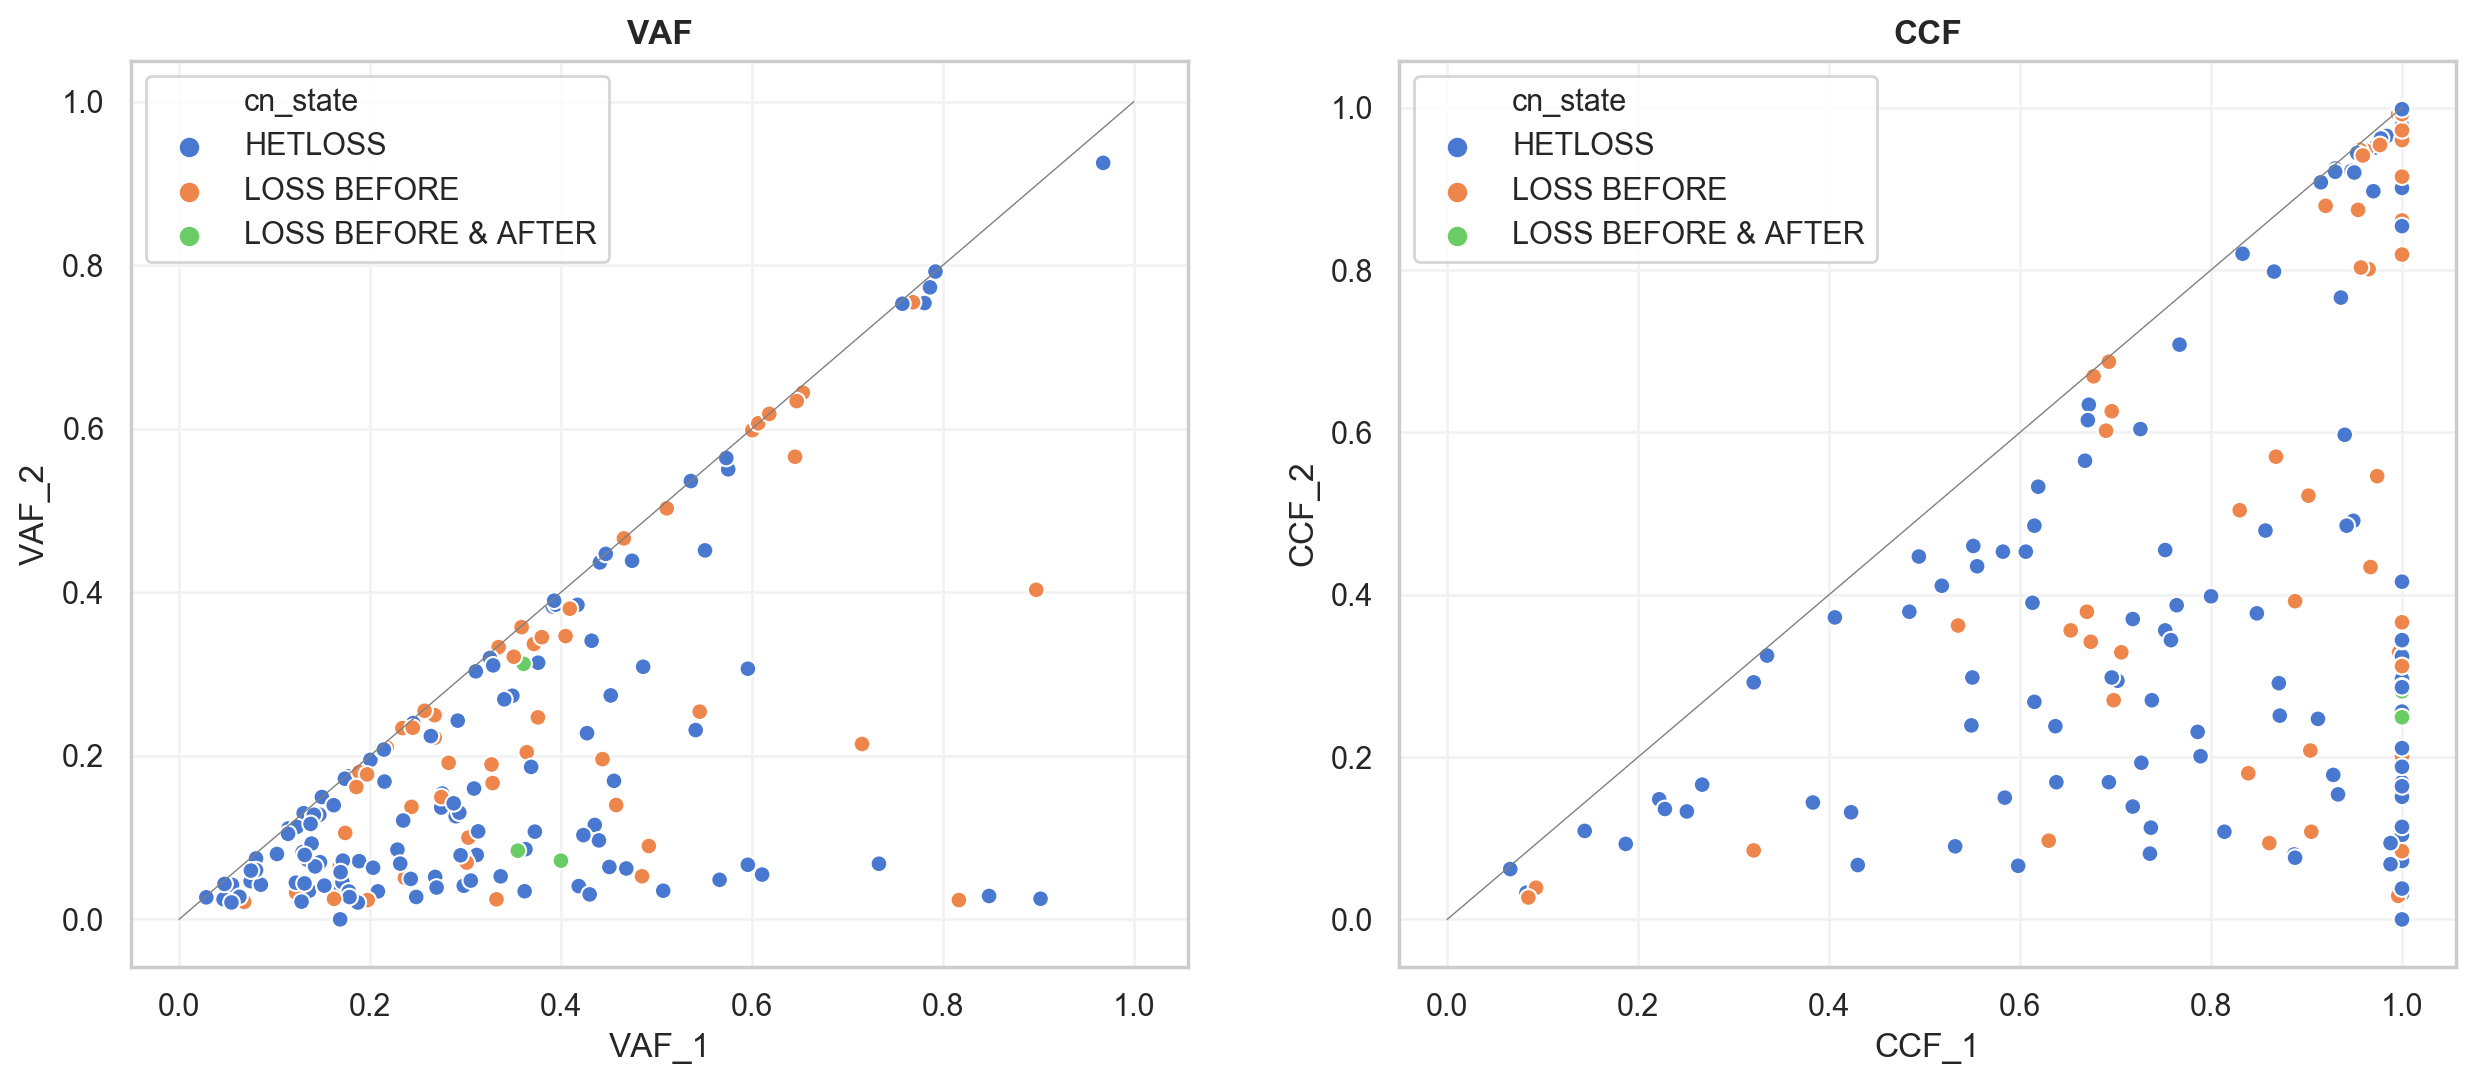

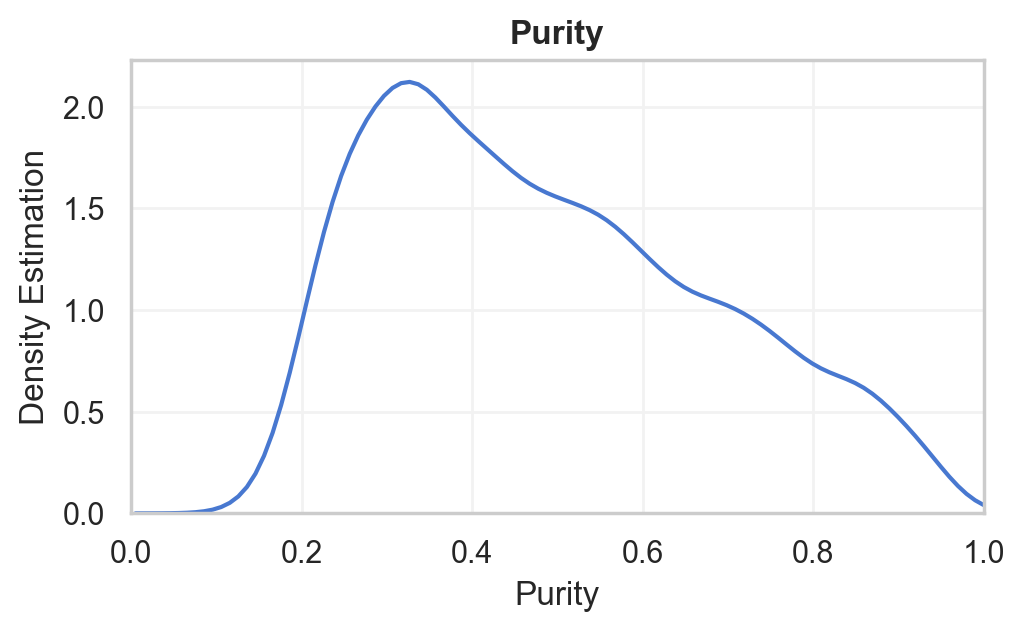

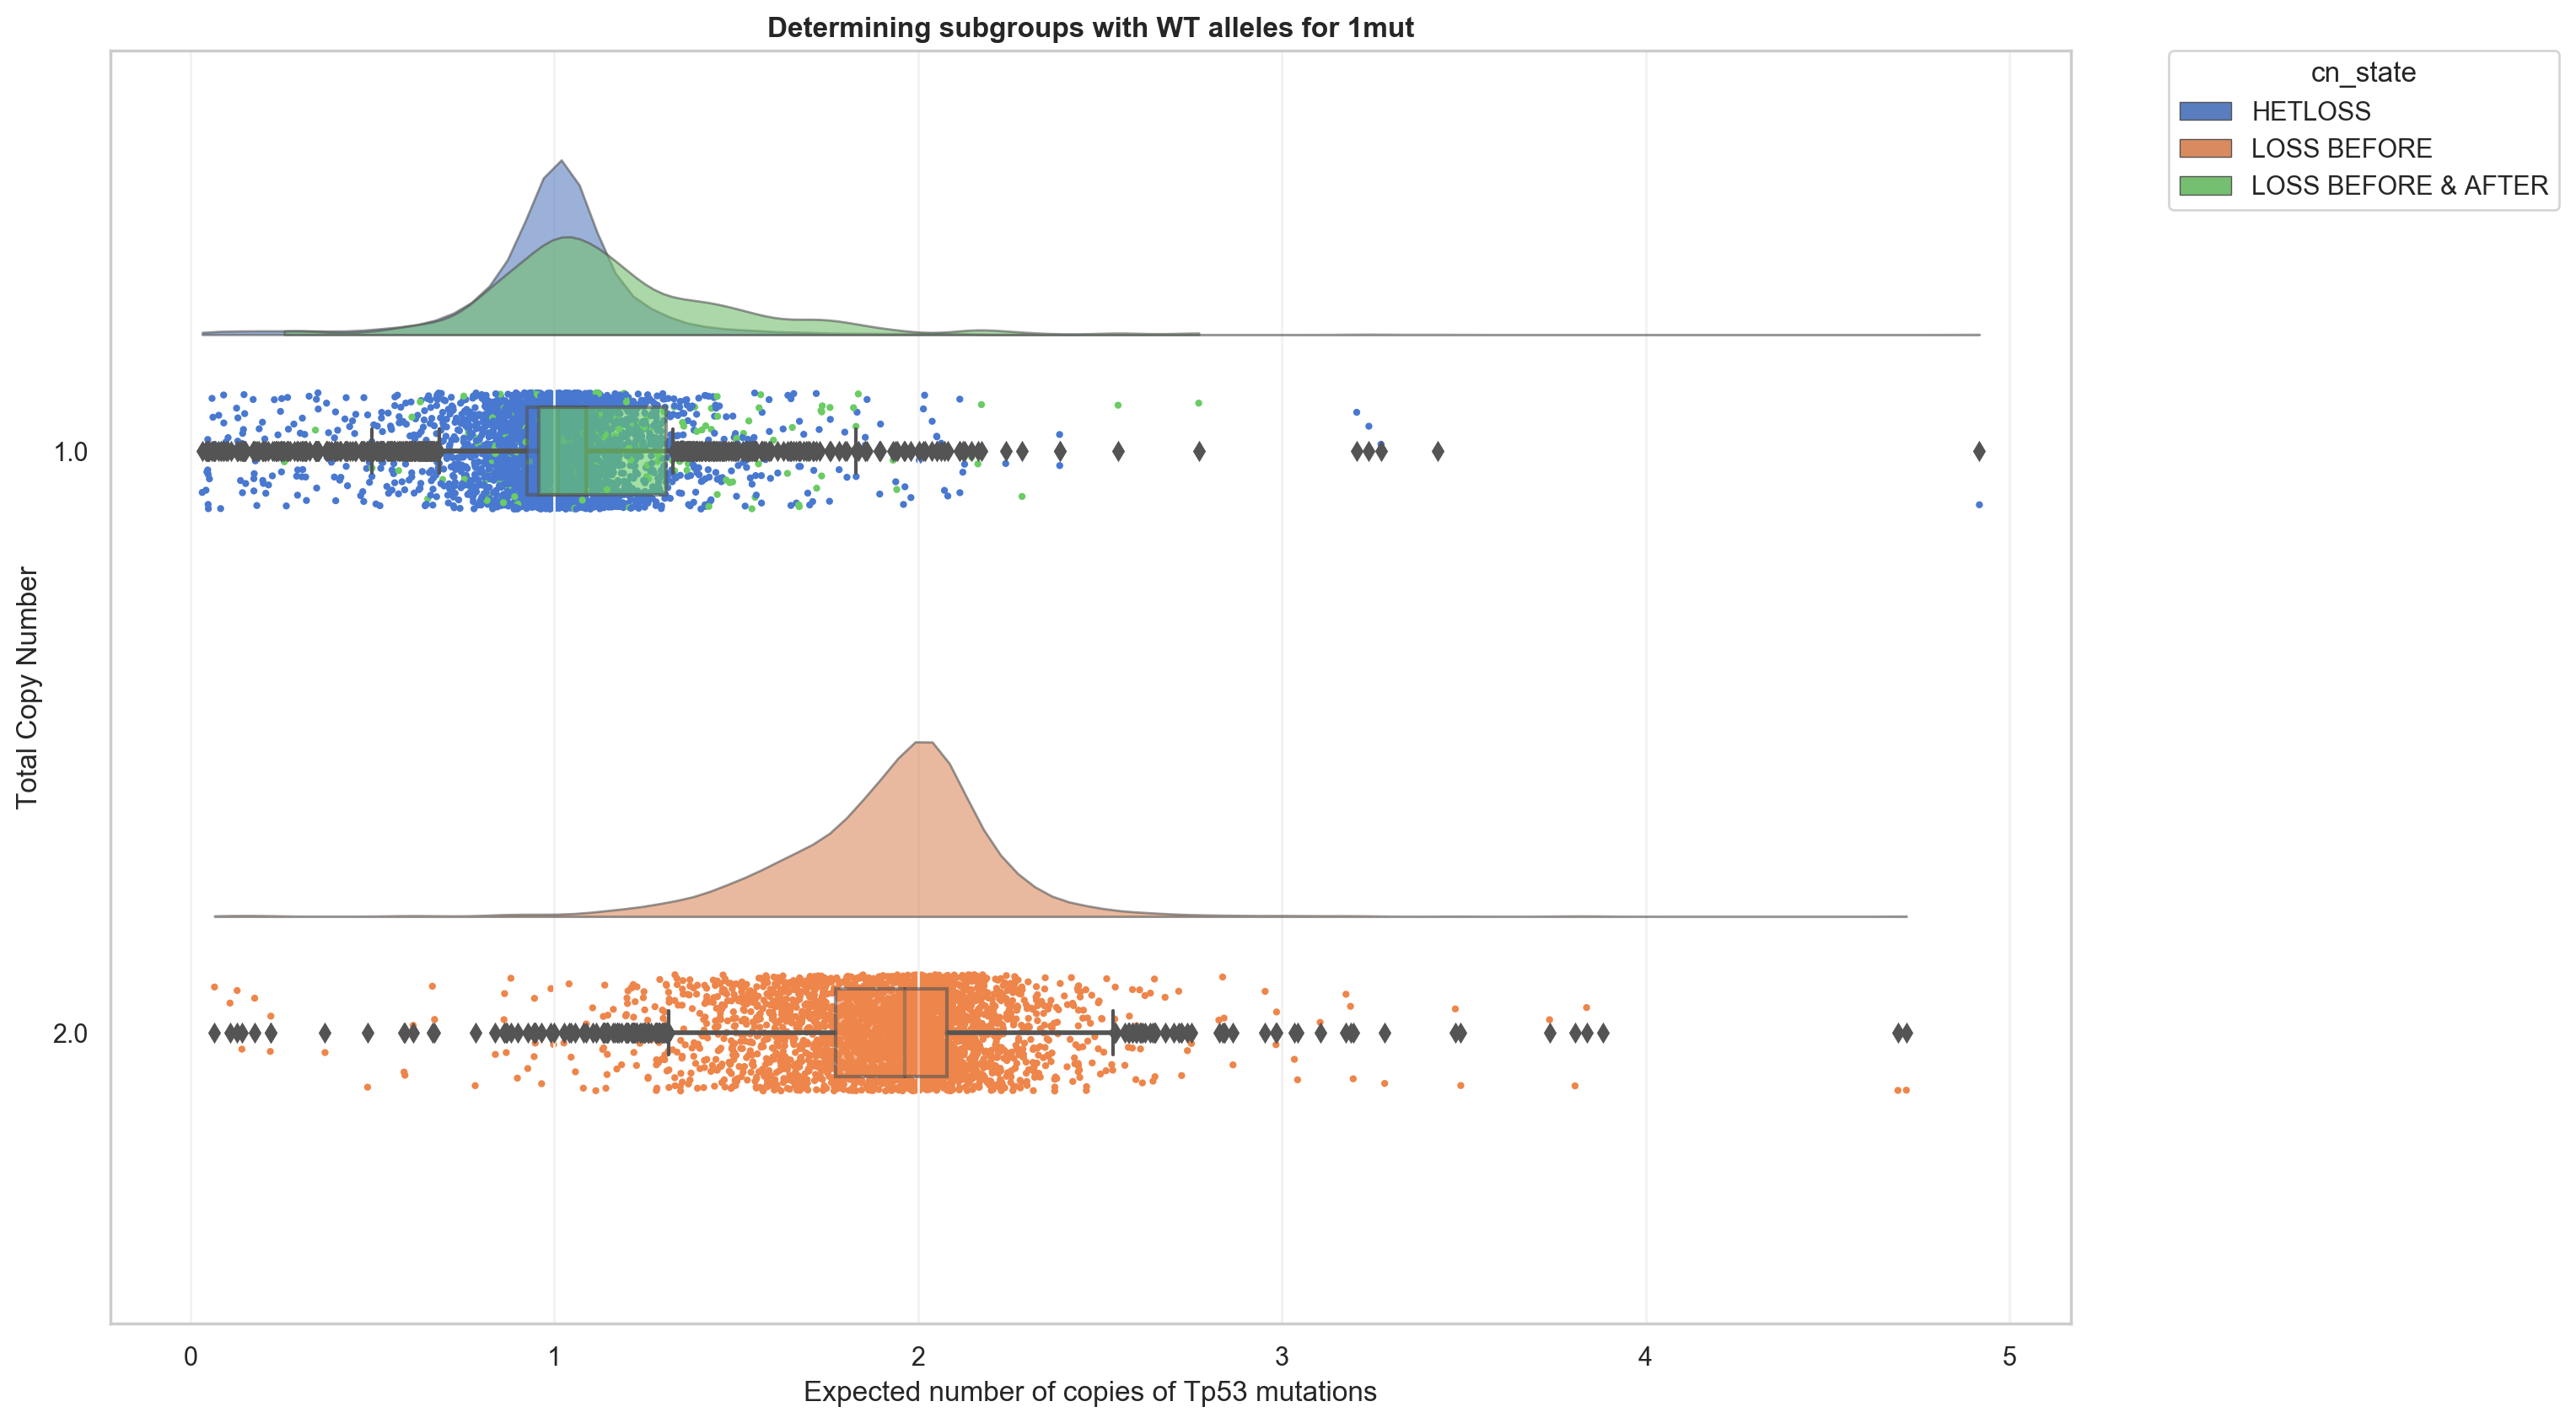

In [85]:
plot_summary(group=['>=1_LOSS'],group_name='>=1_LOSS',nb_muts_density=[1,2,3],nb_muts_scatter=[2,3], mut_cn_group=True)

count
cn_state                  
CNLOH                  802
CNLOH BEFORE           174
CNLOH BEFORE & GAIN     26
CNLOH BEFORE & LOSS    893

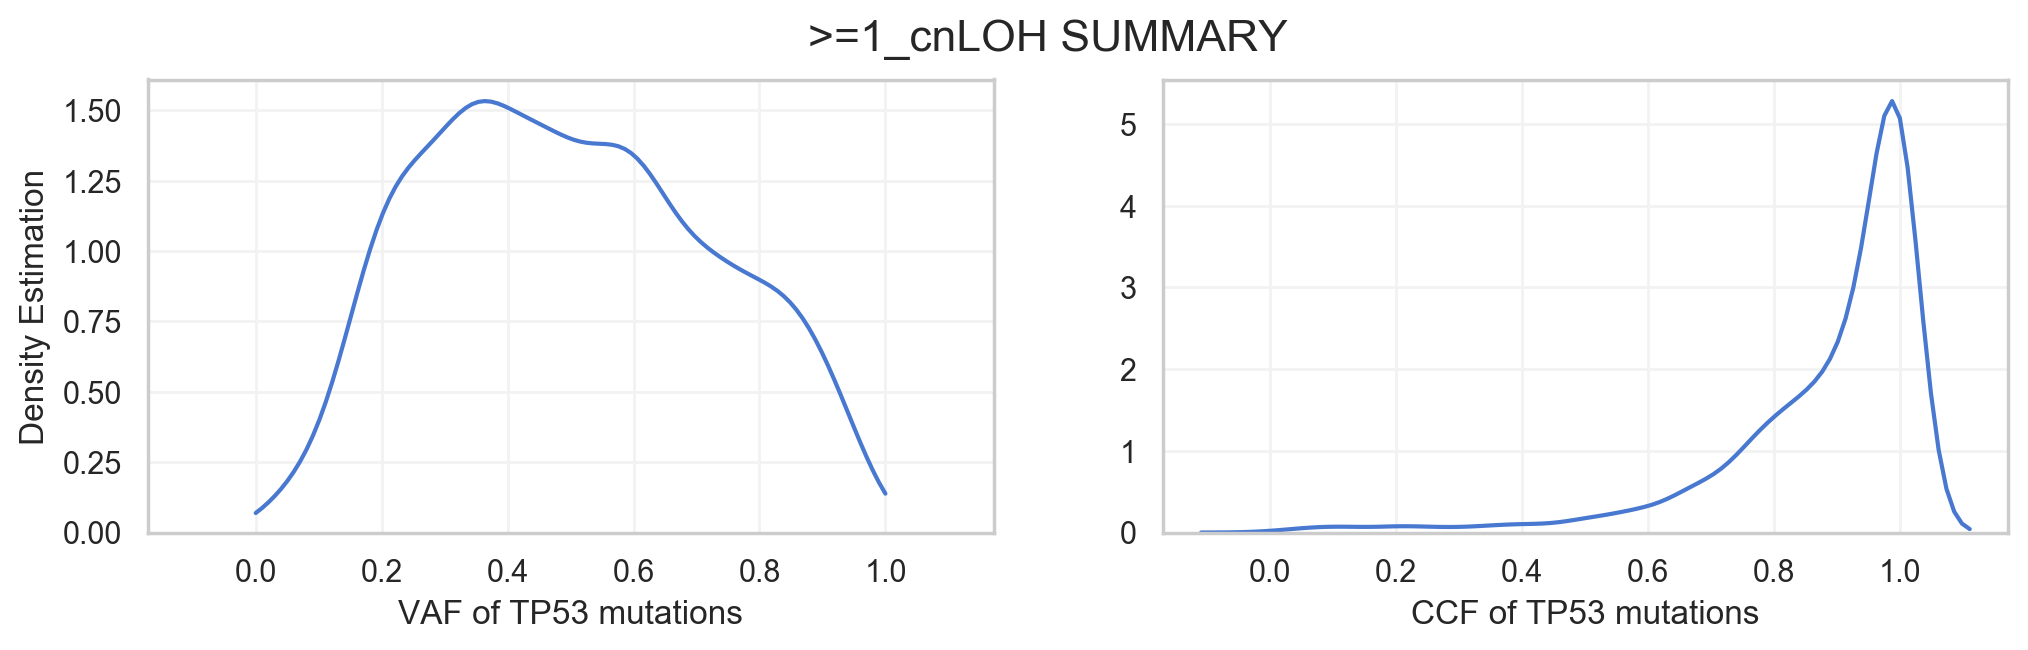

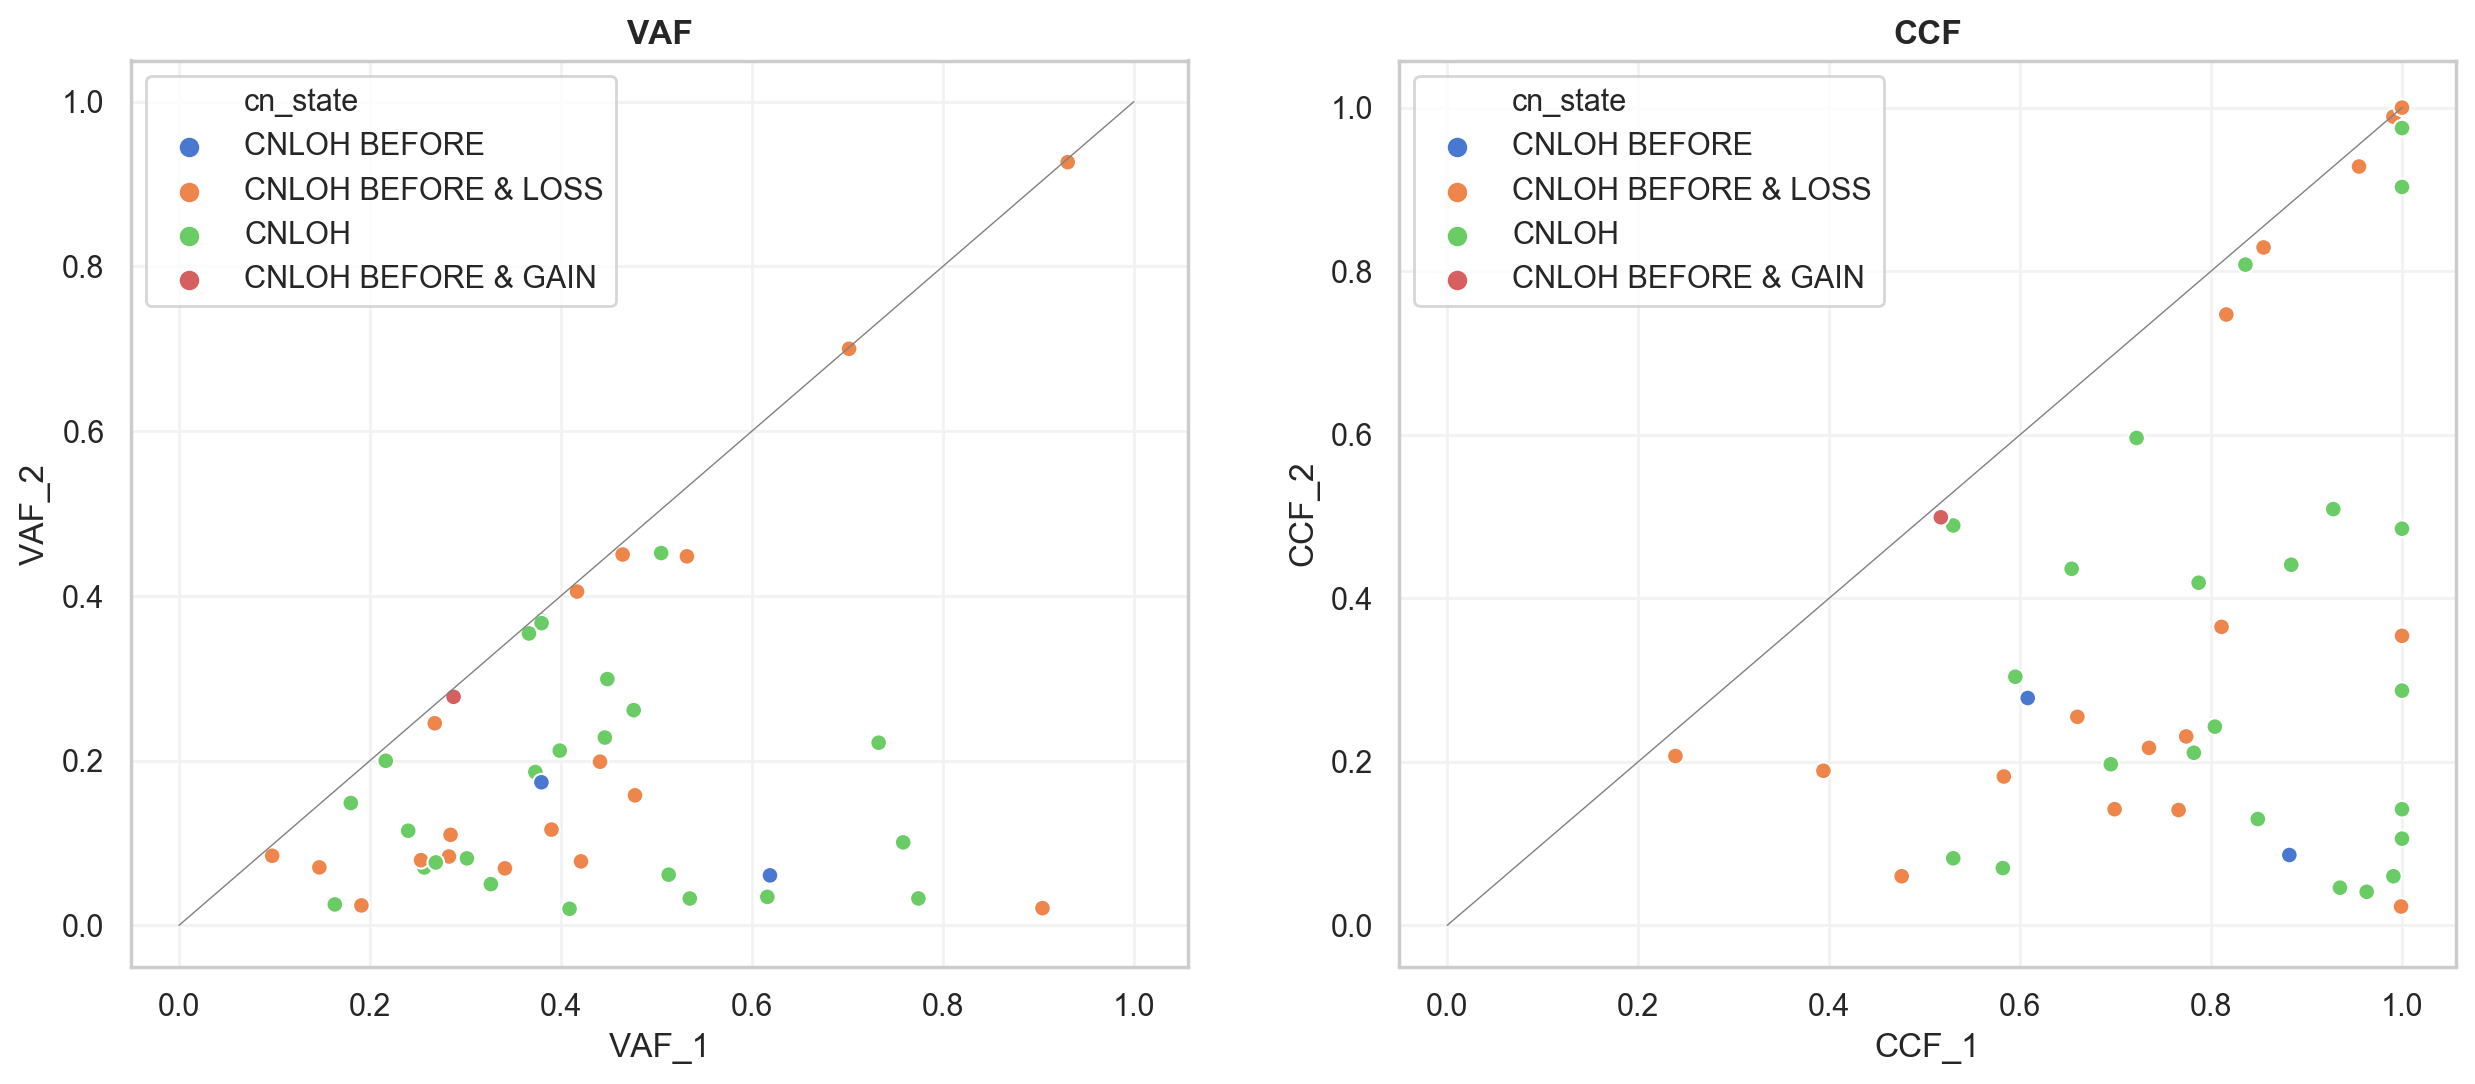

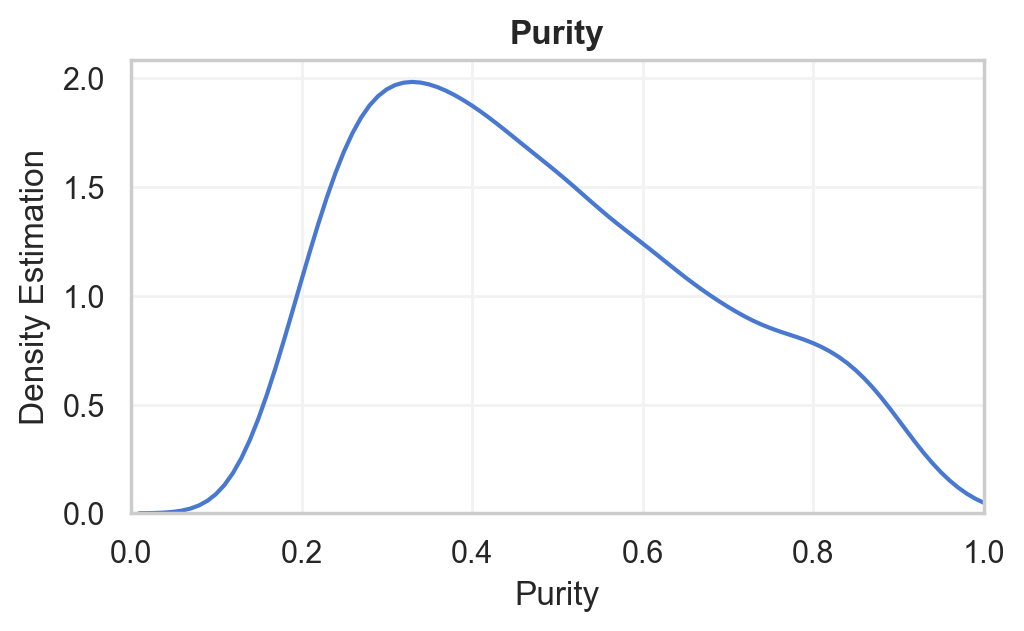

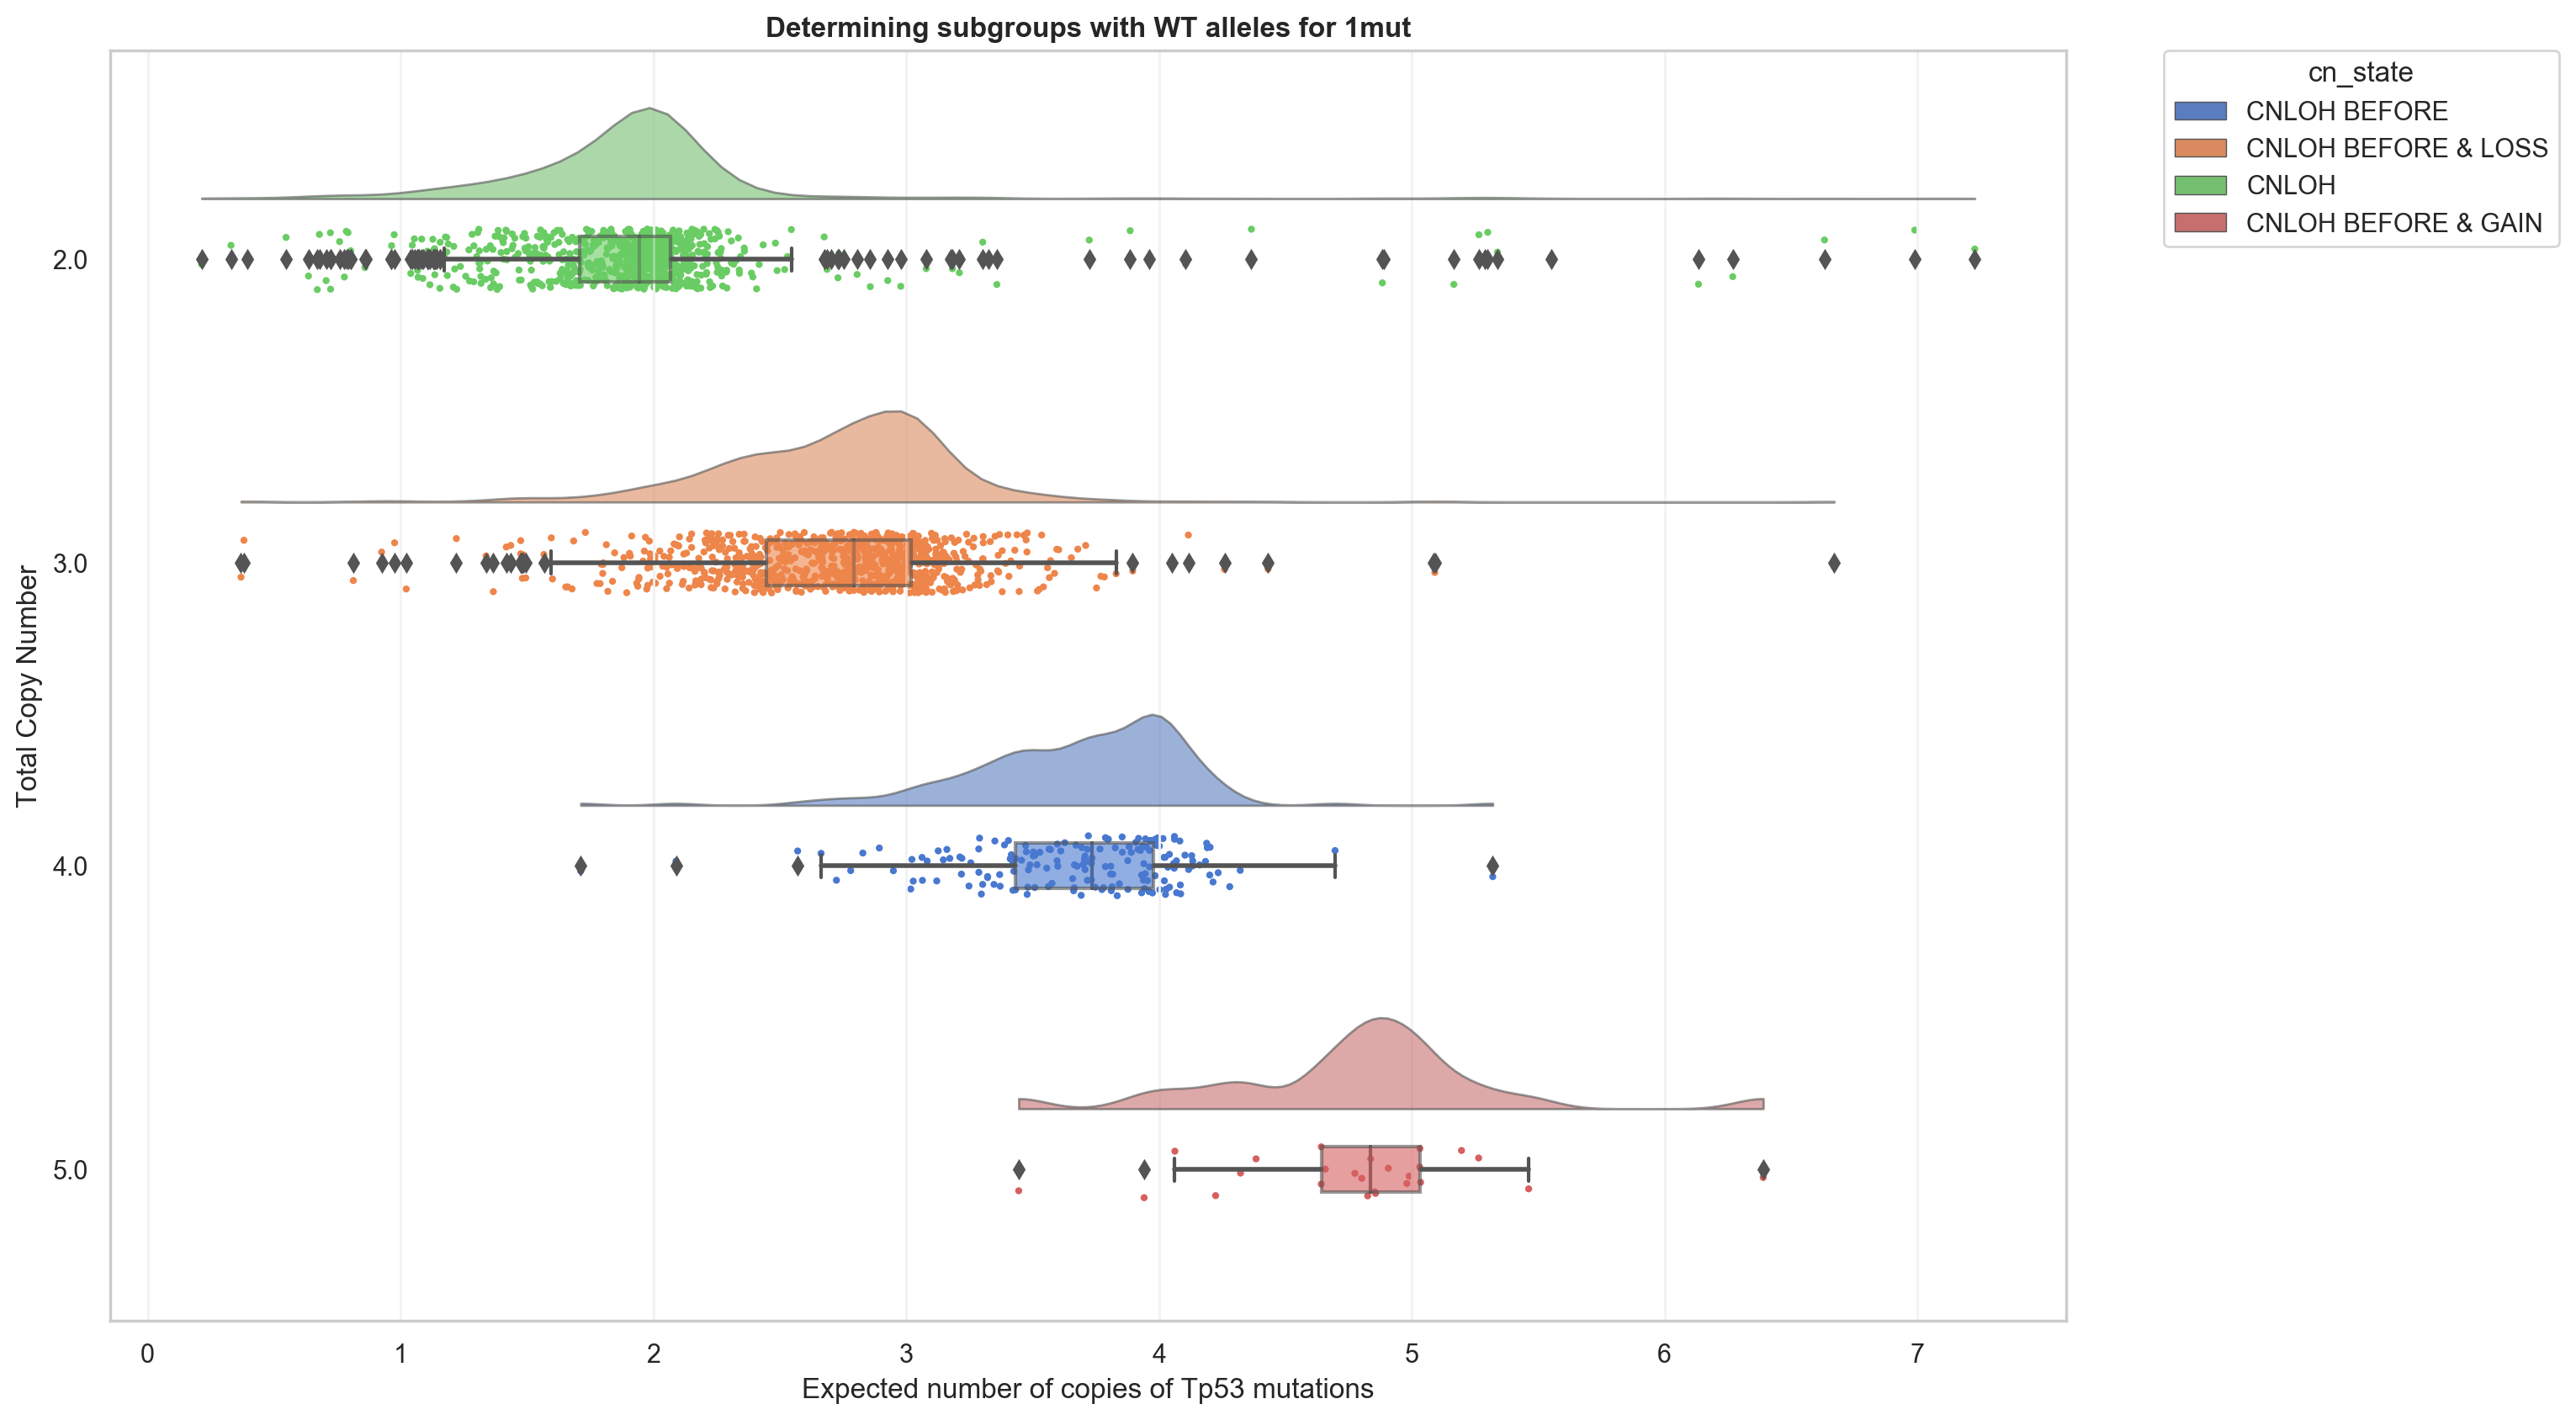

In [92]:
plot_summary(group=['>=1_cnLOH'],group_name='>=1_cnLOH',nb_muts_density=[1,2,3], nb_muts_scatter=[2,3], mut_cn_group=True)

count
cn_state         
DIPLOID      1262
LOSS AFTER    166
TETRAPLOID     29

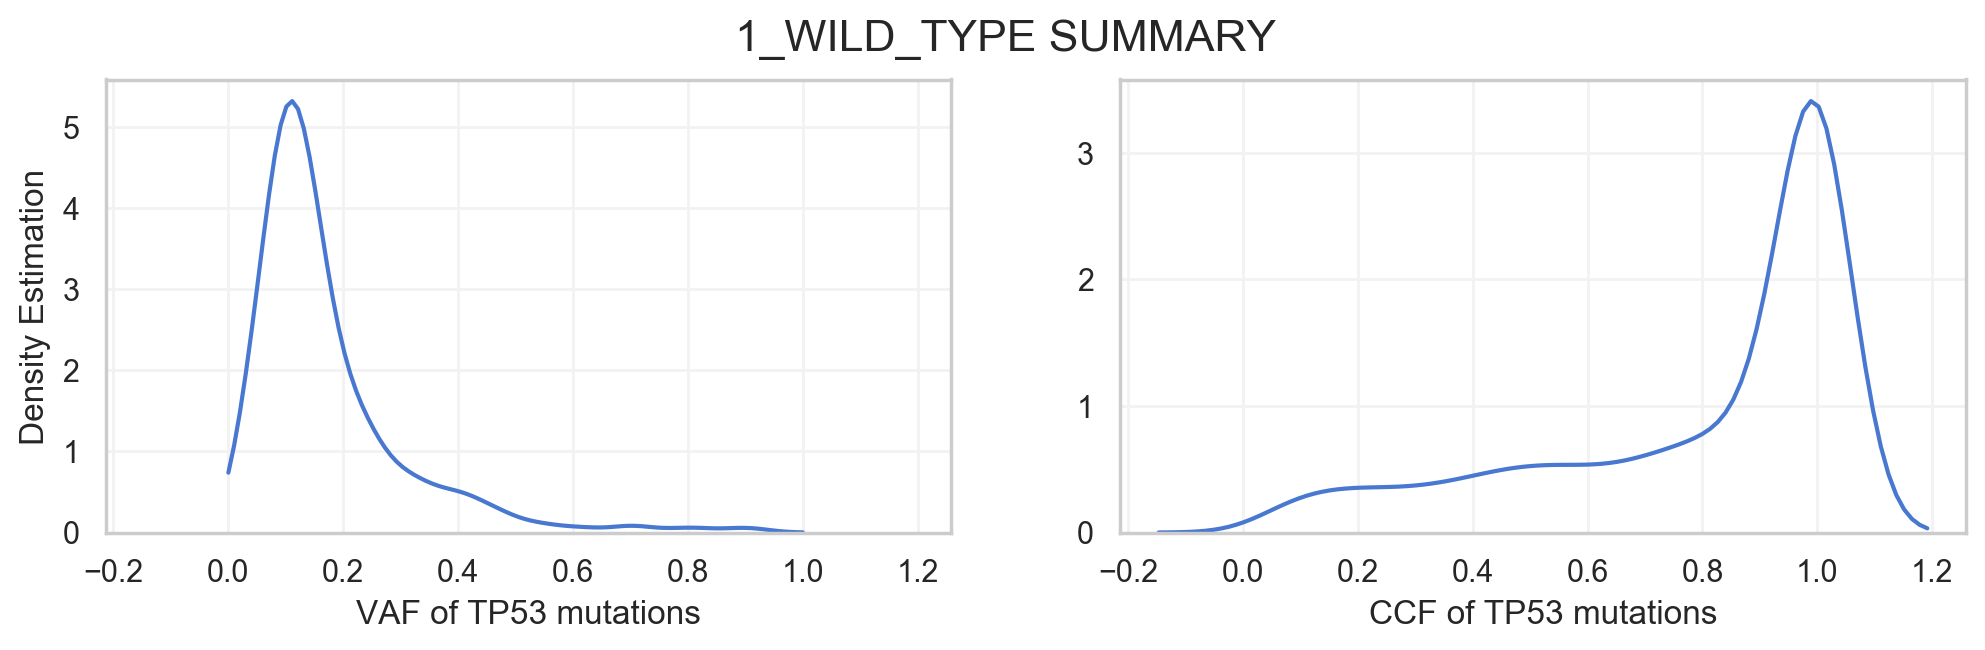

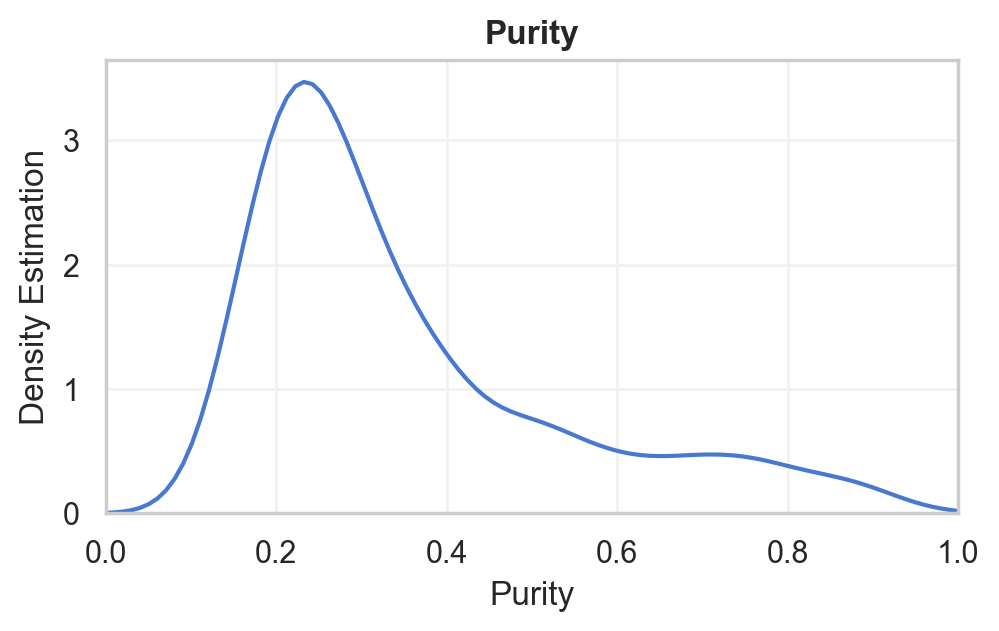

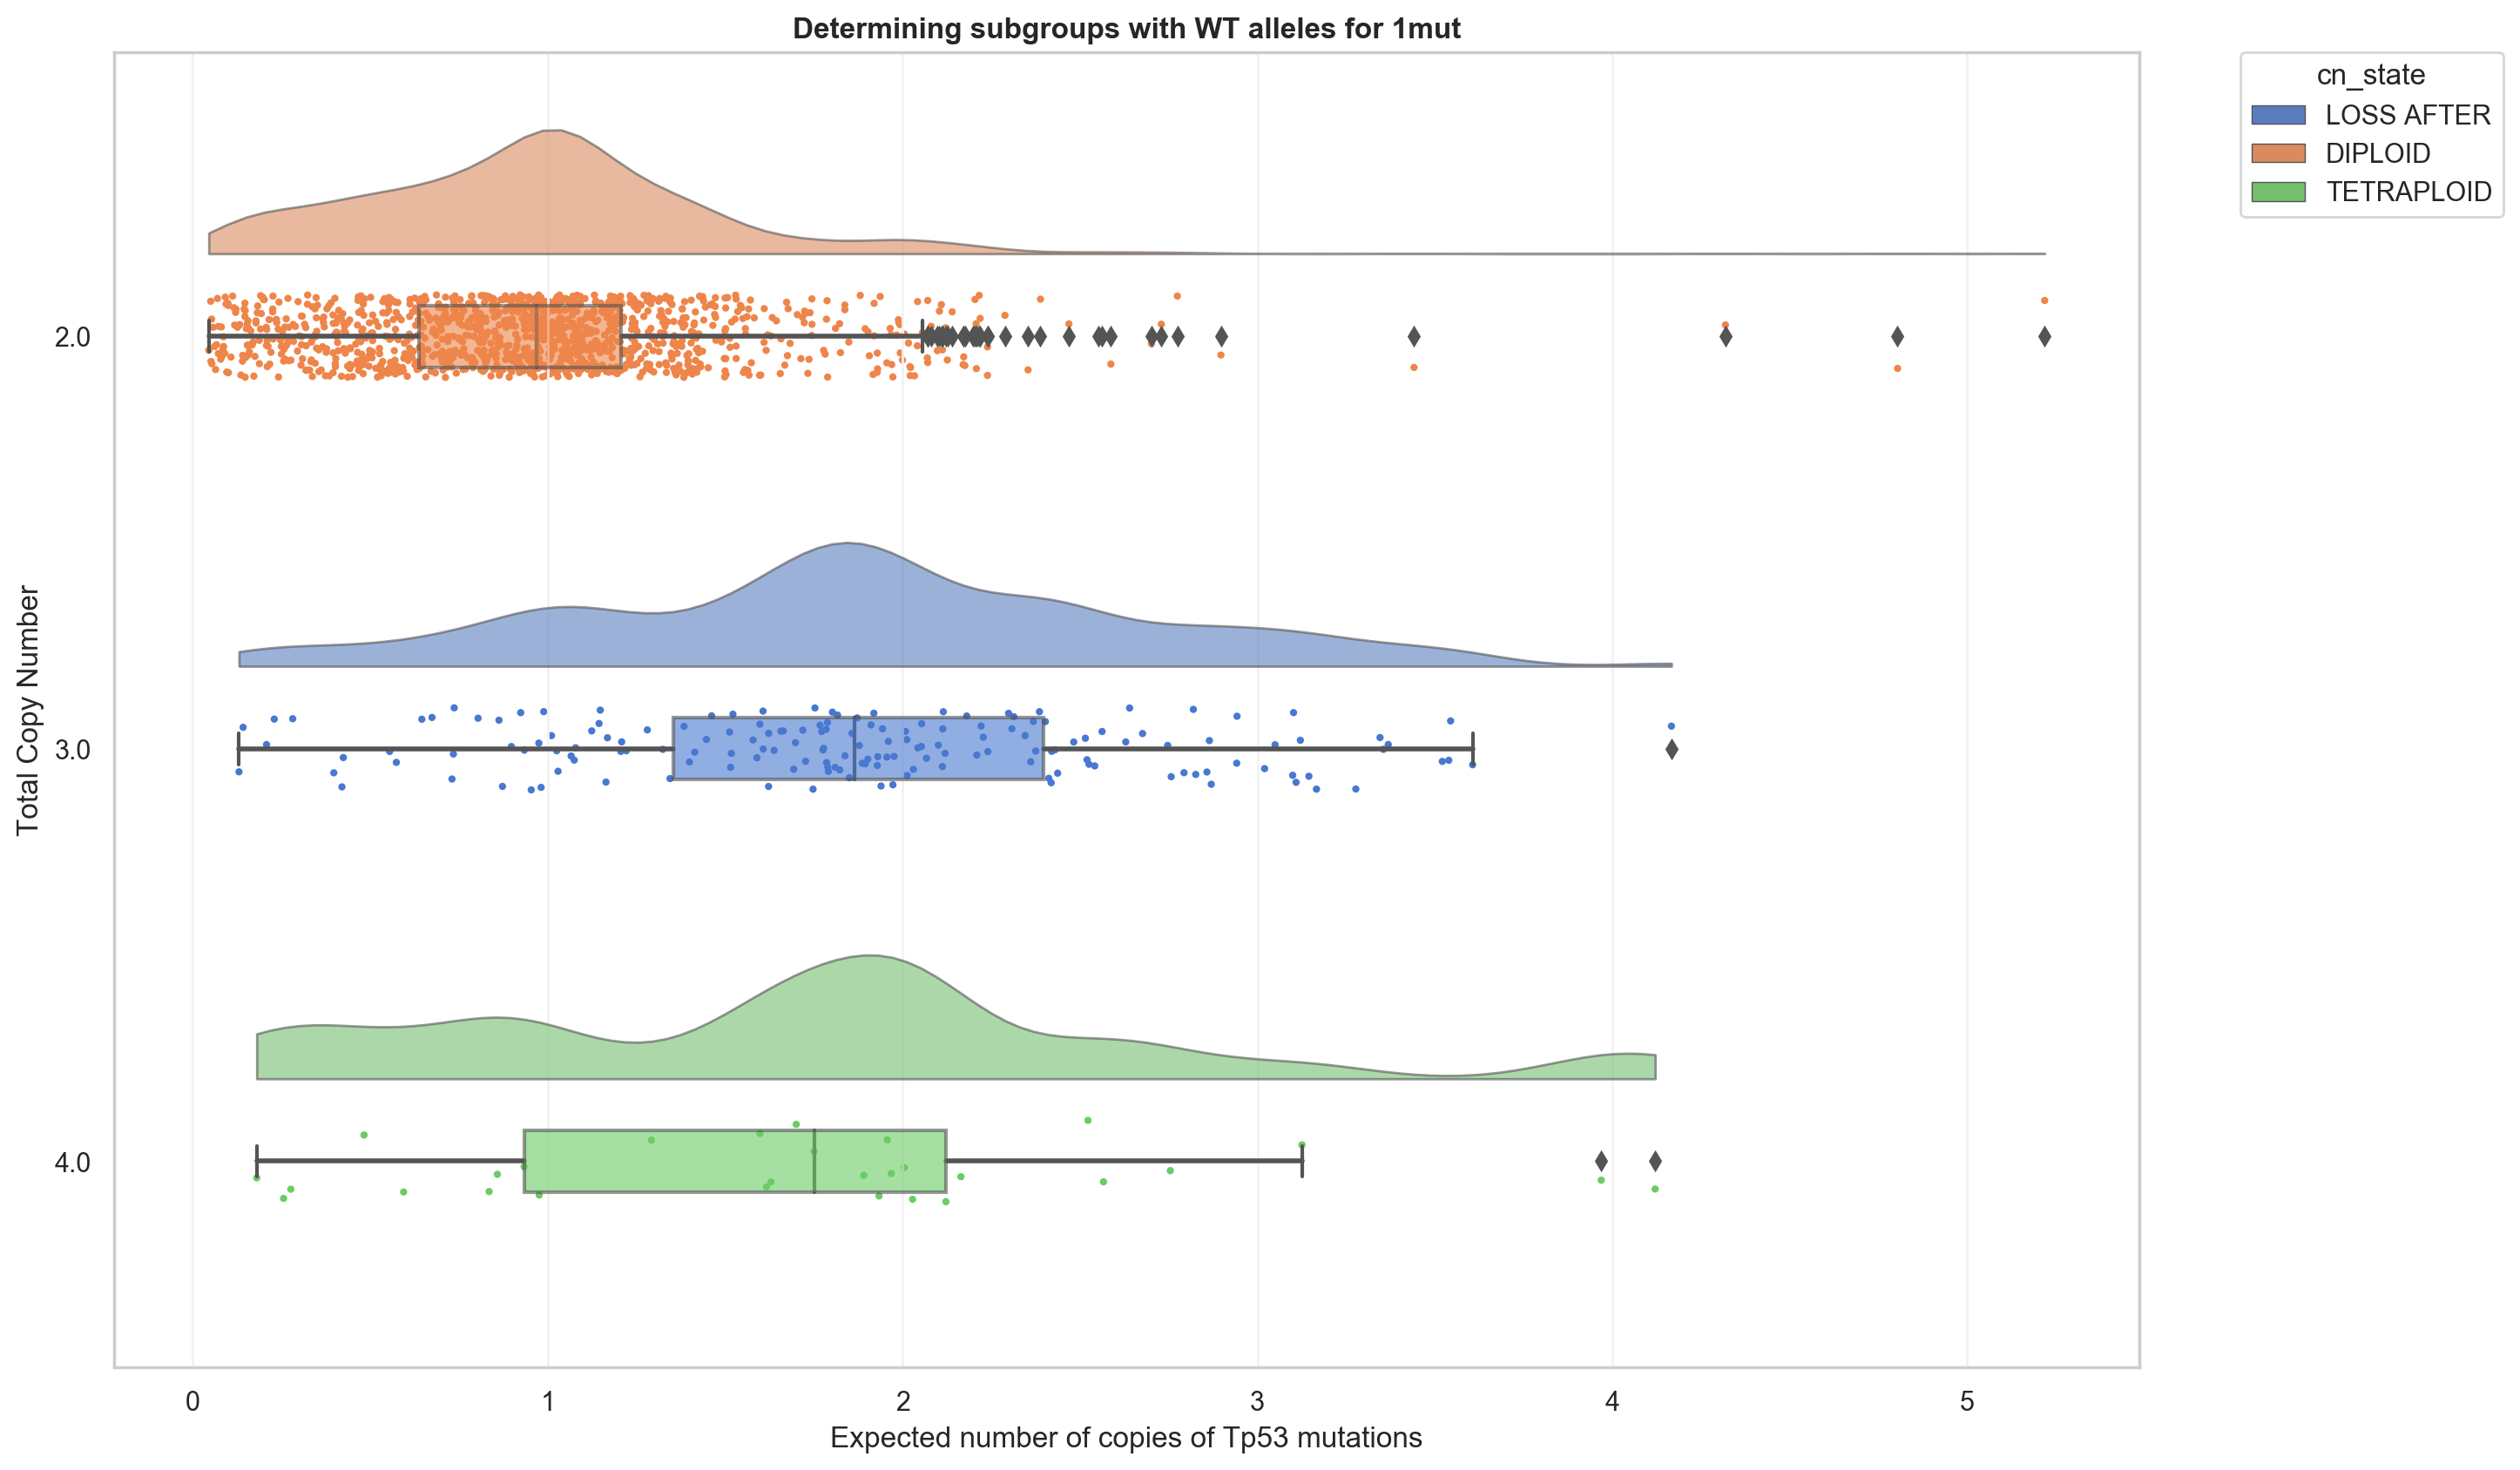

In [86]:
plot_summary(group=['1_WILD_TYPE'],group_name='1_WILD_TYPE',nb_muts_density=[1],nb_muts_scatter=0, mut_cn_group=True)

count
cn_state                
DIPLOID              459
DOUBLE LOSS AFTER     42
GAIN                  37
LOSS AFTER           106
TETRAPLOID            53

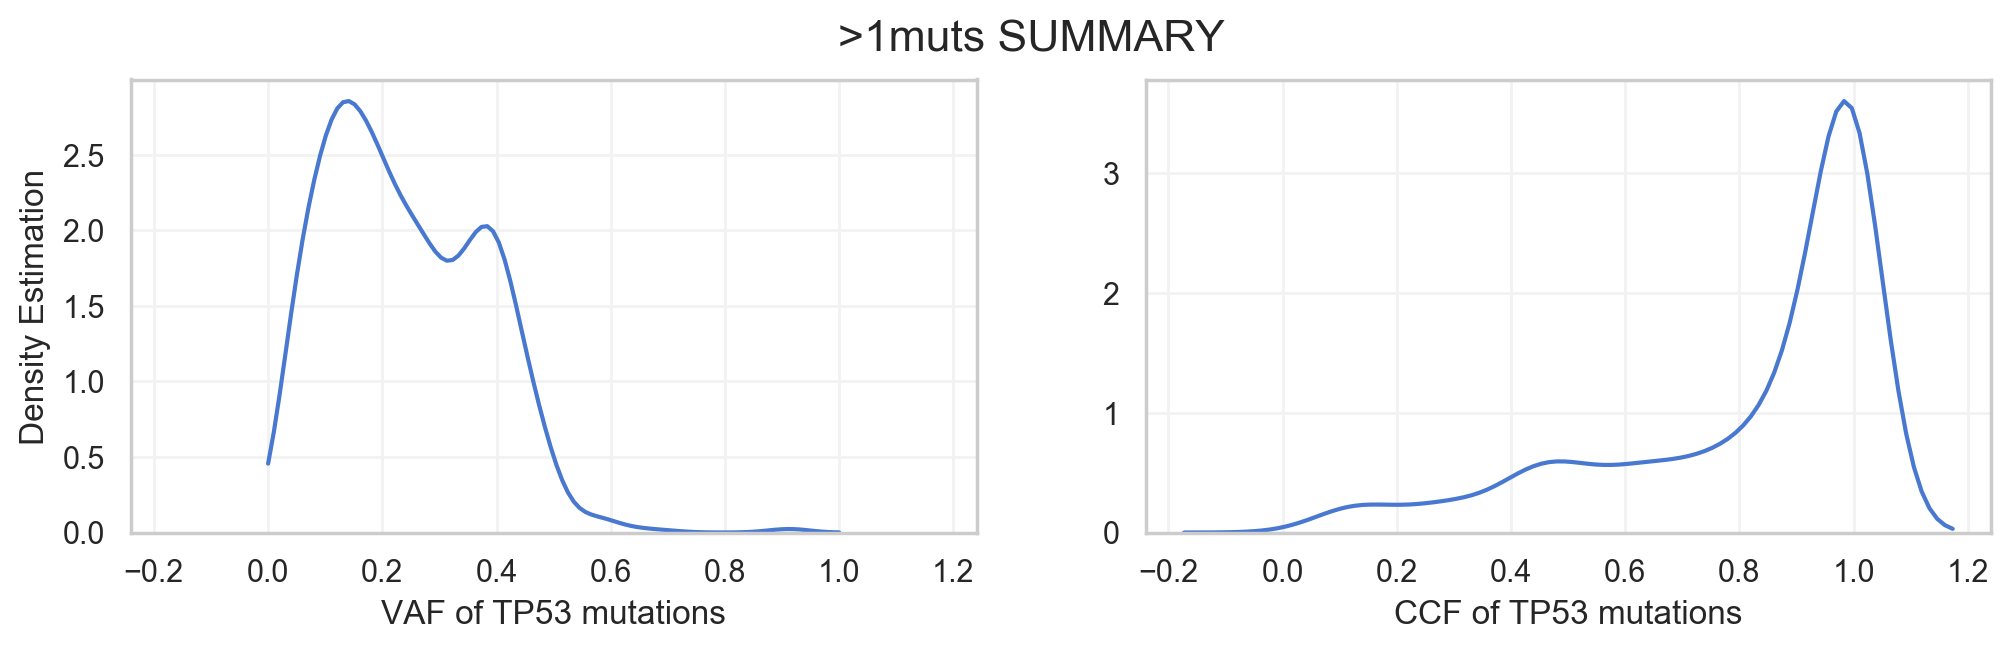

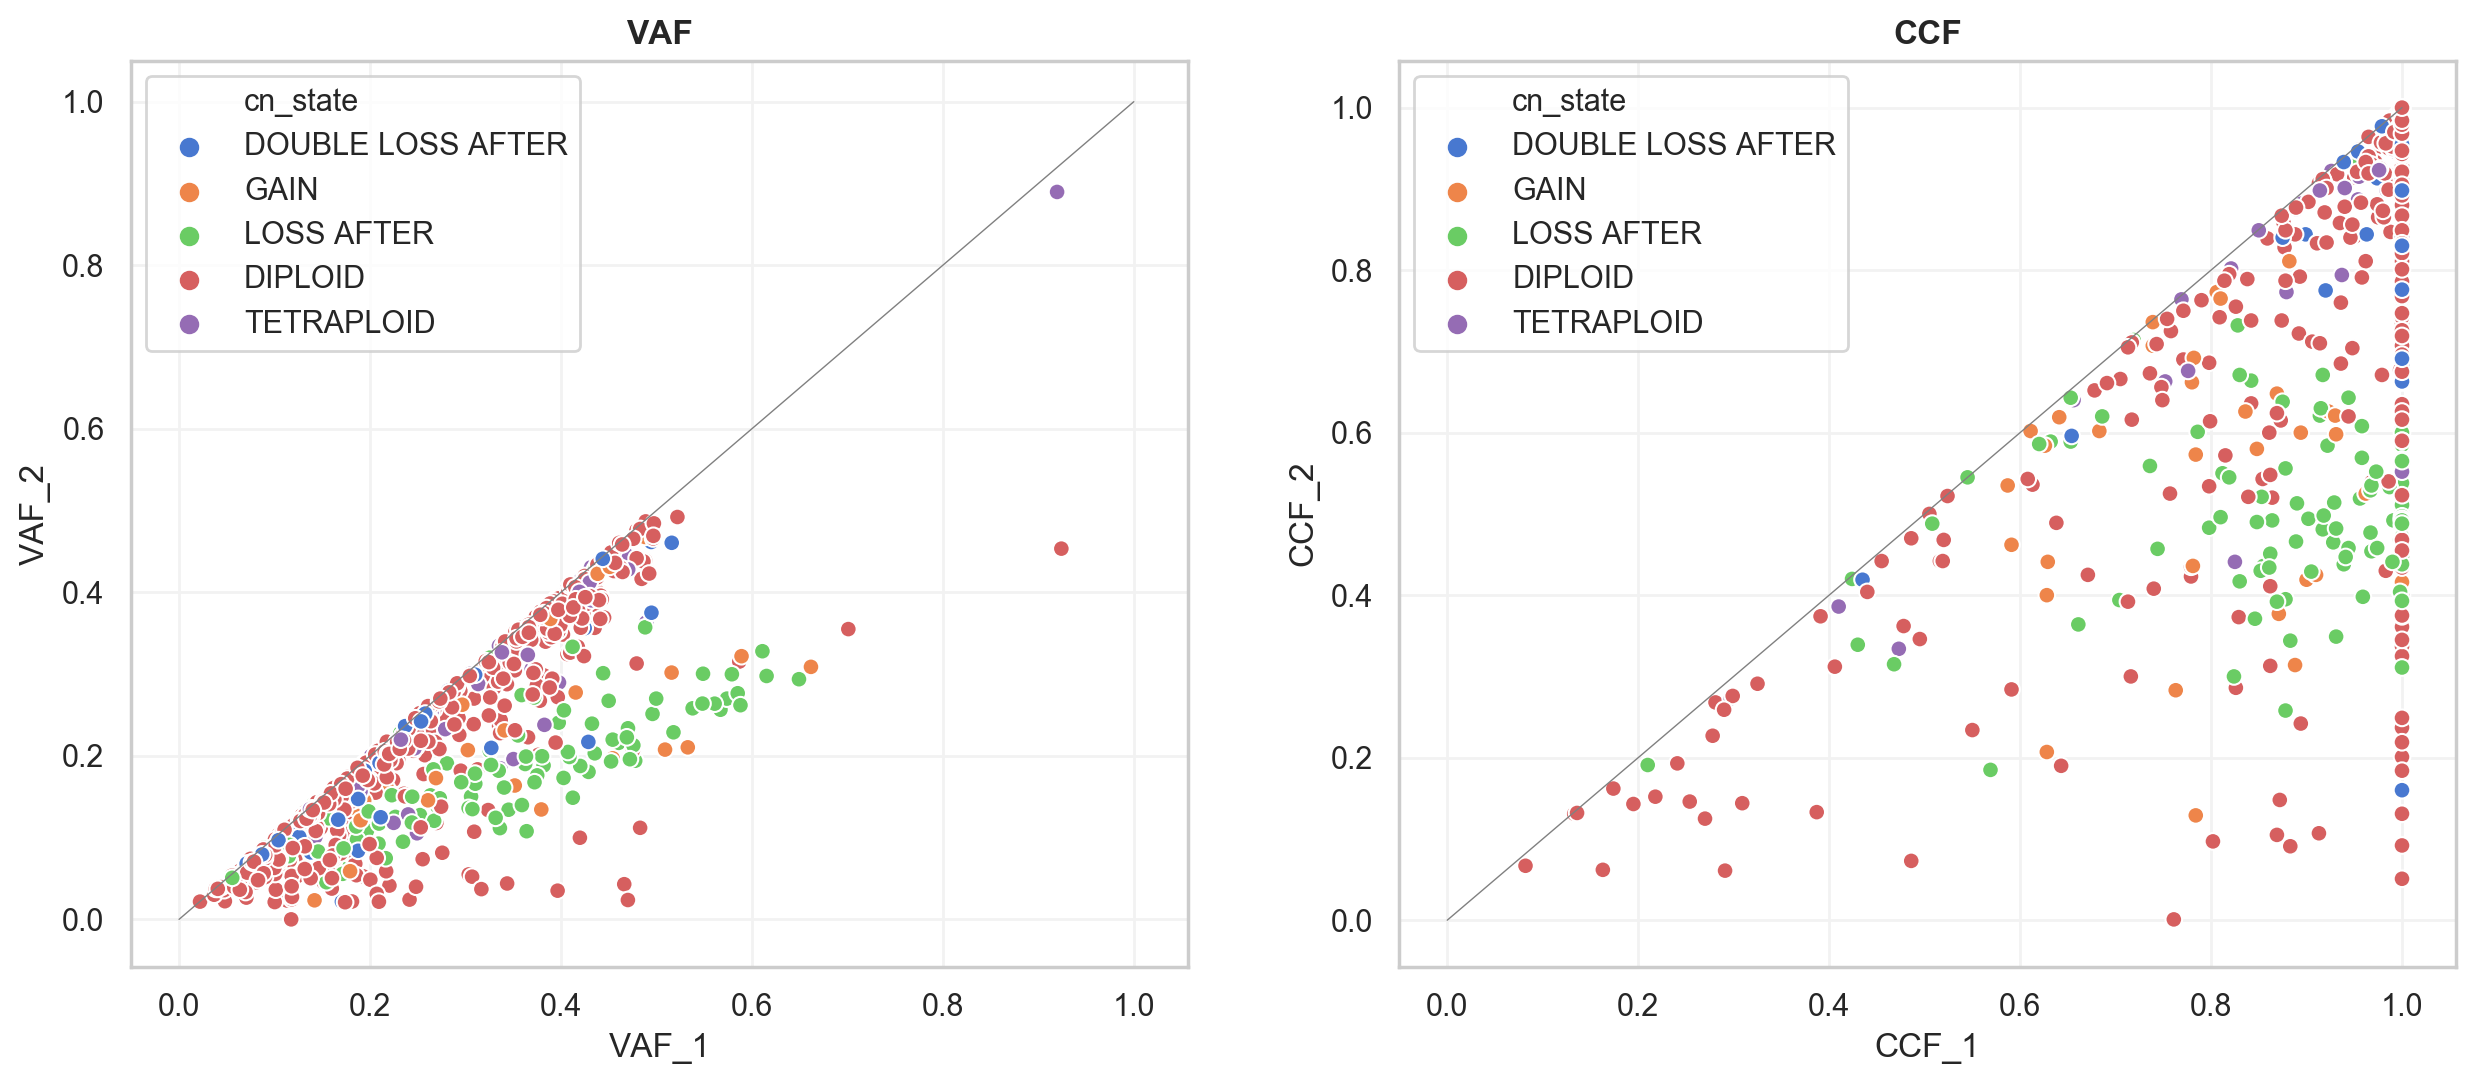

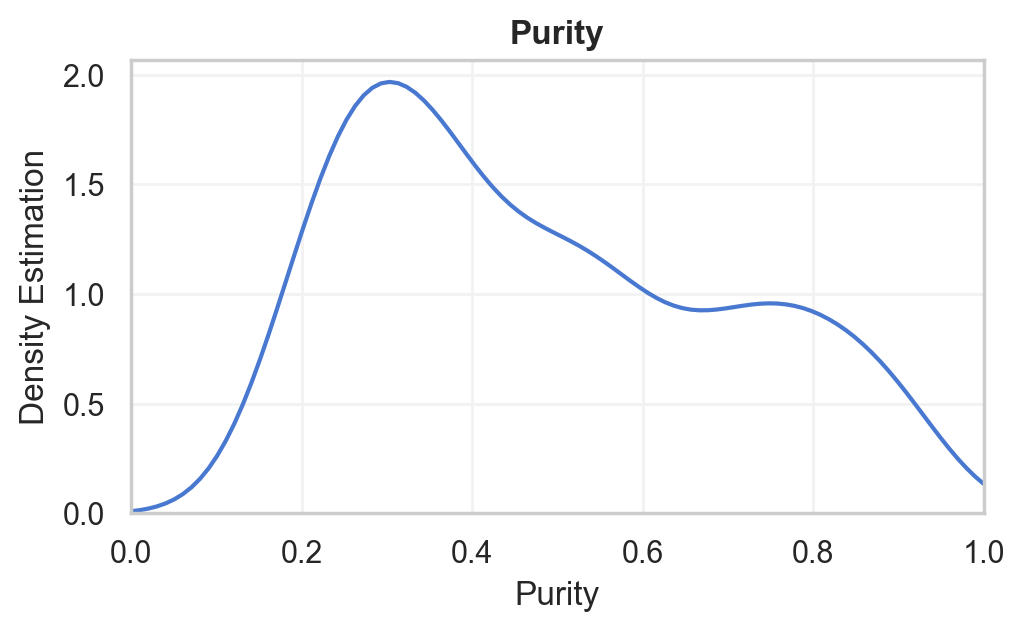

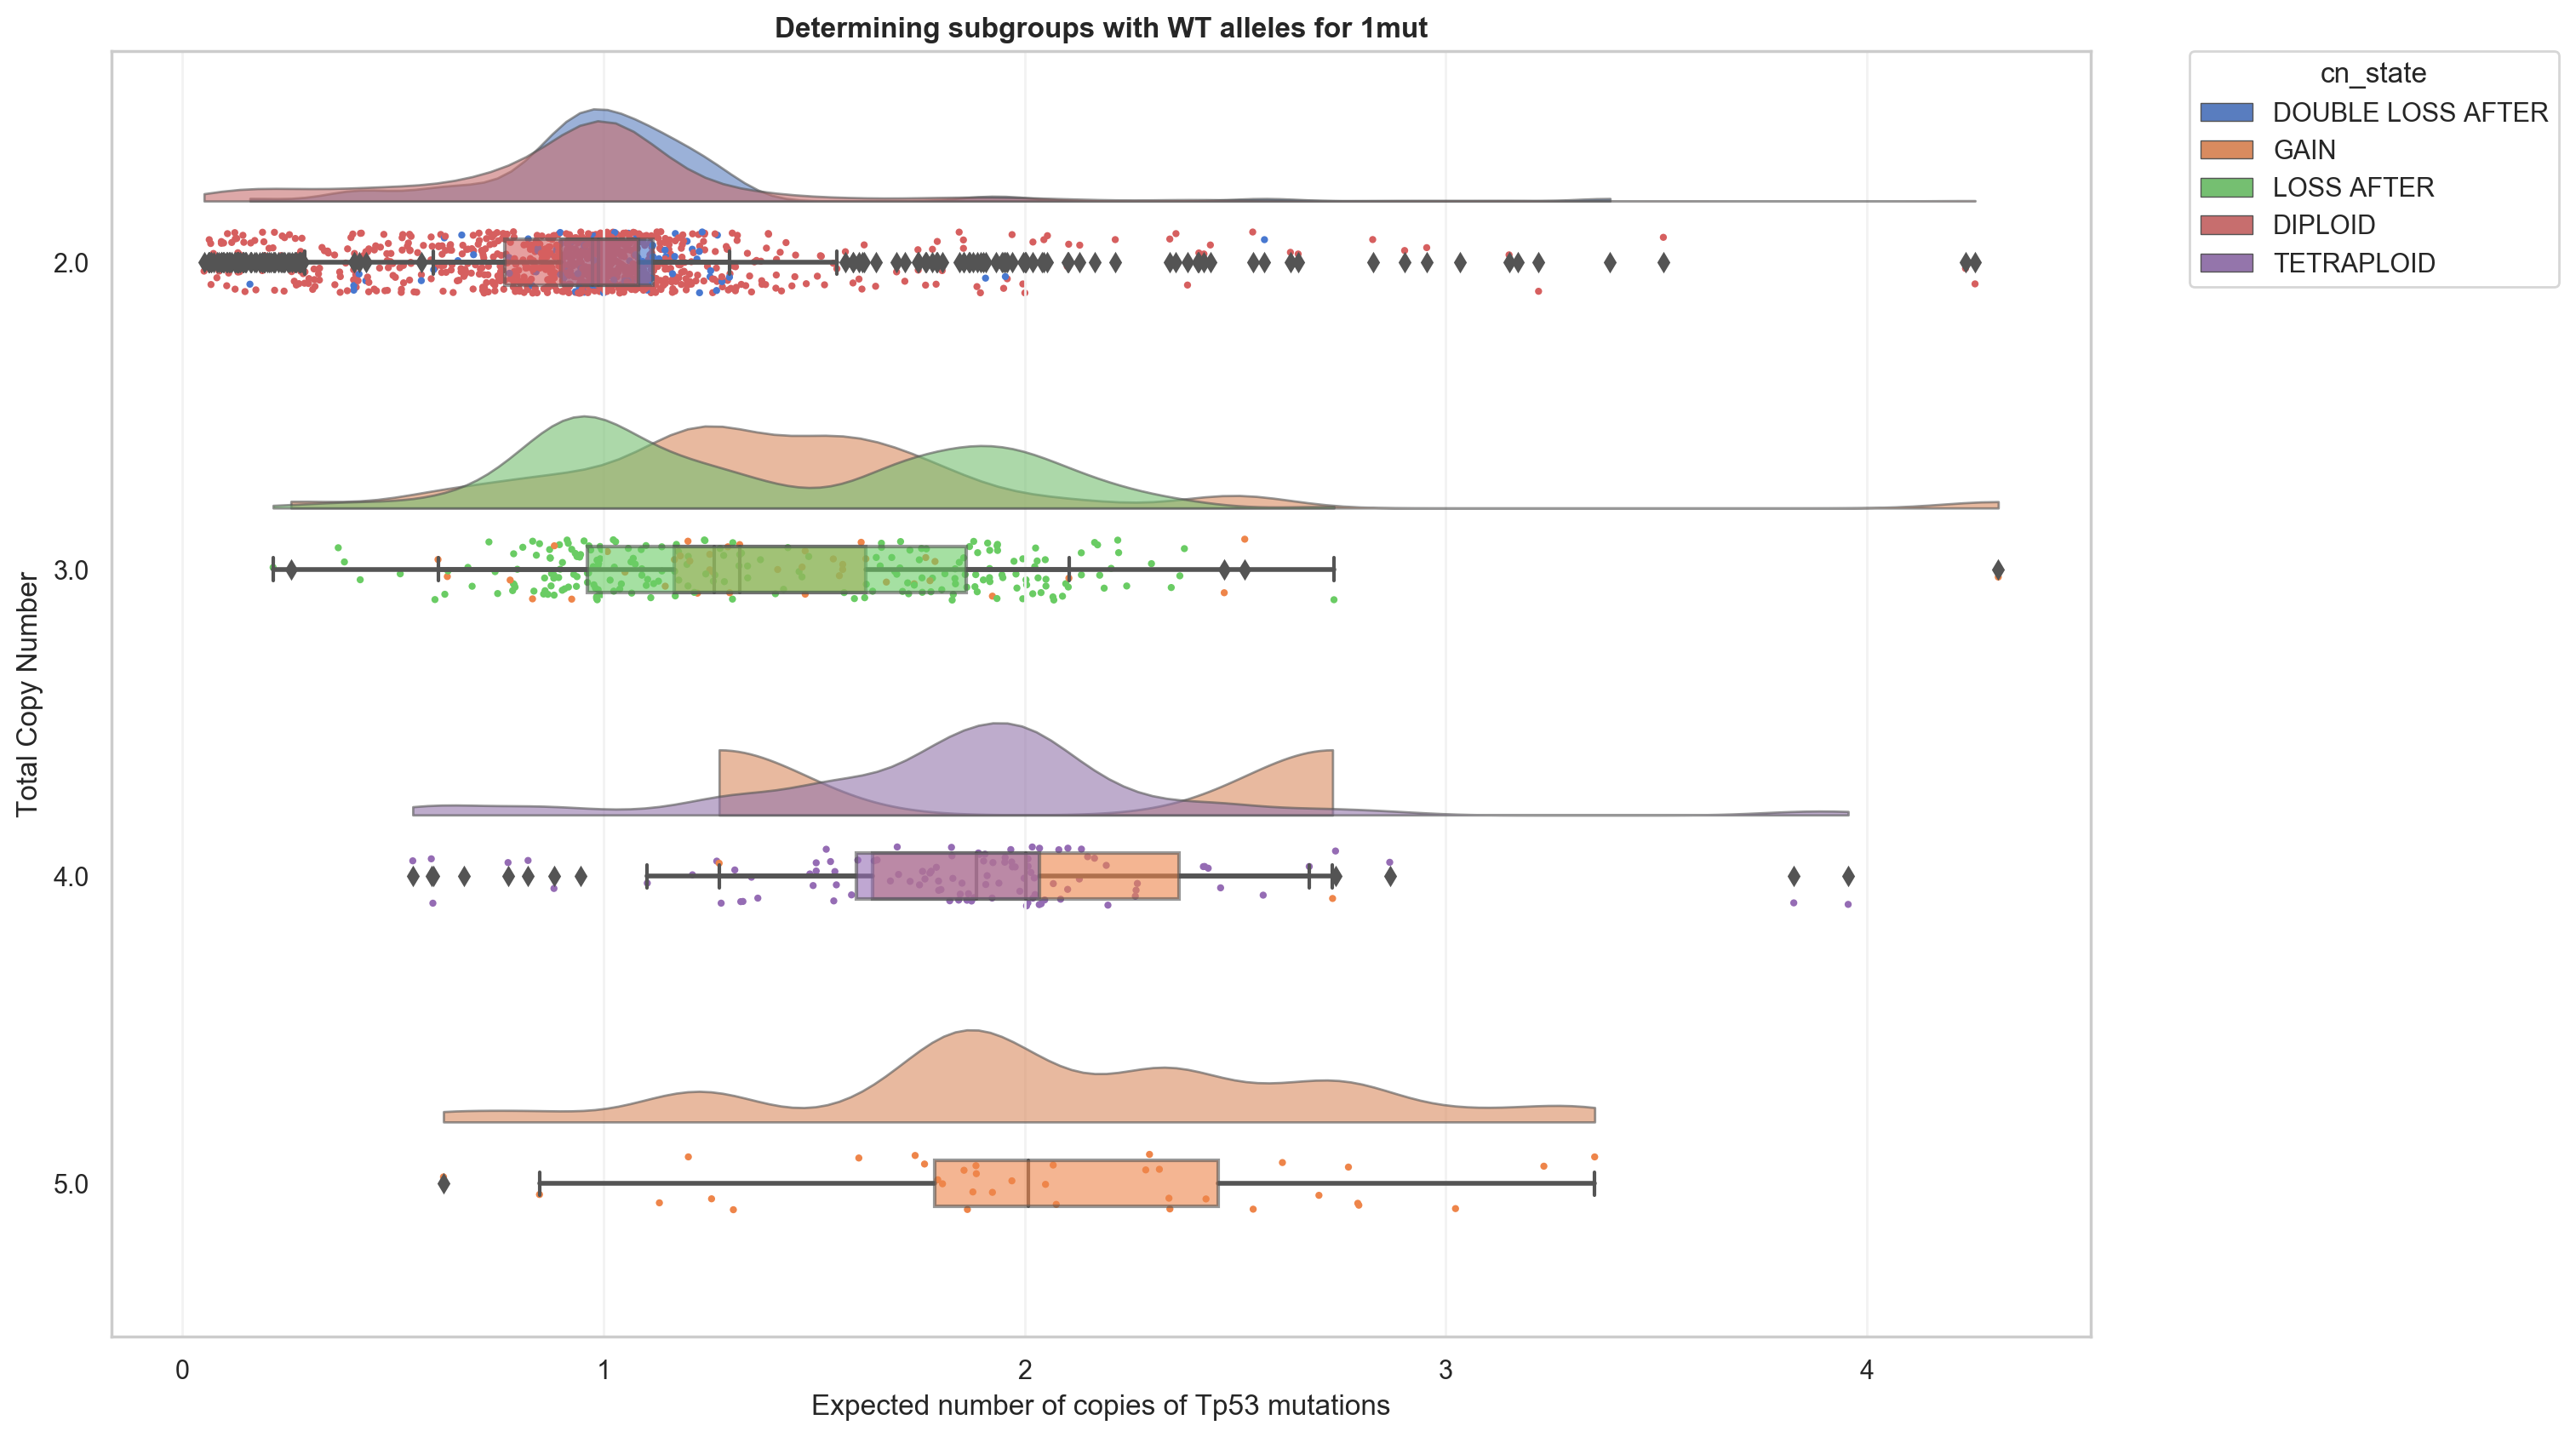

In [103]:
plot_summary(group=['>1muts'],group_name='>1muts',nb_muts_density=[2,3,4,5],nb_muts_scatter=[2,3,4,5], mut_cn_group=True)

count
cn_state       
HOMDEL       72

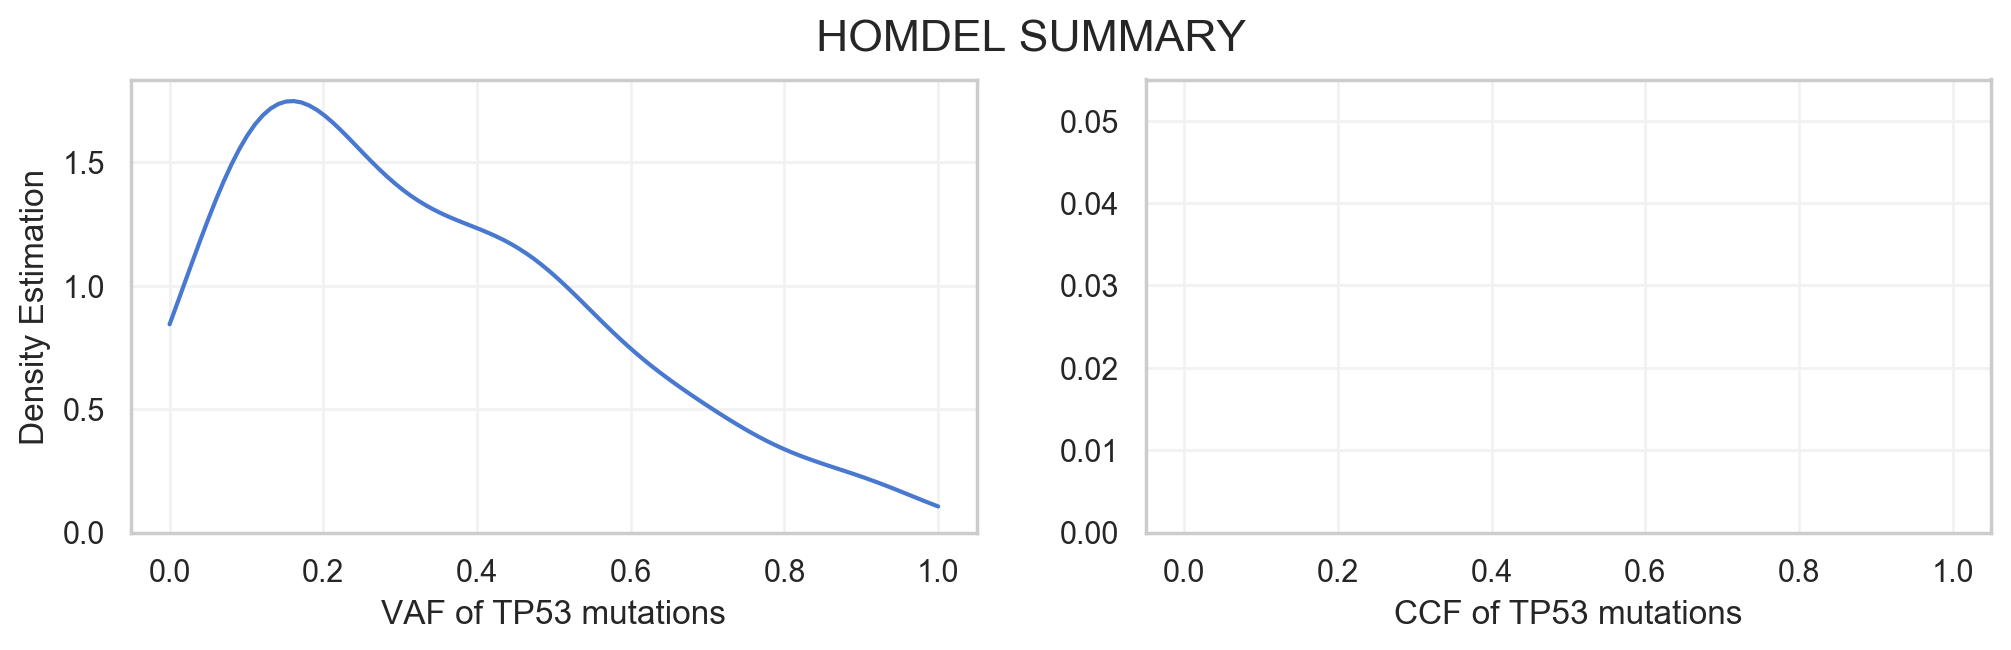

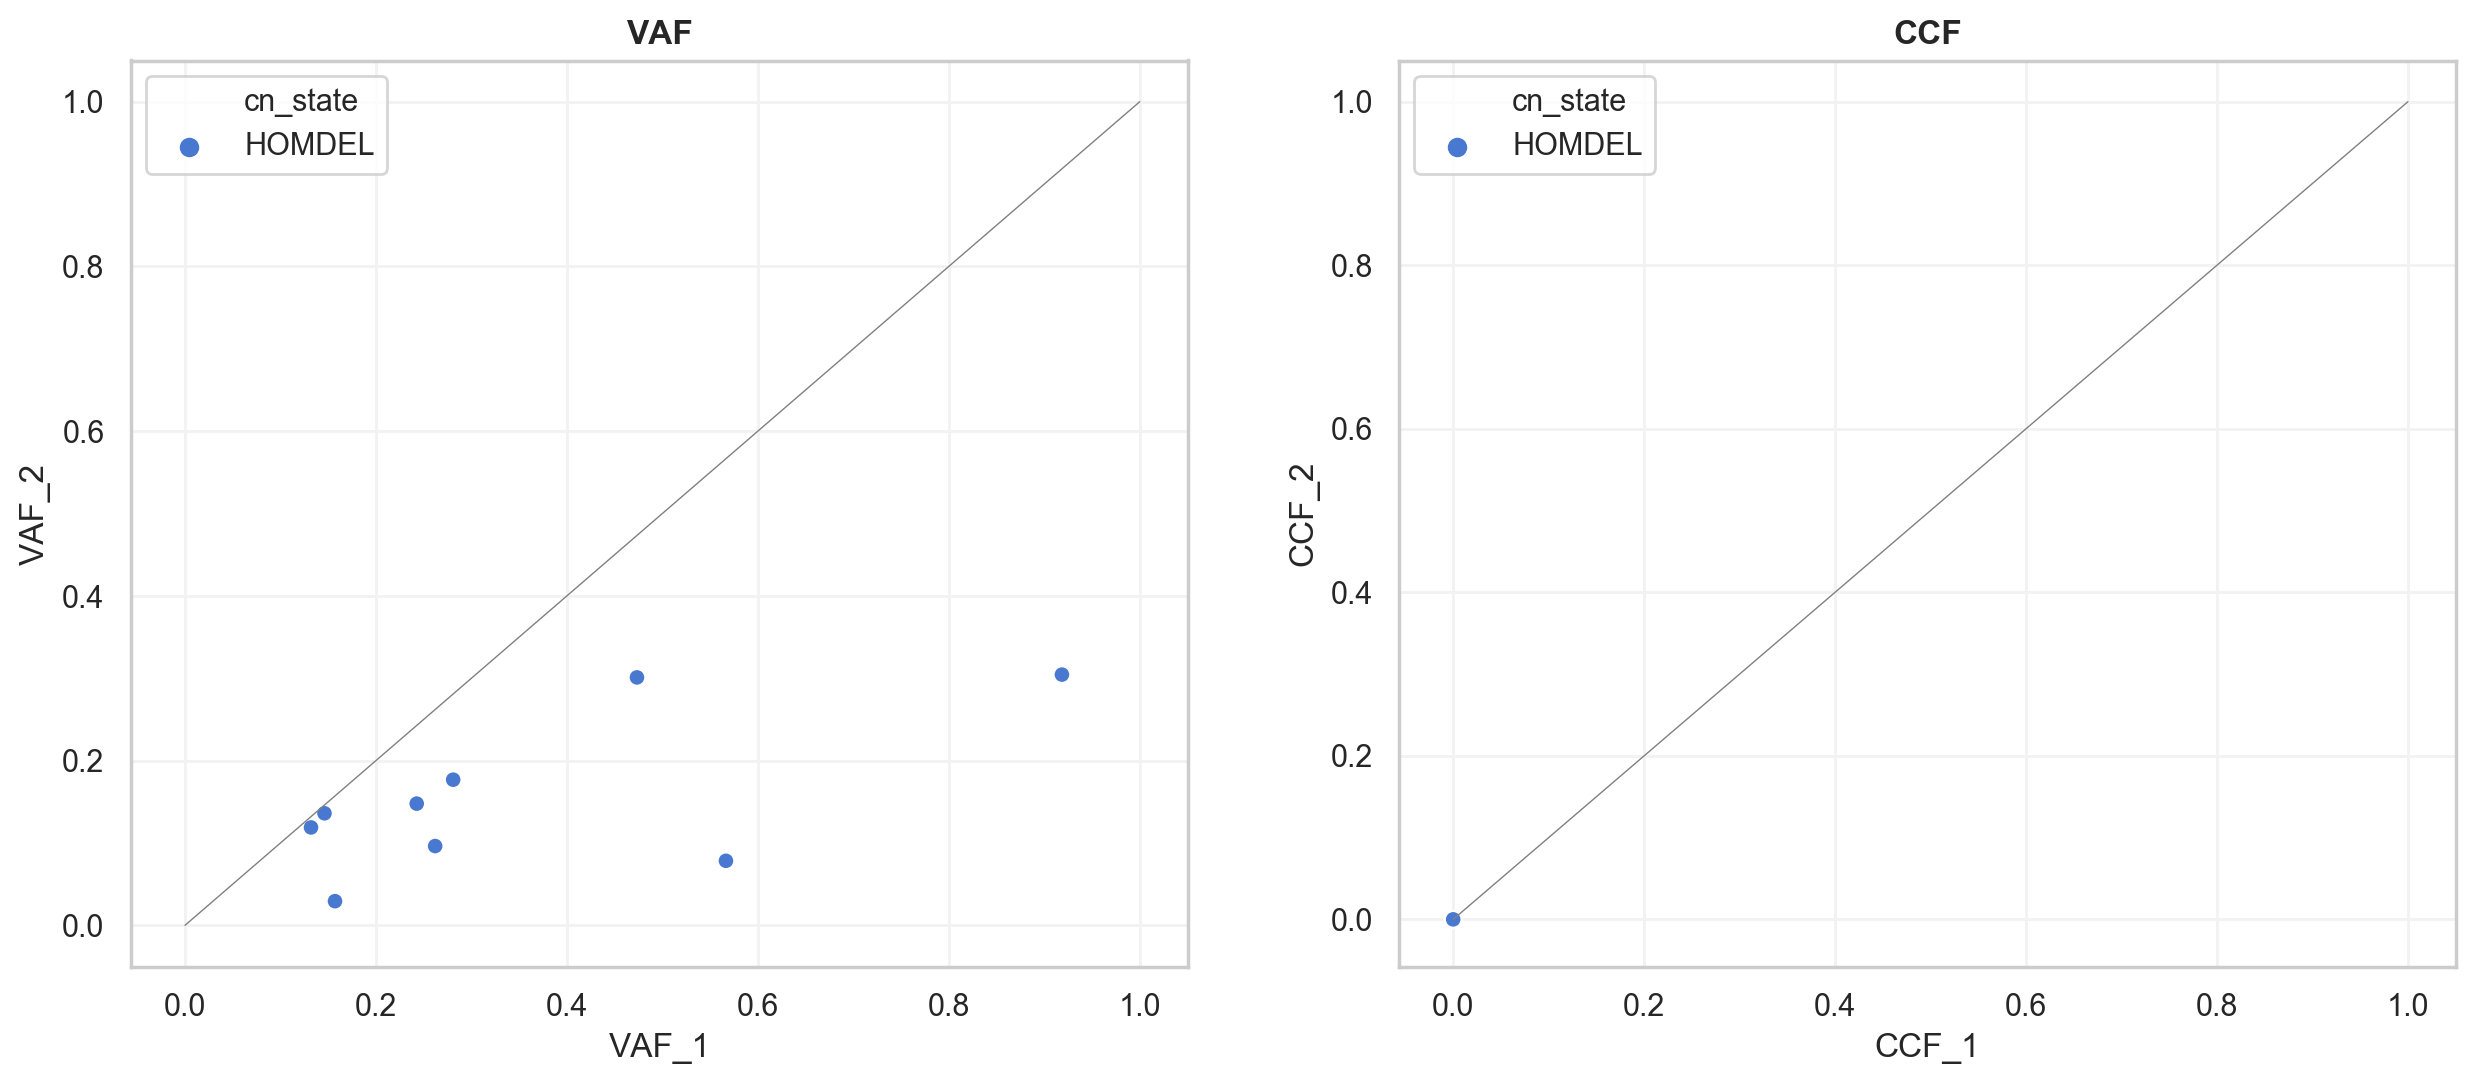

ValueError: There must be at least two hue levels to use `split`.'

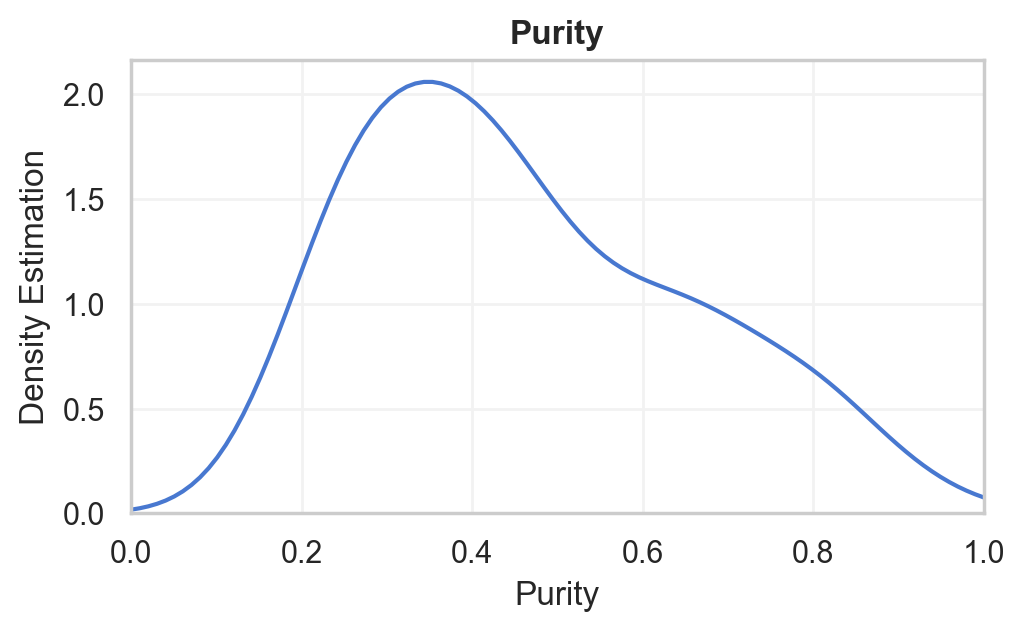

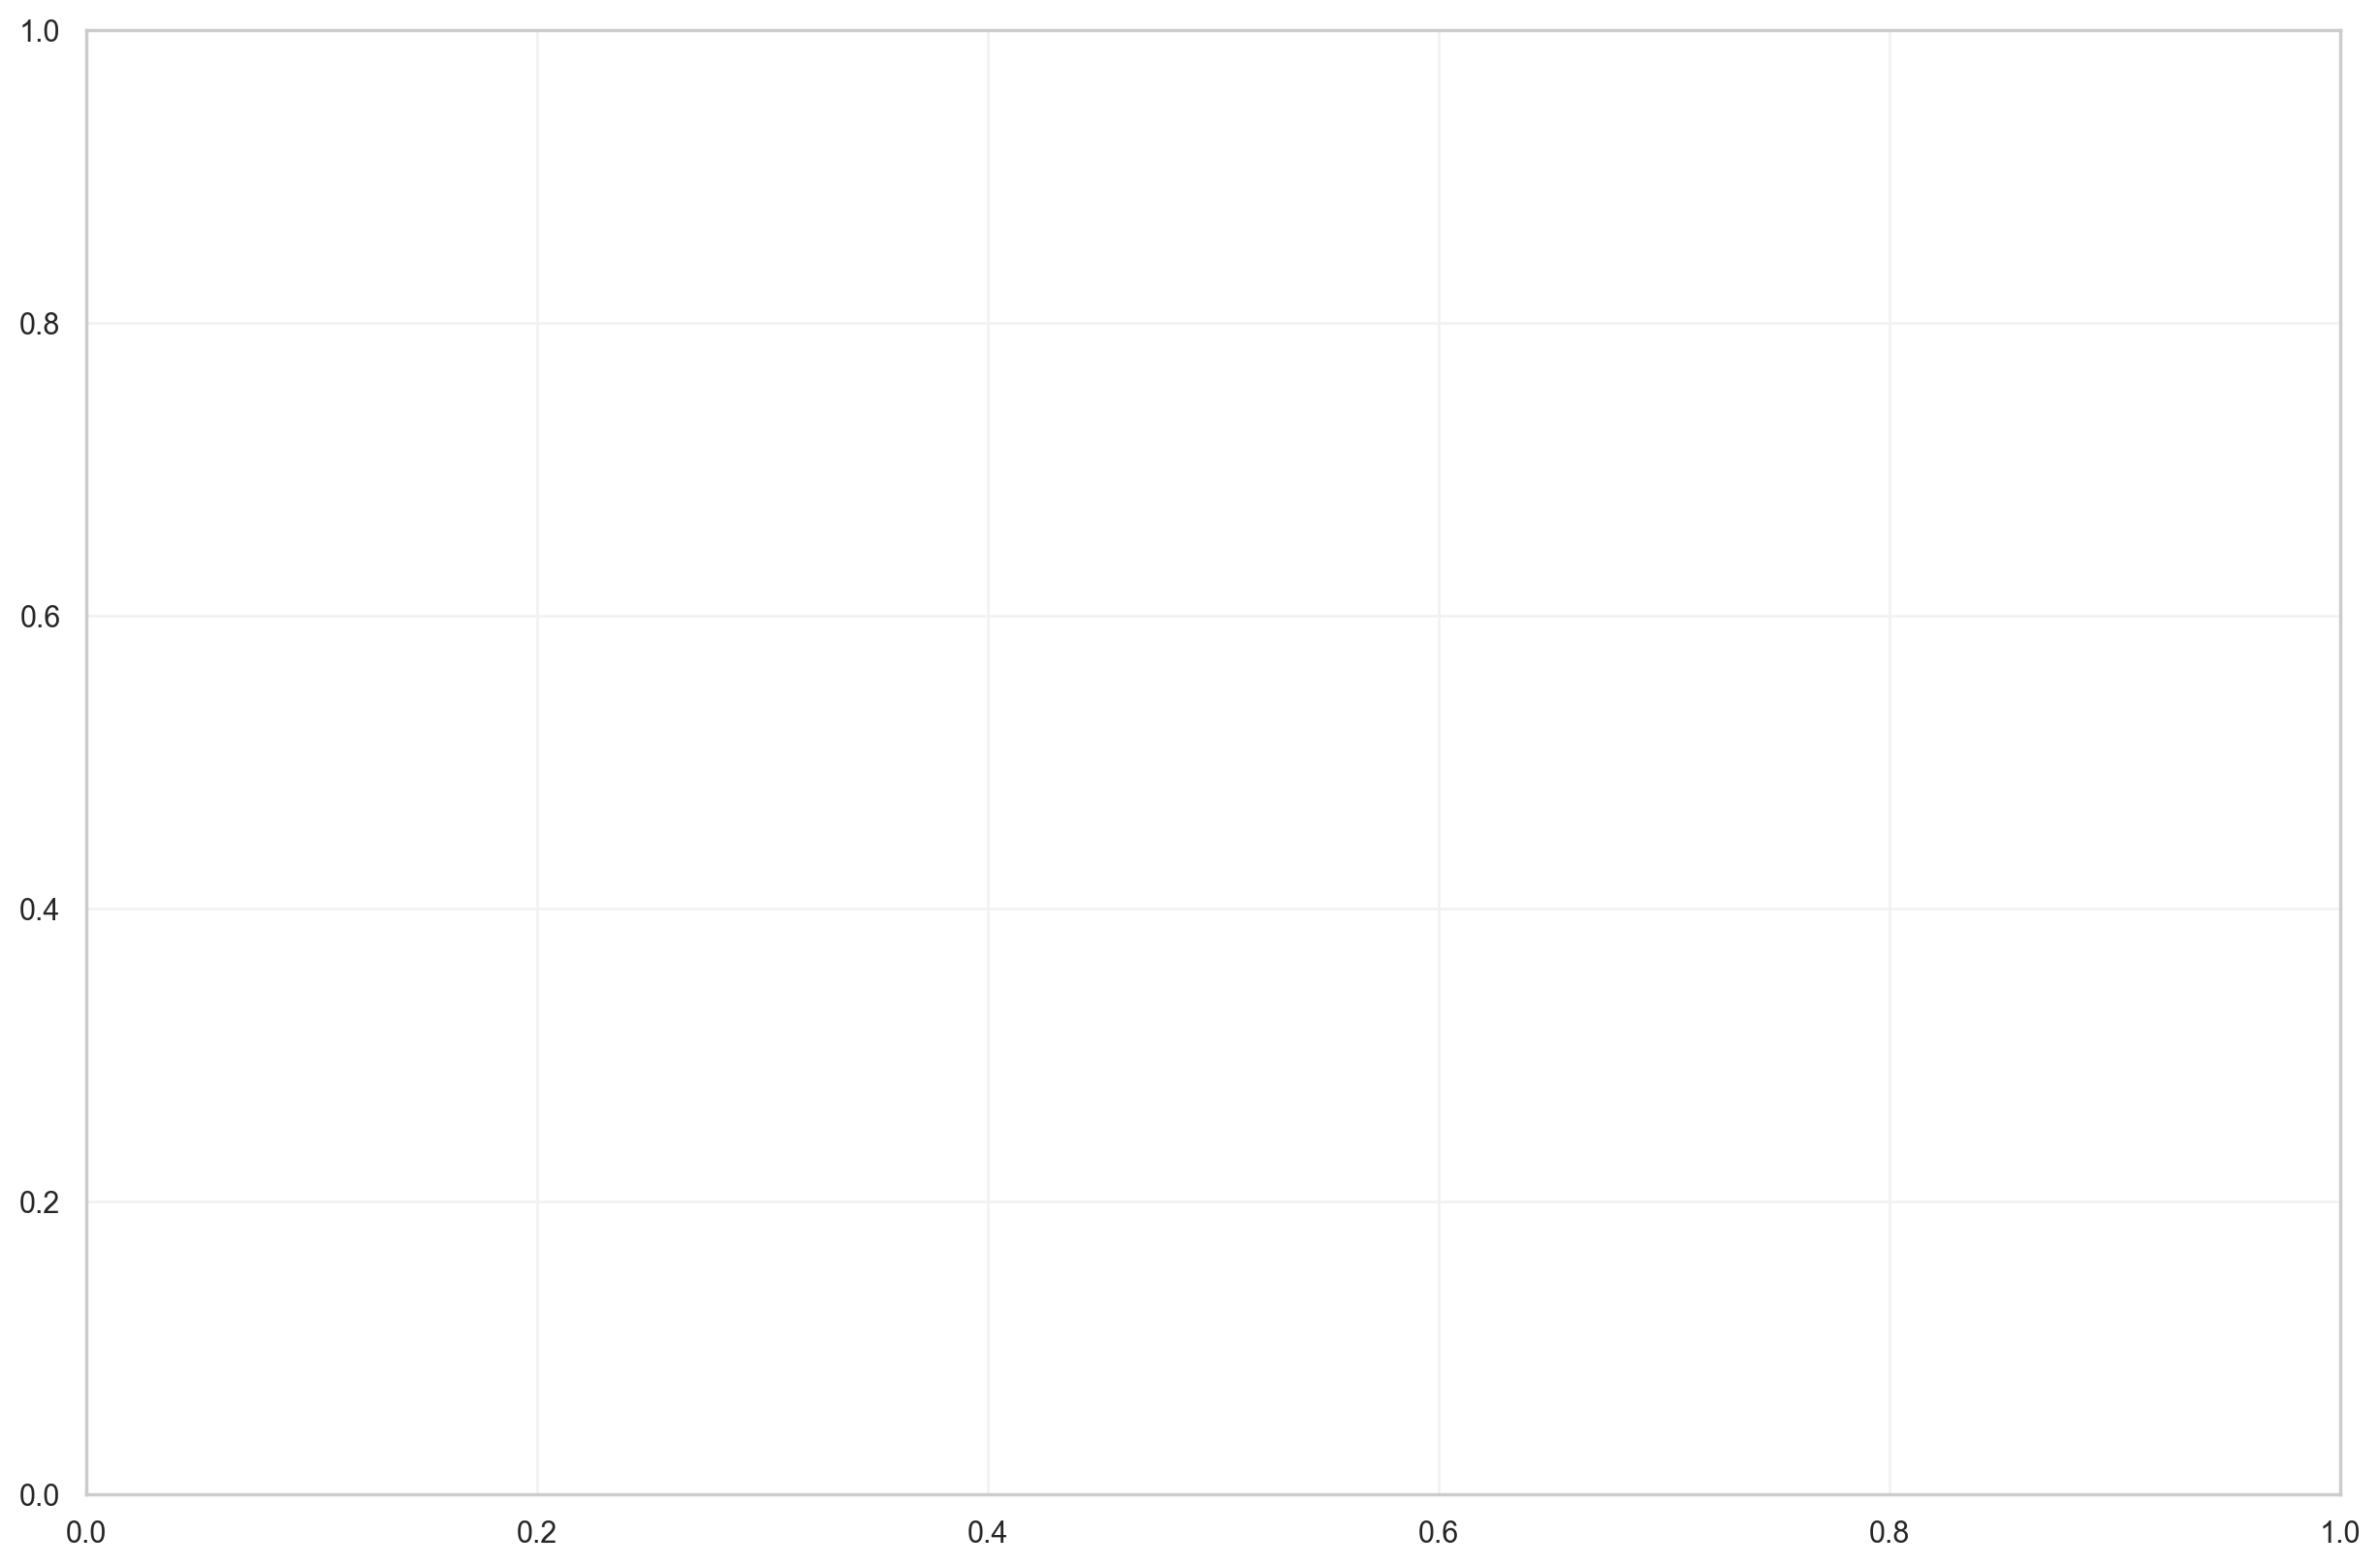

In [104]:
plot_summary(group=['HOMDEL'],group_name='HOMDEL',nb_muts_density=[1,2,4],nb_muts_scatter=[2,3,4,5], mut_cn_group=True)